In [1]:
# Importing all required libraries

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import missingno as msno
import statsmodels.api as sm

from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

from dpp.data import load_from_kaggle

/Users/ebbykuriakose/Desktop/Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download a dataset from Kaggle 

dataset_link = "gagandeep16/car-sales" # replace with your dataset link from Kaggle 
destination = "../data/raw"
dataset_name = dataset_link.split("/")[-1]

files = load_from_kaggle(
    dataset_link=dataset_link, 
    destination=destination,
    )

Destination directory '../data/raw/car-sales' already exists with files. Skipping download (replace=False).


In [3]:
files

['Car_sales.csv']

In [4]:
# Load and Preview Dataset
df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]))
df.head()

Manufacturer    Model  Sales_in_thousands  __year_resale_value Vehicle_type  \
0        Acura  Integra              16.919               16.360    Passenger   
1        Acura       TL              39.384               19.875    Passenger   
2        Acura       CL              14.114               18.225    Passenger   
3        Acura       RL               8.588               29.725    Passenger   
4         Audi       A4              20.397               22.255    Passenger   

   Price_in_thousands  Engine_size  Horsepower  Wheelbase  Width  Length  \
0               21.50          1.8       140.0      101.2   67.3   172.4   
1               28.40          3.2       225.0      108.1   70.3   192.9   
2                 NaN          3.2       225.0      106.9   70.6   192.0   
3               42.00          3.5       210.0      114.6   71.4   196.6   
4               23.99          1.8       150.0      102.6   68.2   178.0   

   Curb_weight  Fuel_capacity  Fuel_efficiency Latest_Launch  \
0        2.639           13.2             28.0      2/2/2012   
1        3.517           17.2             25.0      6/3/2011   
2        3.470           17.2             26.0      1/4/2012   
3        3.850           18.0             22.0     3/10/2011   
4        2.998           16.4             27.0     10/8/2011   

   Power_perf_factor  
0          58.280150  
1          91.370778  
2                NaN  
3          91.389779  
4          62.777639

In [5]:
# Dataset overview: shape, summary stats, and duplicates
display("Shape", df.shape,
        "Description", df.describe().round(2),
        "Duplicates", df.duplicated().sum())

# Column-level details: data types, missing values, unique counts, and sample values
pd.DataFrame({"Data Types": df.dtypes,
              "Unique Values": df.nunique(),
              "Sample Values": [df[col].sample(3).tolist() for col in df.columns]})

'Shape'

(157, 16)

'Description'

Sales_in_thousands  __year_resale_value  Price_in_thousands  \
count              157.00               121.00              155.00   
mean                53.00                18.07               27.39   
std                 68.03                11.45               14.35   
min                  0.11                 5.16                9.24   
25%                 14.11                11.26               18.02   
50%                 29.45                14.18               22.80   
75%                 67.96                19.88               31.95   
max                540.56                67.55               85.50   

       Engine_size  Horsepower  Wheelbase   Width  Length  Curb_weight  \
count       156.00      156.00     156.00  156.00  156.00       155.00   
mean          3.06      185.95     107.49   71.15  187.34         3.38   
std           1.04       56.70       7.64    3.45   13.43         0.63   
min           1.00       55.00      92.60   62.60  149.40         1.90   
25%           2.30      149.50     103.00   68.40  177.58         2.97   
50%           3.00      177.50     107.00   70.55  187.90         3.34   
75%           3.58      215.00     112.20   73.43  196.12         3.80   
max           8.00      450.00     138.70   79.90  224.50         5.57   

       Fuel_capacity  Fuel_efficiency  Power_perf_factor  
count         156.00           154.00             155.00  
mean           17.95            23.84              77.04  
std             3.89             4.28              25.14  
min            10.30            15.00              23.28  
25%            15.80            21.00              60.41  
50%            17.20            24.00              72.03  
75%            19.58            26.00              89.41  
max            32.00            45.00             188.14

'Duplicates'

np.int64(0)

Data Types  Unique Values  \
Manufacturer            object             30   
Model                   object            156   
Sales_in_thousands     float64            157   
__year_resale_value    float64            117   
Vehicle_type            object              2   
Price_in_thousands     float64            152   
Engine_size            float64             31   
Horsepower             float64             66   
Wheelbase              float64             88   
Width                  float64             78   
Length                 float64            127   
Curb_weight            float64            147   
Fuel_capacity          float64             55   
Fuel_efficiency        float64             20   
Latest_Launch           object            130   
Power_perf_factor      float64            154   

                                              Sample Values  
Manufacturer                        [Jeep, Mercury, Nissan]  
Model                             [323i, Wrangler, Durango]  
Sales_in_thousands                   [14.69, 73.203, 7.998]  
__year_resale_value                    [13.325, nan, 11.03]  
Vehicle_type                                [Car, Car, Car]  
Price_in_thousands                 [17.885, 21.315, 22.195]  
Engine_size                                 [1.5, 3.5, 4.6]  
Horsepower                            [119.0, 227.0, 222.0]  
Wheelbase                              [107.3, 96.2, 120.7]  
Width                                    [67.6, 74.4, 74.5]  
Length                                [207.7, 188.8, 174.5]  
Curb_weight                           [3.492, 3.443, 2.853]  
Fuel_capacity                            [20.5, 16.4, 18.5]  
Fuel_efficiency                          [30.0, 19.0, 15.0]  
Latest_Launch            [5/31/2011, 5/31/2011, 12/10/2011]  
Power_perf_factor    [82.6613556, 76.58443962, 84.91189826]

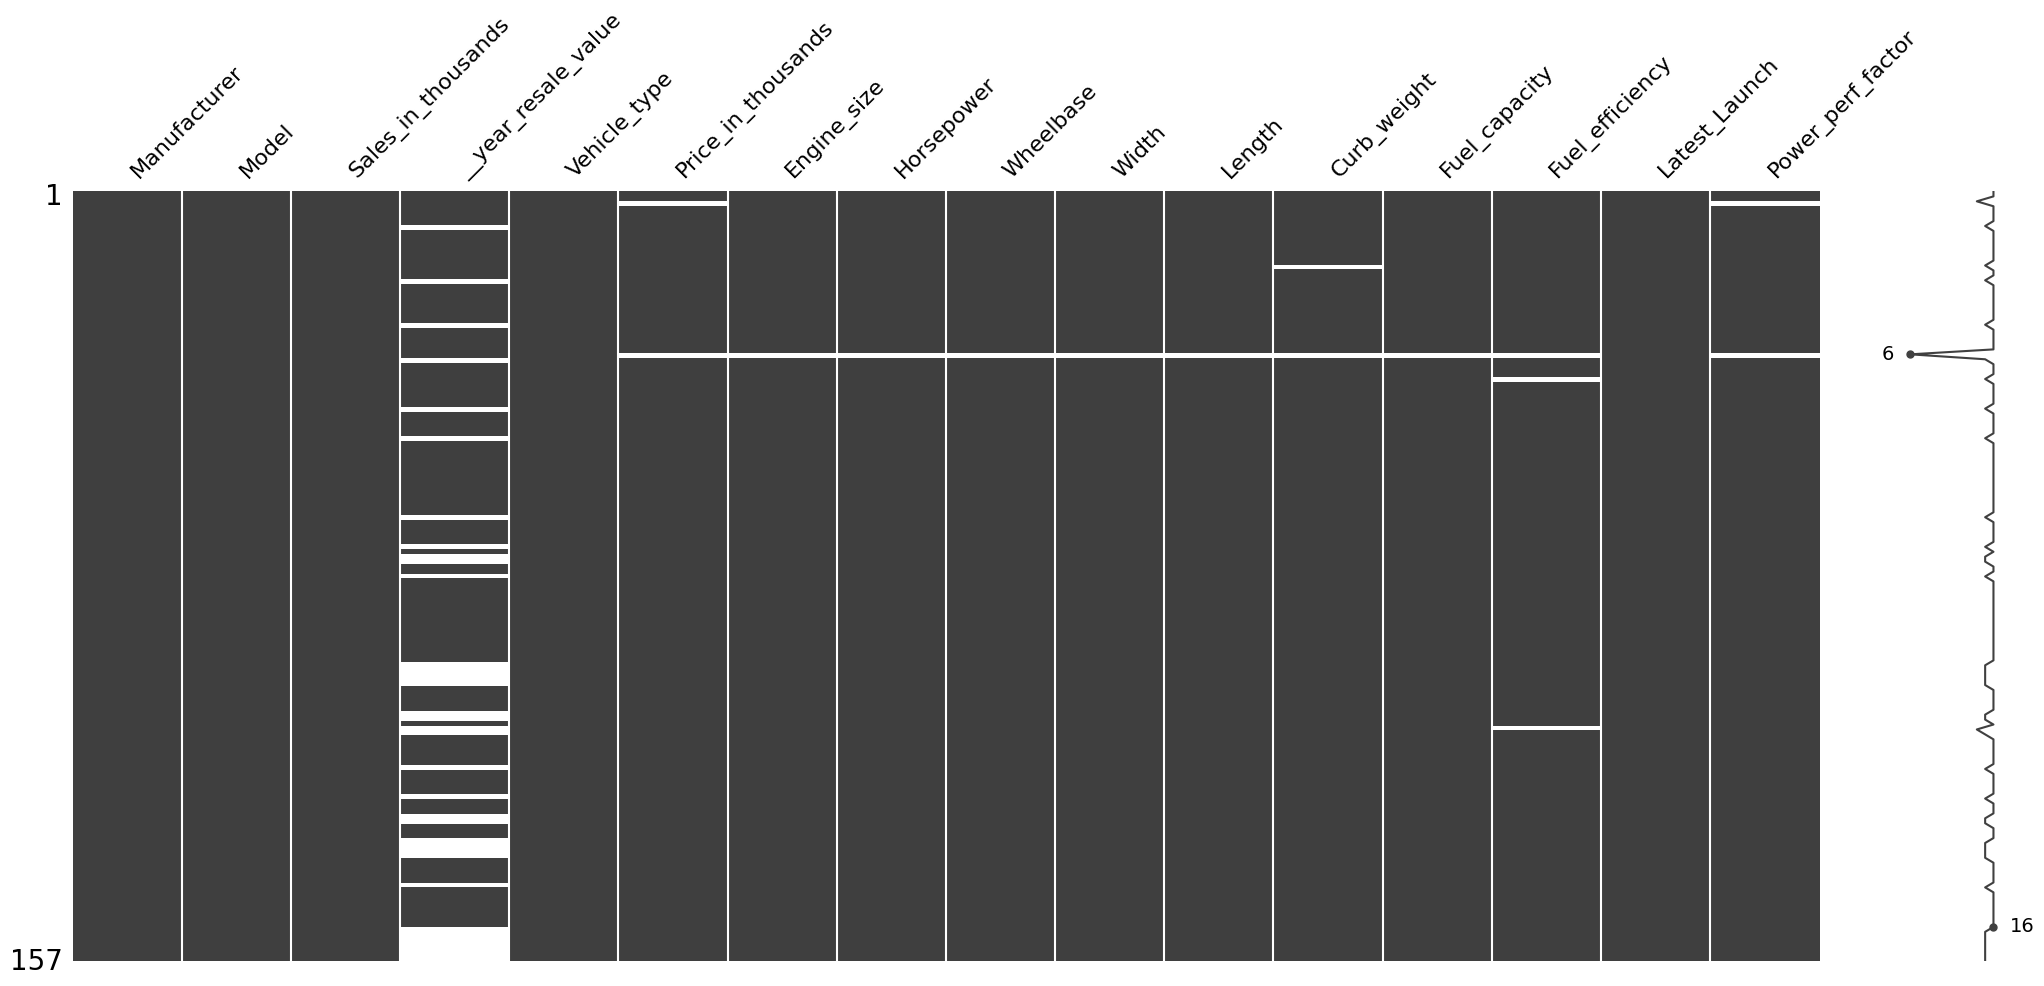

In [6]:
# Visualizing missing values in the dataset
msno.matrix(df)
plt.show()

In [7]:
# Rename column '__year_resale_value' to 'Year_resale_value' if it exists

if '__year_resale_value' in df.columns:
    df.rename(columns={'__year_resale_value': 'Year_resale_value'}, inplace=True)

In [8]:
# Converted specified columns to categorical type

category_col = ['Manufacturer','Model','Vehicle_type']
for col in category_col:
    df[col] = df[col].astype('category')

# Convert the 'Latest_Launch' column from string format MM/DD/YYYY to datetime objects.
df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'], format='%m/%d/%Y', errors='coerce')

In [9]:
# Remove rows with >=3 missing (NaN) values
df = df[df.isna().sum(axis=1) < 3]

In [10]:
# Median imputation for 'Price_in_thousands', 'Power_perf_factor' 'Curb_weight'

for col in ['Price_in_thousands', 'Power_perf_factor', 'Curb_weight']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

In [11]:
# Identify highly correlated columns for each numeric feature.

corr_matrix = df.corr(numeric_only=True).abs() 
threshold = 0.6

# Create a boolean mask of correlations above threshold (excluding diagonal)
mask = (corr_matrix > threshold) & (~np.eye(corr_matrix.shape[0], dtype=bool))

# Extract dependent columns as a dictionary
dependent_columns = {col: list(corr_matrix.columns[mask[col]]) for col in corr_matrix.columns}
dependent_df = pd.DataFrame(list(dependent_columns.items()), columns=['Column', 'Dependent Columns'])

pd.set_option('display.max_colwidth', None)
print(dependent_df)

                Column  \
0   Sales_in_thousands   
1    Year_resale_value   
2   Price_in_thousands   
3          Engine_size   
4           Horsepower   
5            Wheelbase   
6                Width   
7               Length   
8          Curb_weight   
9        Fuel_capacity   
10     Fuel_efficiency   
11   Power_perf_factor   

                                                                                          Dependent Columns  
0                                                                                                        []  
1                                                       [Price_in_thousands, Horsepower, Power_perf_factor]  
2                                           [Year_resale_value, Engine_size, Horsepower, Power_perf_factor]  
3   [Price_in_thousands, Horsepower, Width, Curb_weight, Fuel_capacity, Fuel_efficiency, Power_perf_factor]  
4     [Year_resale_value, Price_in_thousands, Engine_size, Curb_weight, Fuel_efficiency, Power_perf_factor]  
5

In [12]:
# Function to impute missing values using Linear Regression 

def impute_with_regression(df, target_col, features):
    """
    Impute missing values in target_col using Linear Regression on given features.
    """
    # Split data into rows with and without target_col
    train_data = df[df[target_col].notnull()]
    test_data = df[df[target_col].isnull()]
    
    if test_data.empty:
        print(f"No missing values in {target_col}")
        return df
    
    missing_idx = test_data.index

    X_train = train_data[features]
    y_train = train_data[target_col]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    X_test = test_data[features]
    predicted_values = model.predict(X_test)
    
    df.loc[missing_idx, target_col] = predicted_values
    return df

In [13]:
# Apply regression-based imputations

features_fuel_efficiency = ['Engine_size', 'Horsepower', 'Width', 'Curb_weight', 'Fuel_capacity', 'Power_perf_factor']
features_resale_value = ['Price_in_thousands', 'Horsepower', 'Power_perf_factor']

# Function call
df = impute_with_regression(df, 'Year_resale_value', features_resale_value)
df = impute_with_regression(df, 'Fuel_efficiency', features_fuel_efficiency)

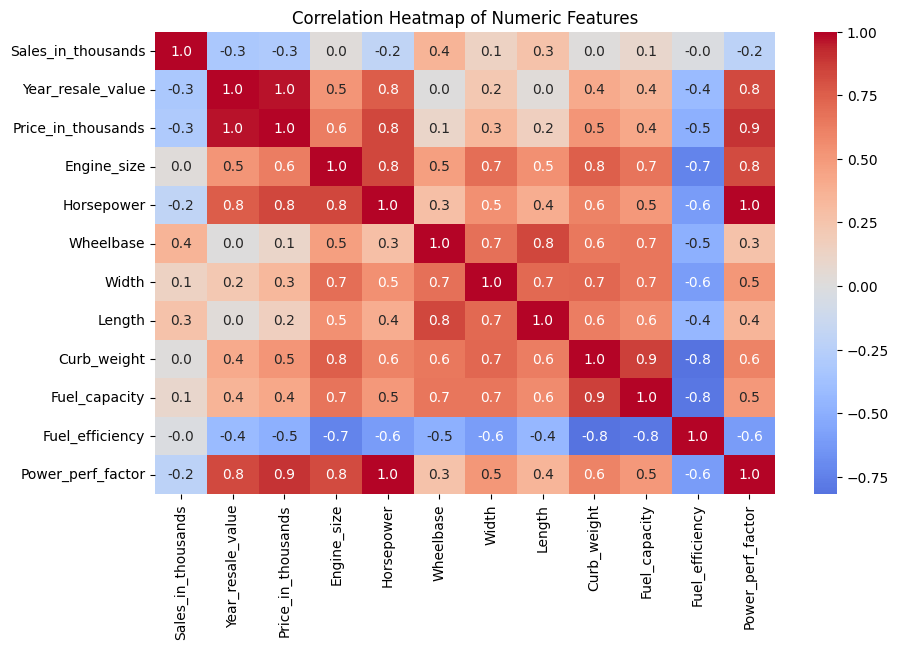

In [14]:
# Correlation heatmap between all numeric features

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0, fmt='.1f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


Column: Sales_in_thousands
Skewness: 3.40
Highly right-skewed


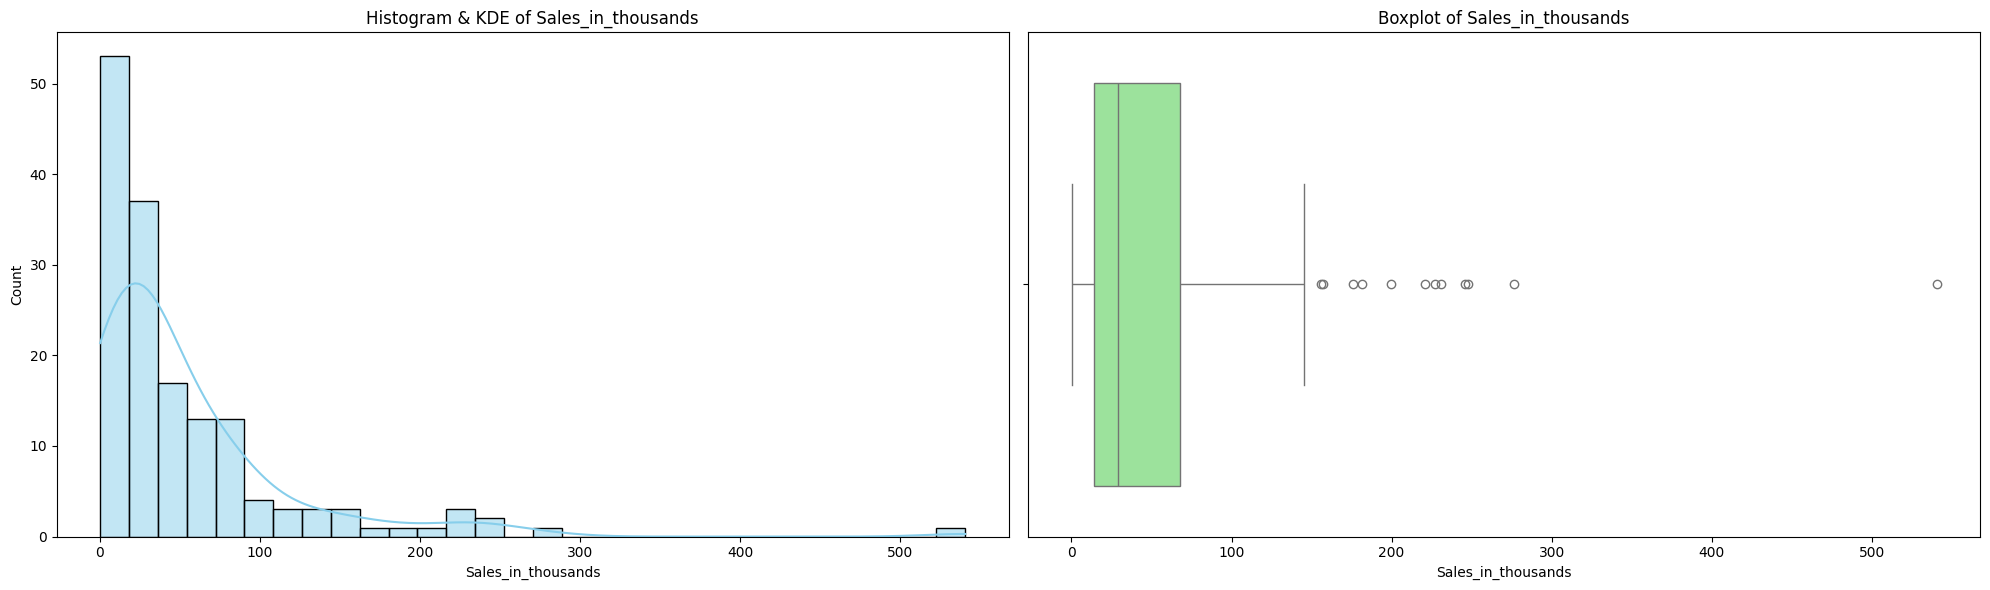


Column: Year_resale_value
Skewness: 2.08
Highly right-skewed


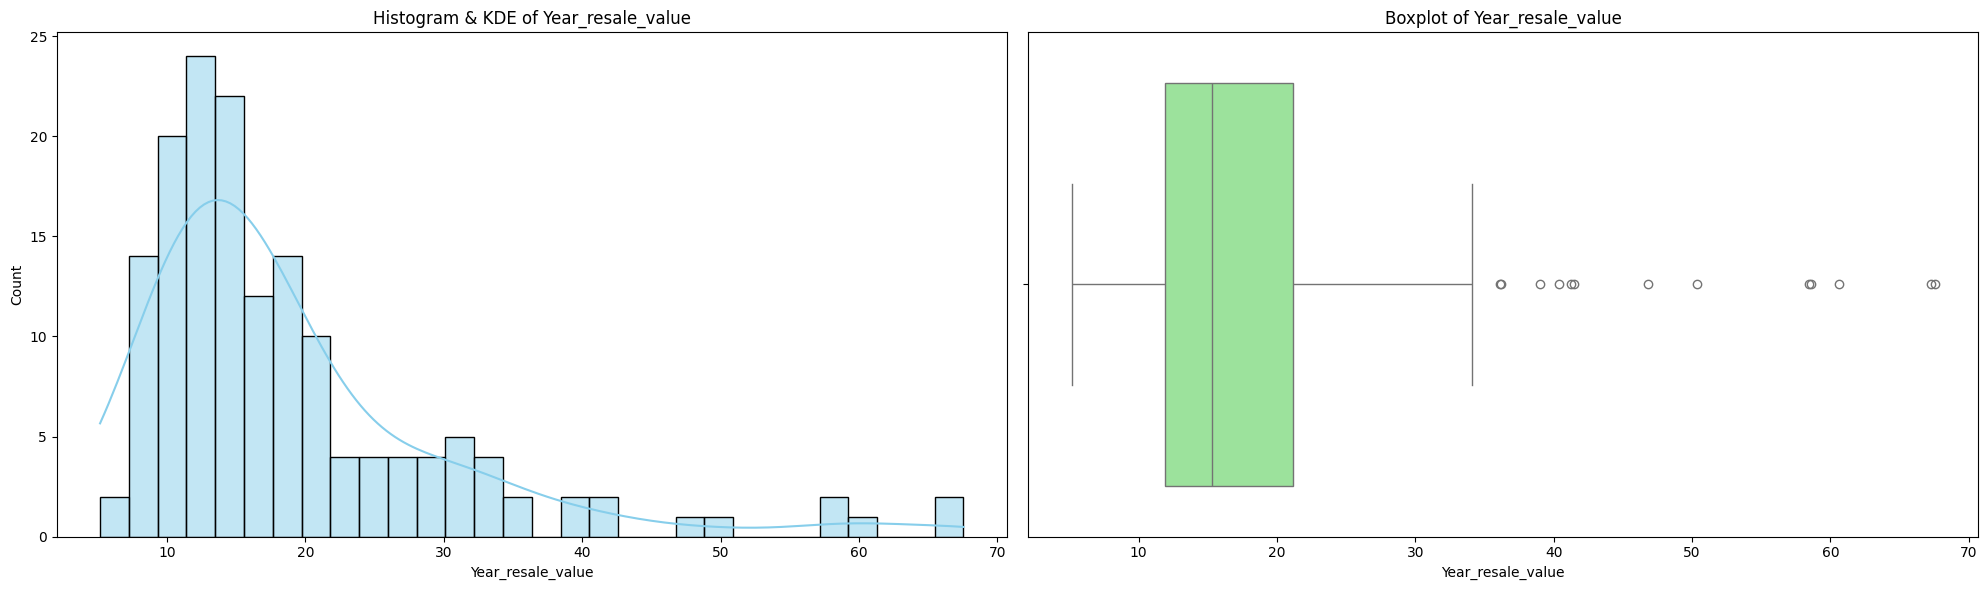


Column: Price_in_thousands
Skewness: 1.78
Highly right-skewed


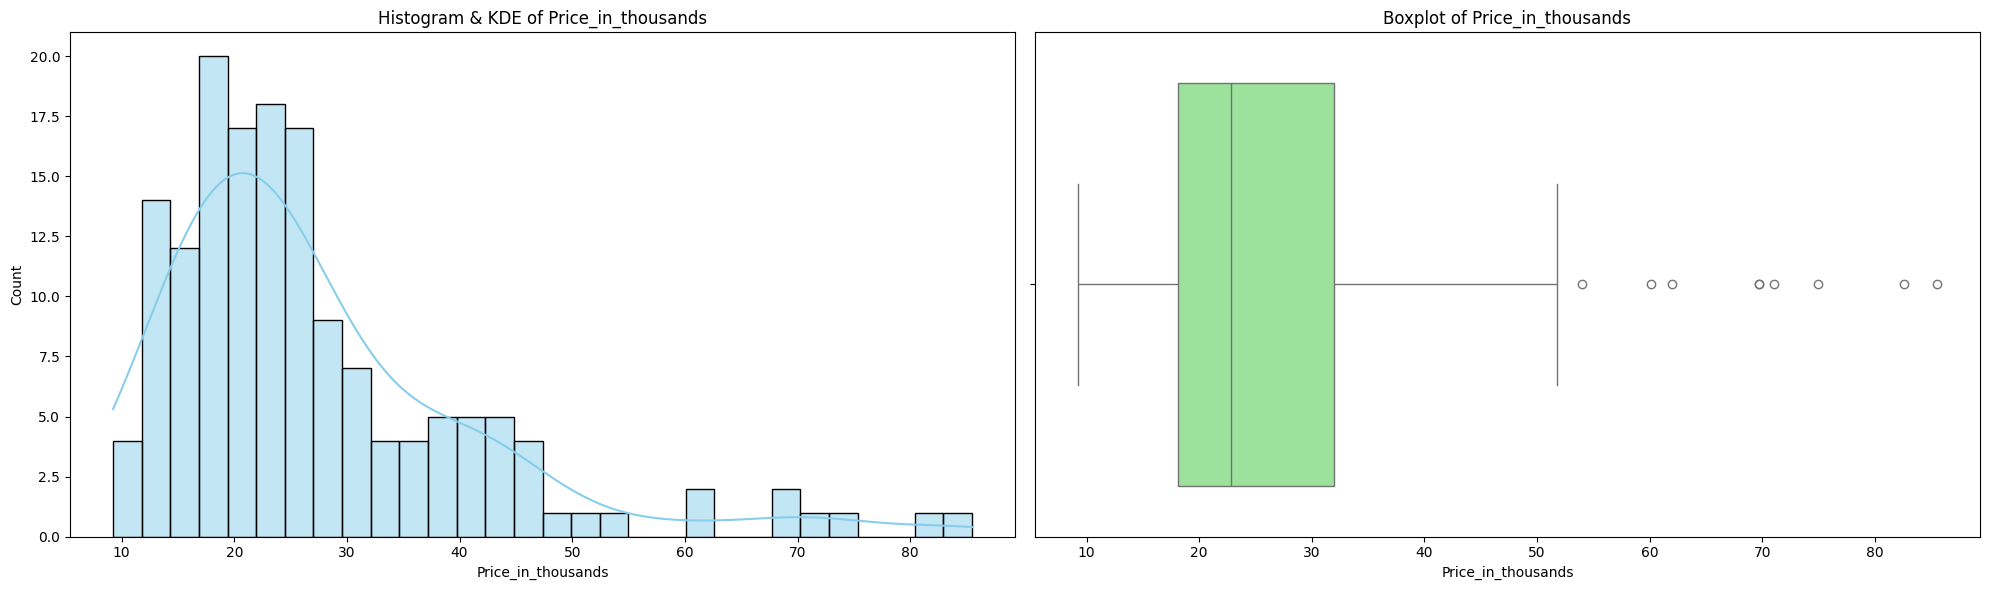


Column: Engine_size
Skewness: 1.10
Highly right-skewed


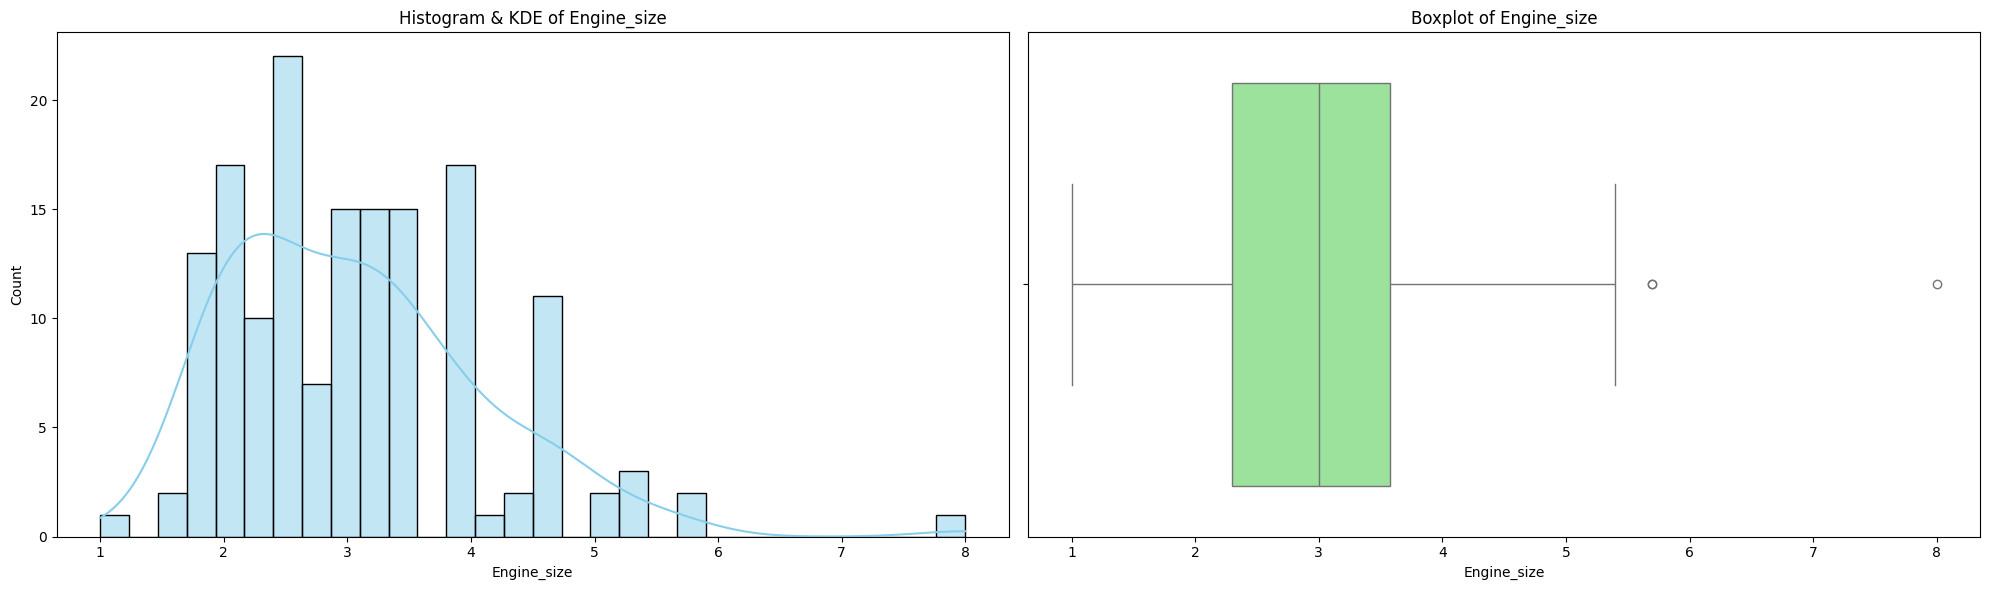


Column: Horsepower
Skewness: 1.00
Highly right-skewed


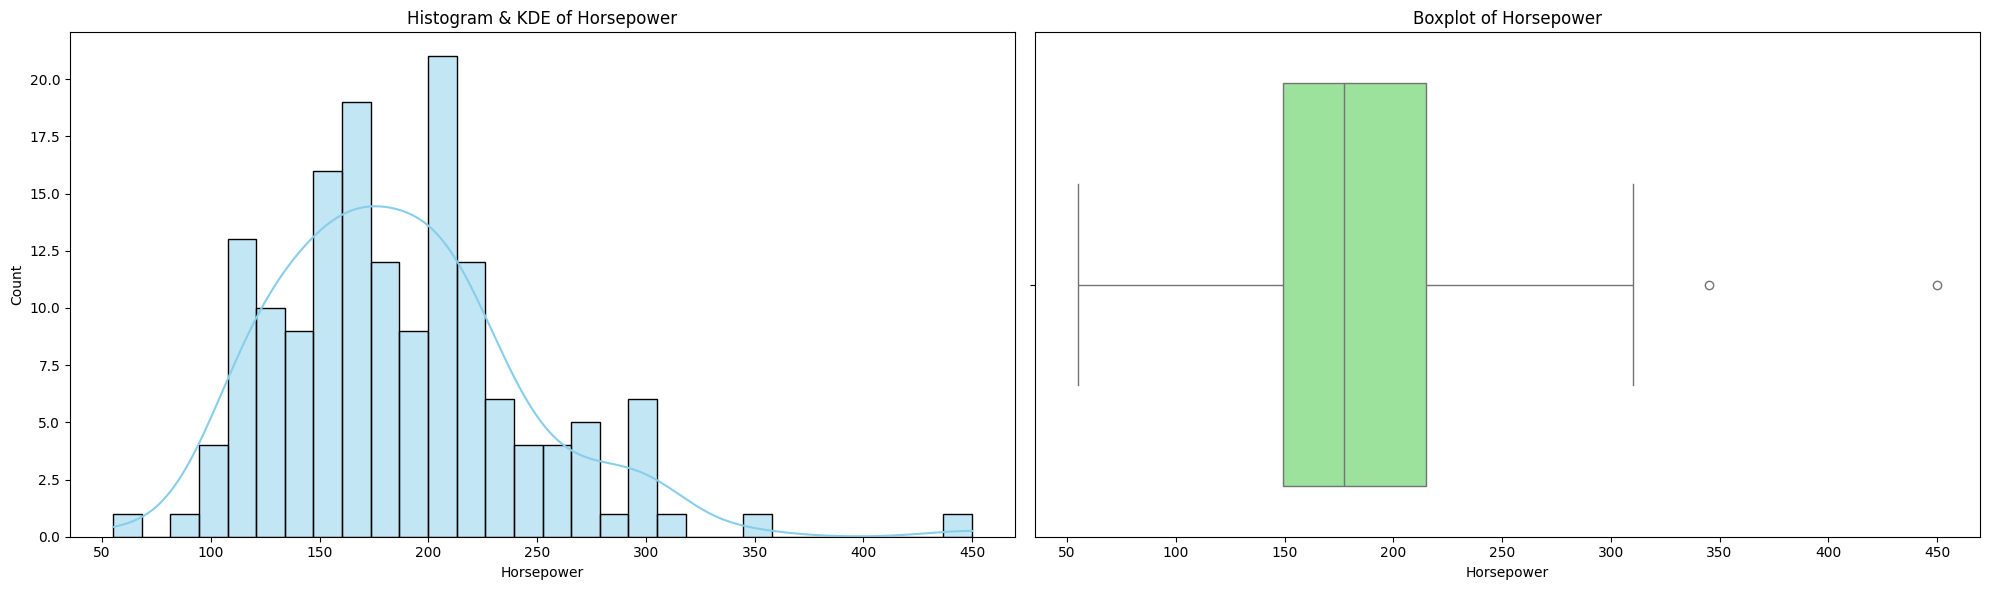


Column: Wheelbase
Skewness: 0.97
Moderately right-skewed


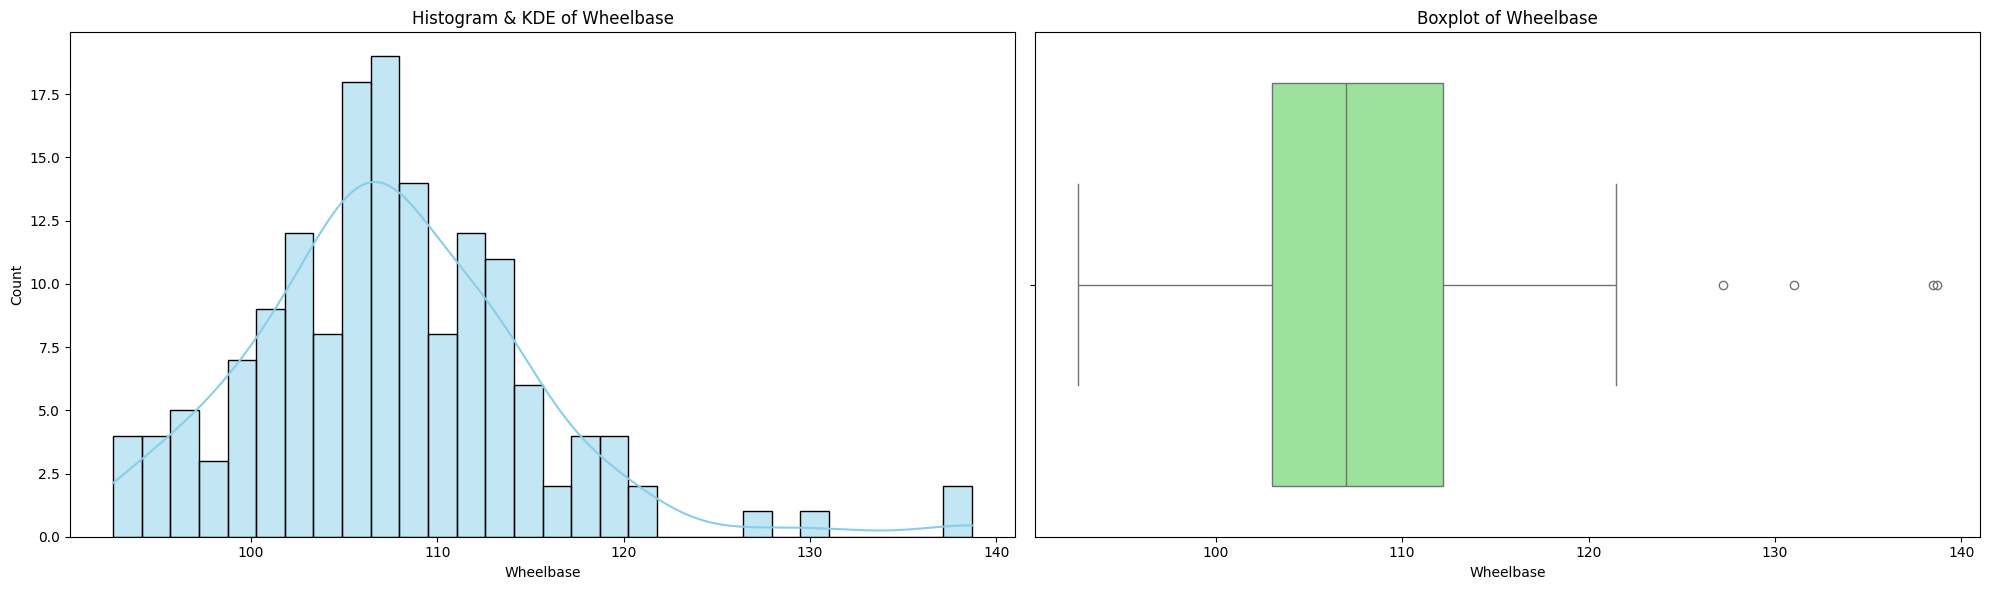


Column: Width
Skewness: 0.48
Approximately symmetric


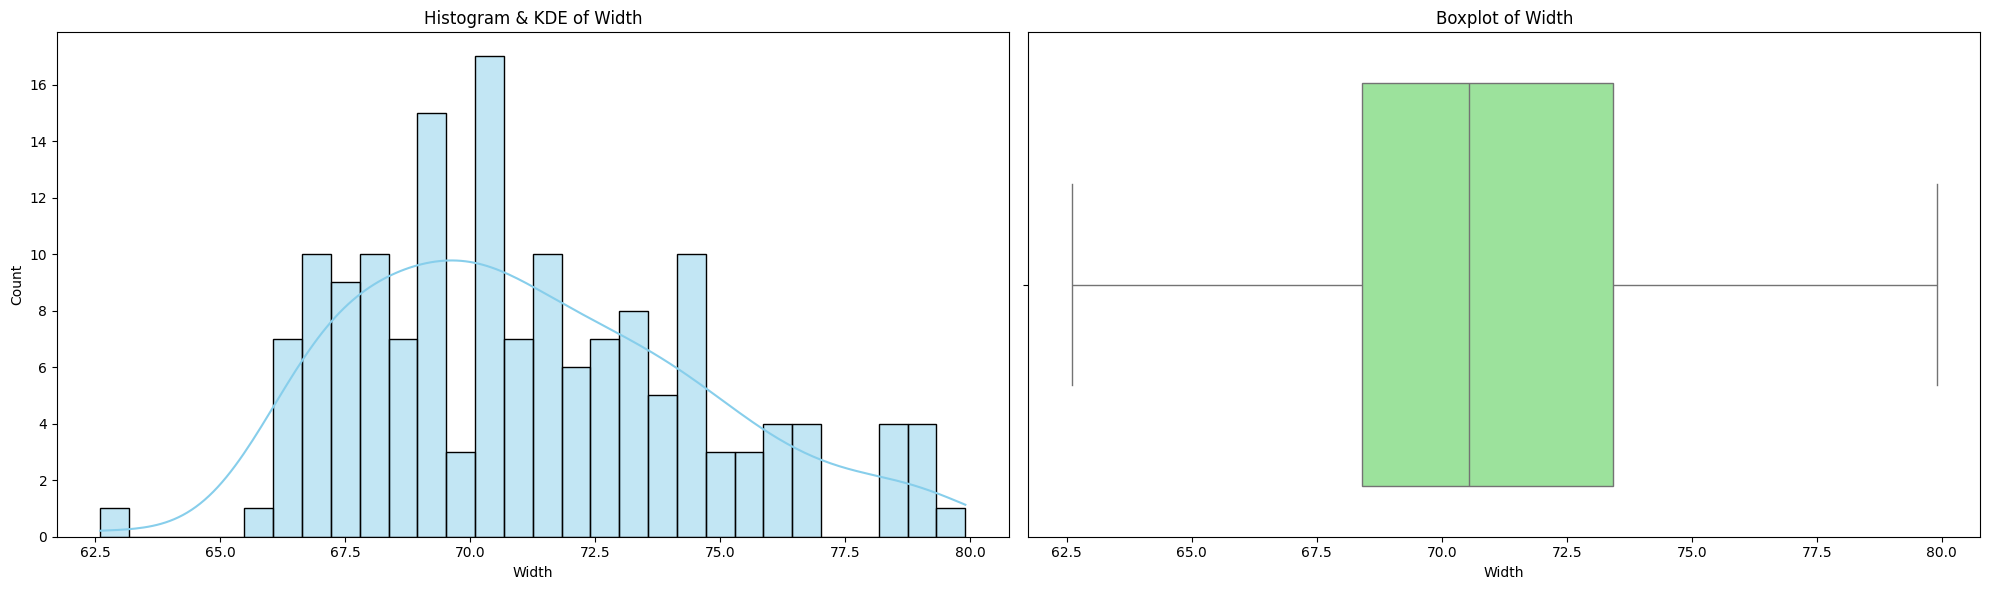


Column: Length
Skewness: -0.06
Approximately symmetric


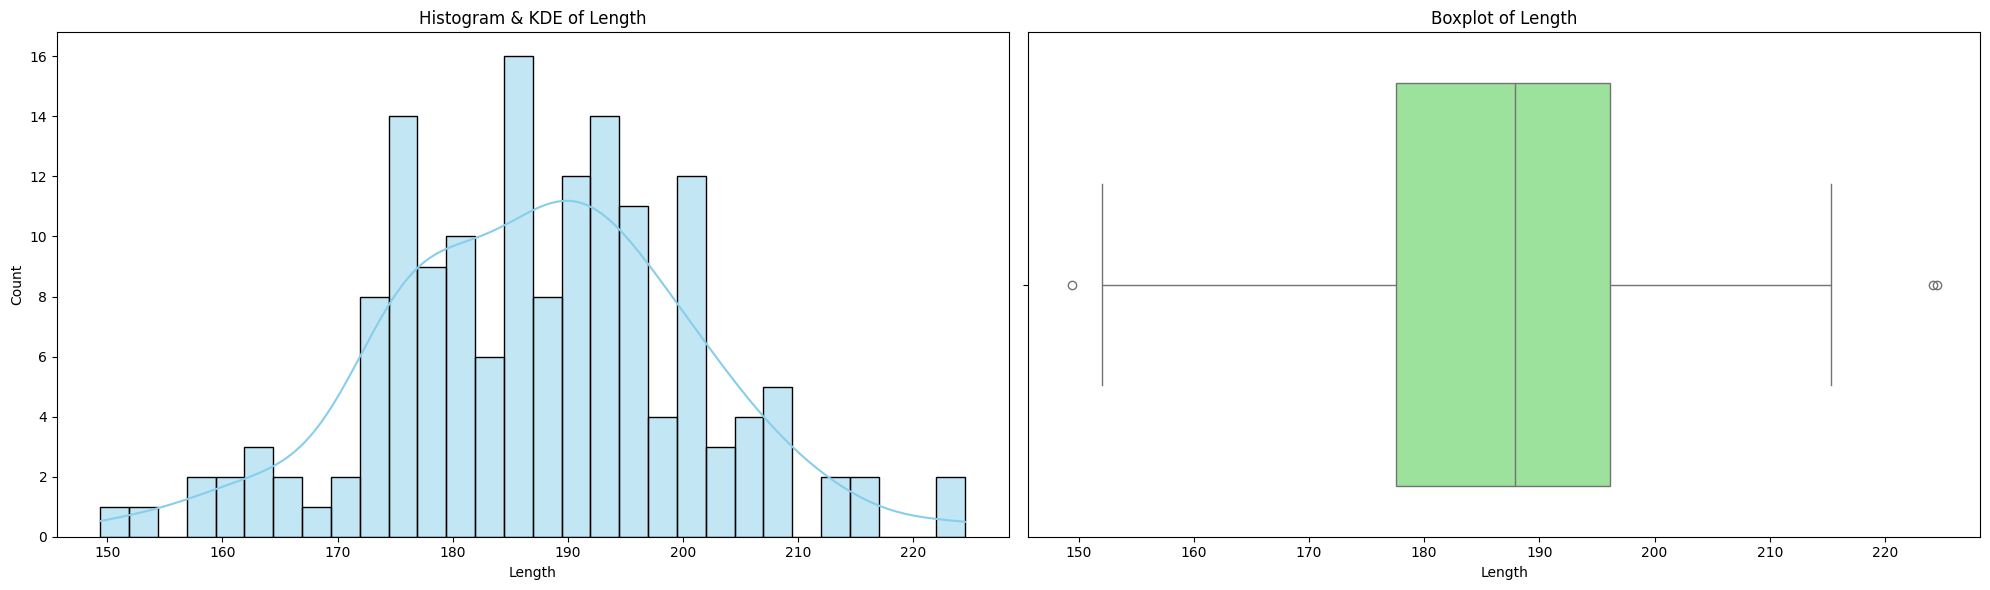


Column: Curb_weight
Skewness: 0.71
Moderately right-skewed


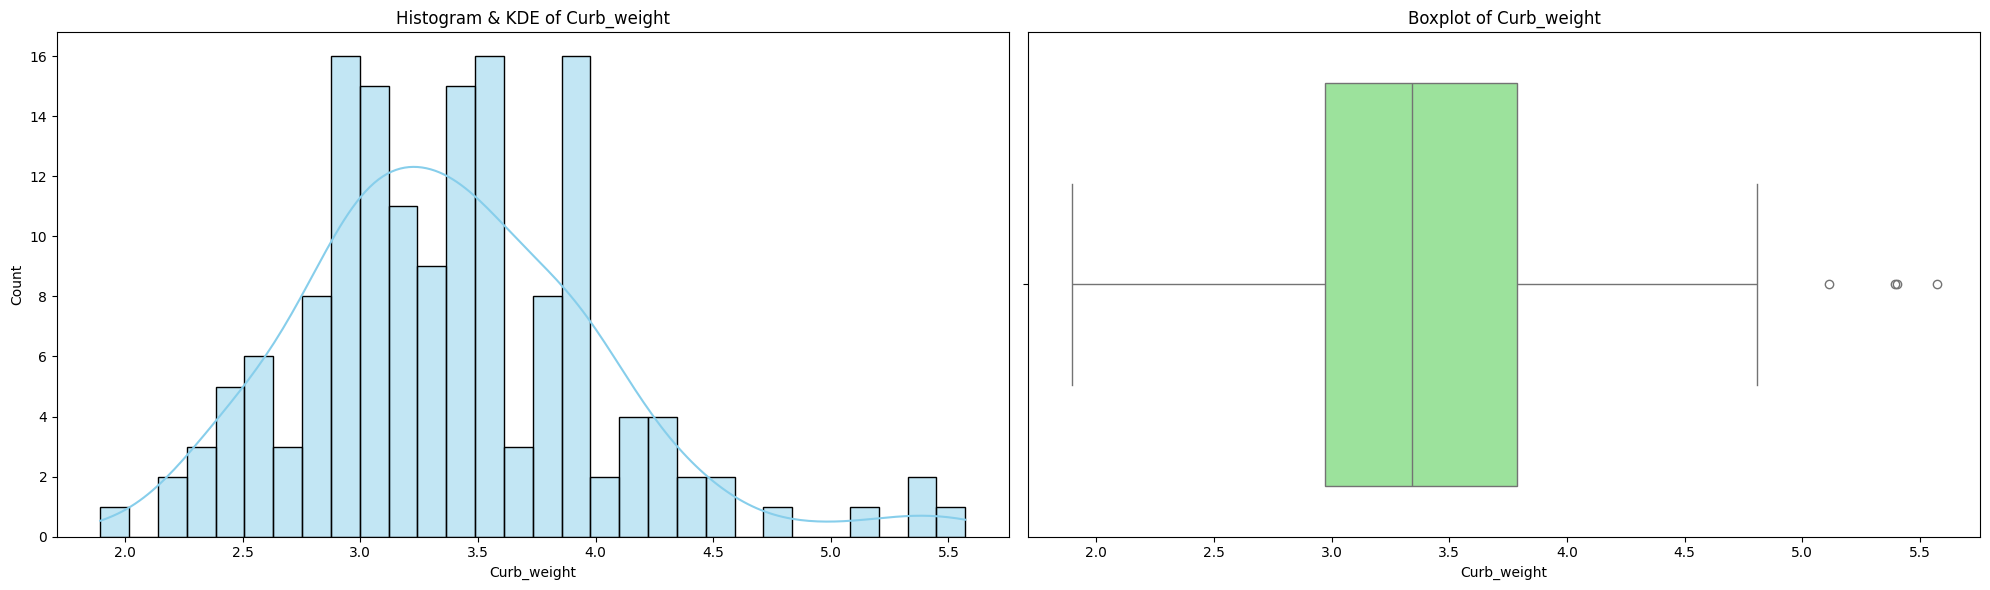


Column: Fuel_capacity
Skewness: 1.14
Highly right-skewed


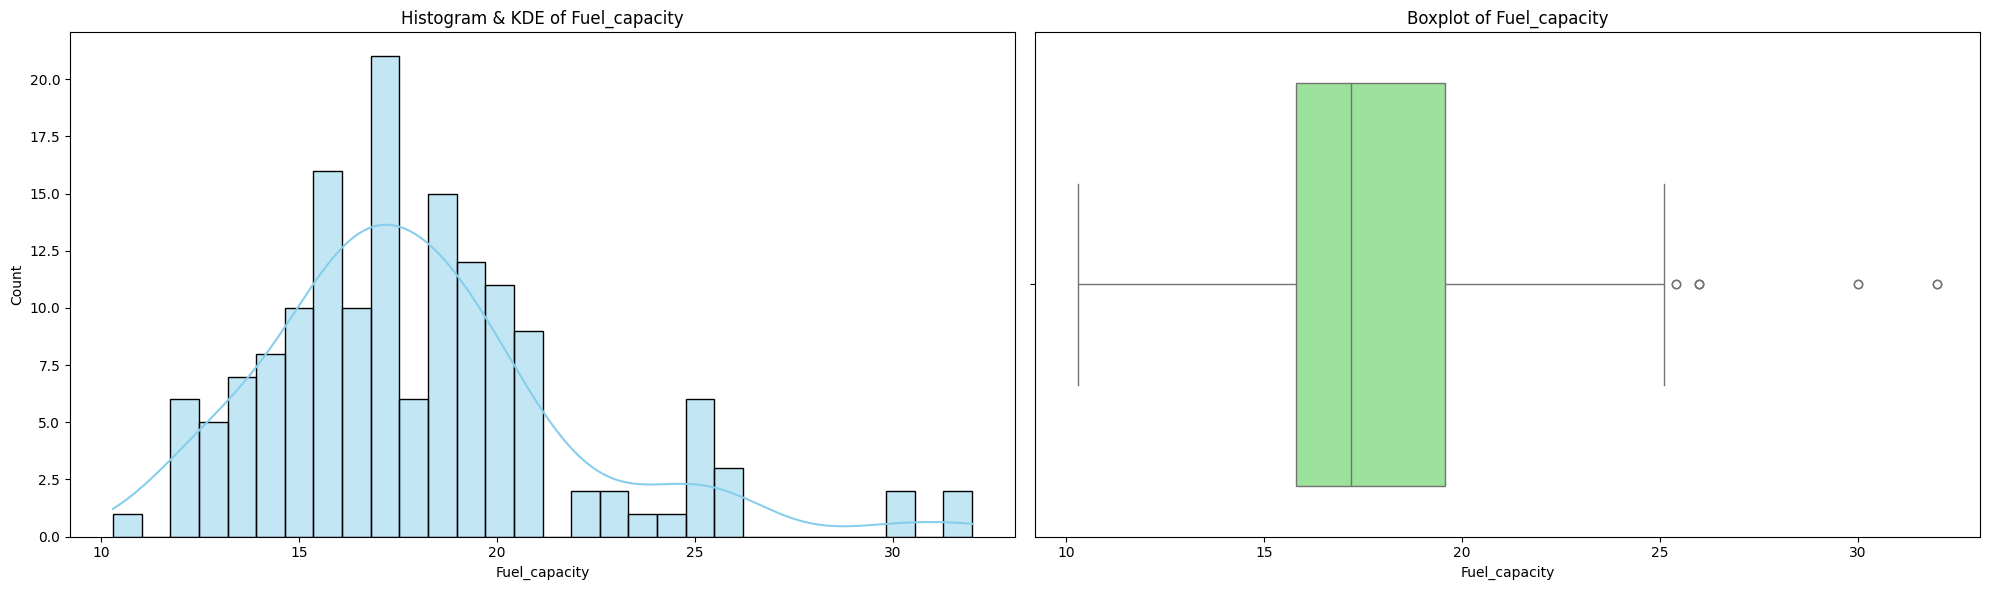


Column: Fuel_efficiency
Skewness: 0.70
Moderately right-skewed


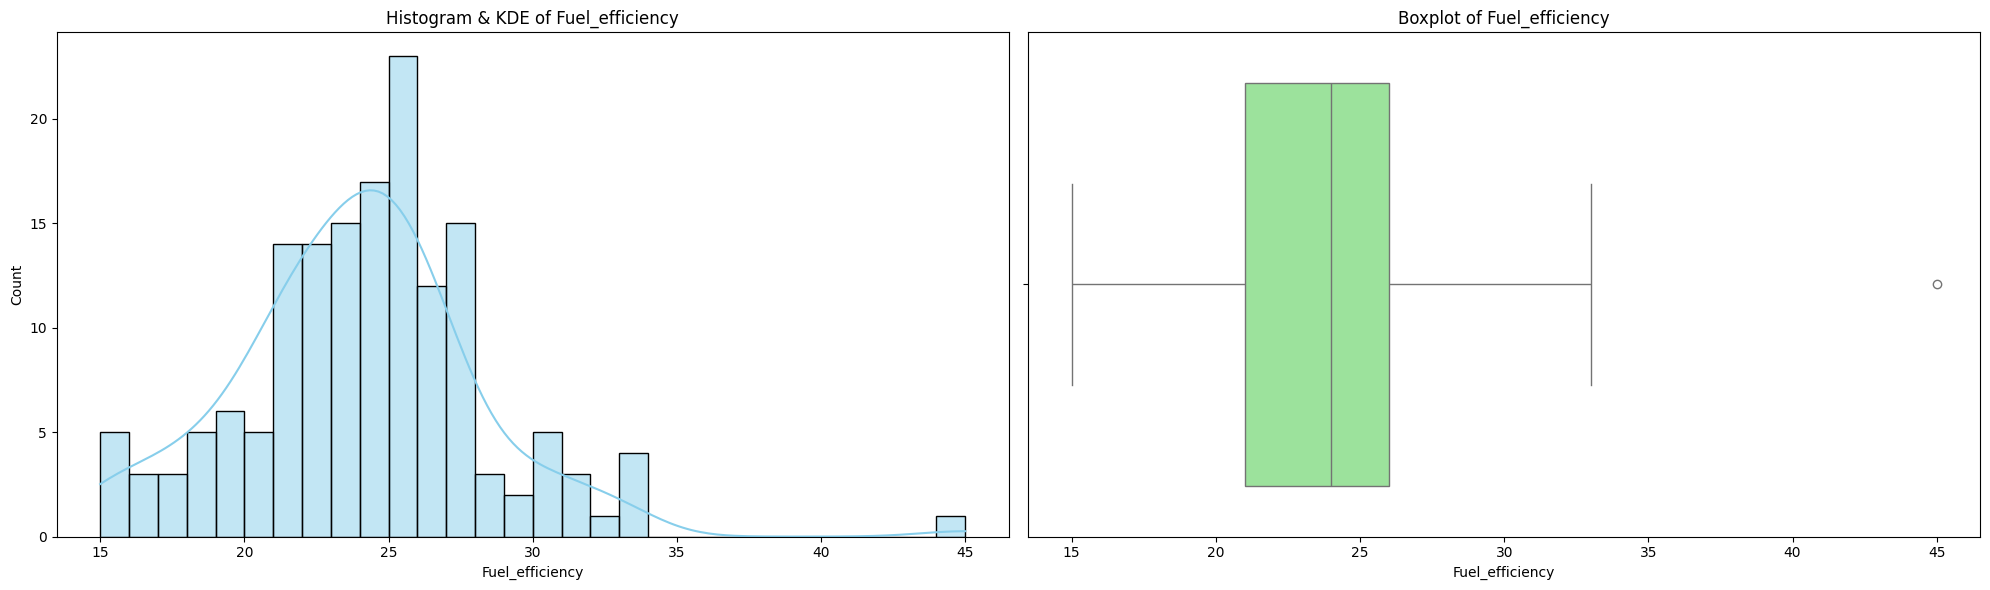


Column: Power_perf_factor
Skewness: 1.08
Highly right-skewed


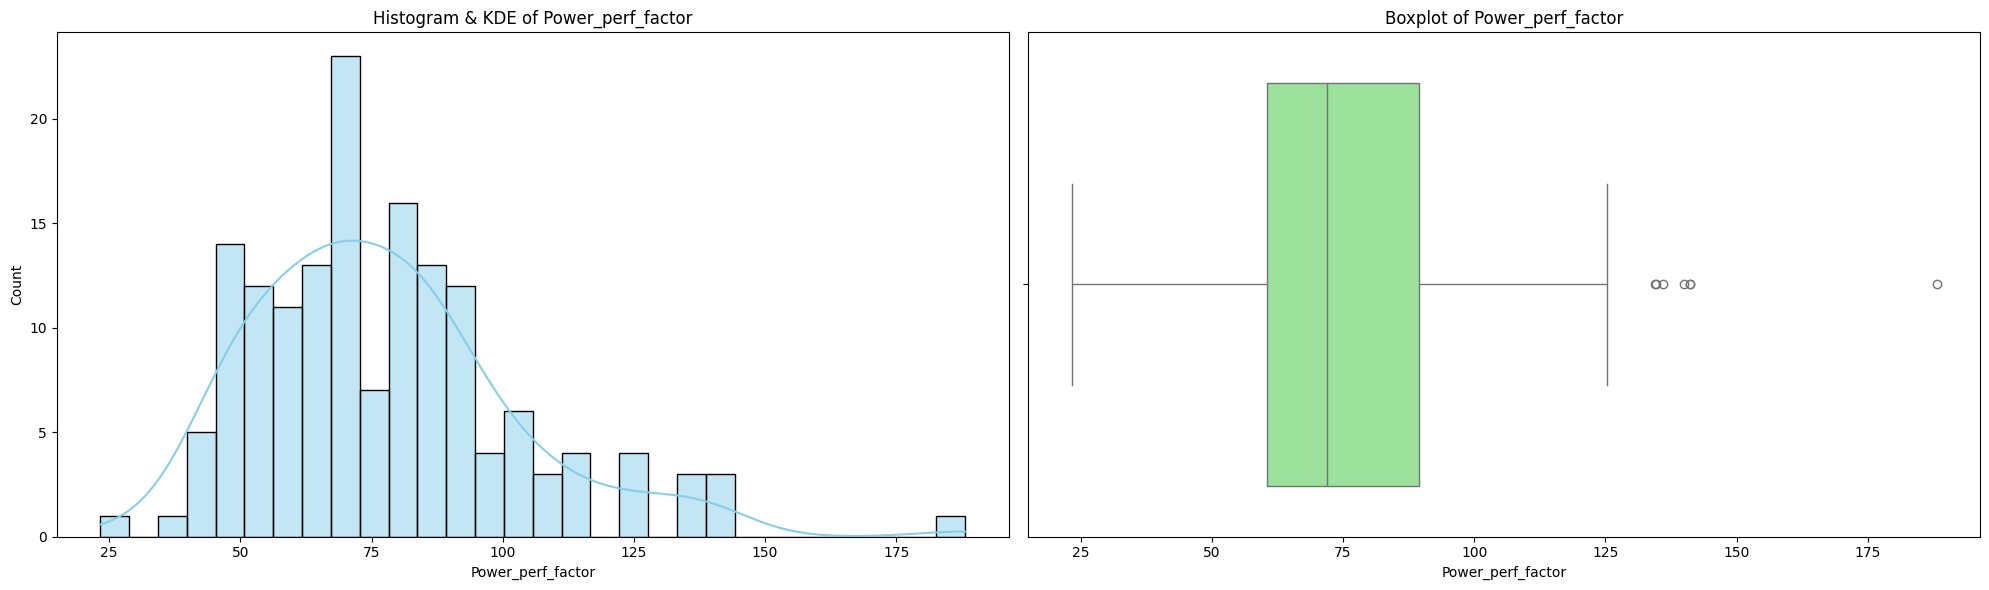

In [15]:
# Univariate Analysis - Numeric Features

numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    skewness = df[col].skew()
    print(f'\nColumn: {col}')
    print(f'Skewness: {skewness:.2f}')
    
    if skewness > 1:
        print('Highly right-skewed')
    elif skewness > 0.5:
        print('Moderately right-skewed')
    elif skewness < -1:
        print('Highly left-skewed')
    elif skewness < -0.5:
        print('Moderately left-skewed')
    else:
        print('Approximately symmetric')
    
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Histogram & KDE of {col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

In [16]:
all_performance = ['Engine_size', 'Horsepower', 'Fuel_efficiency']
all_design = ['Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity']

In [17]:
# Compute Depreciation 

df['Depreciation_Percentage'] = ((df['Price_in_thousands'] - df['Year_resale_value']) / df['Price_in_thousands']) * 100
df['Retention_Ratio'] = df['Year_resale_value'] / df['Price_in_thousands']
avg_dep = df['Depreciation_Percentage'].mean()
print(f'Average Depreciation: {avg_dep:.1f}%')

Average Depreciation: 31.4%



Column: Manufacturer (Unique values: 30)


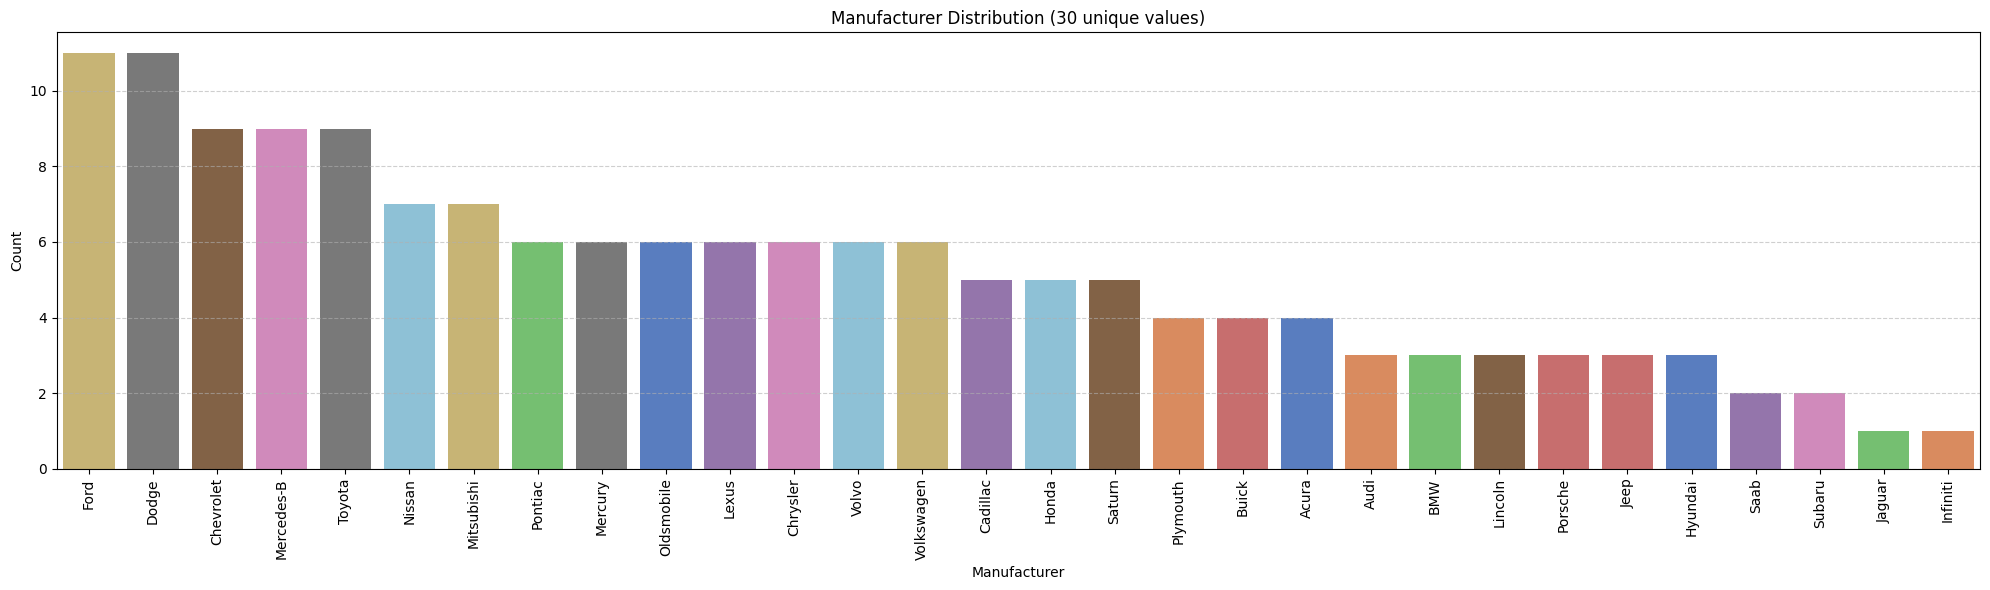


Column: Model (Unique values: 155)


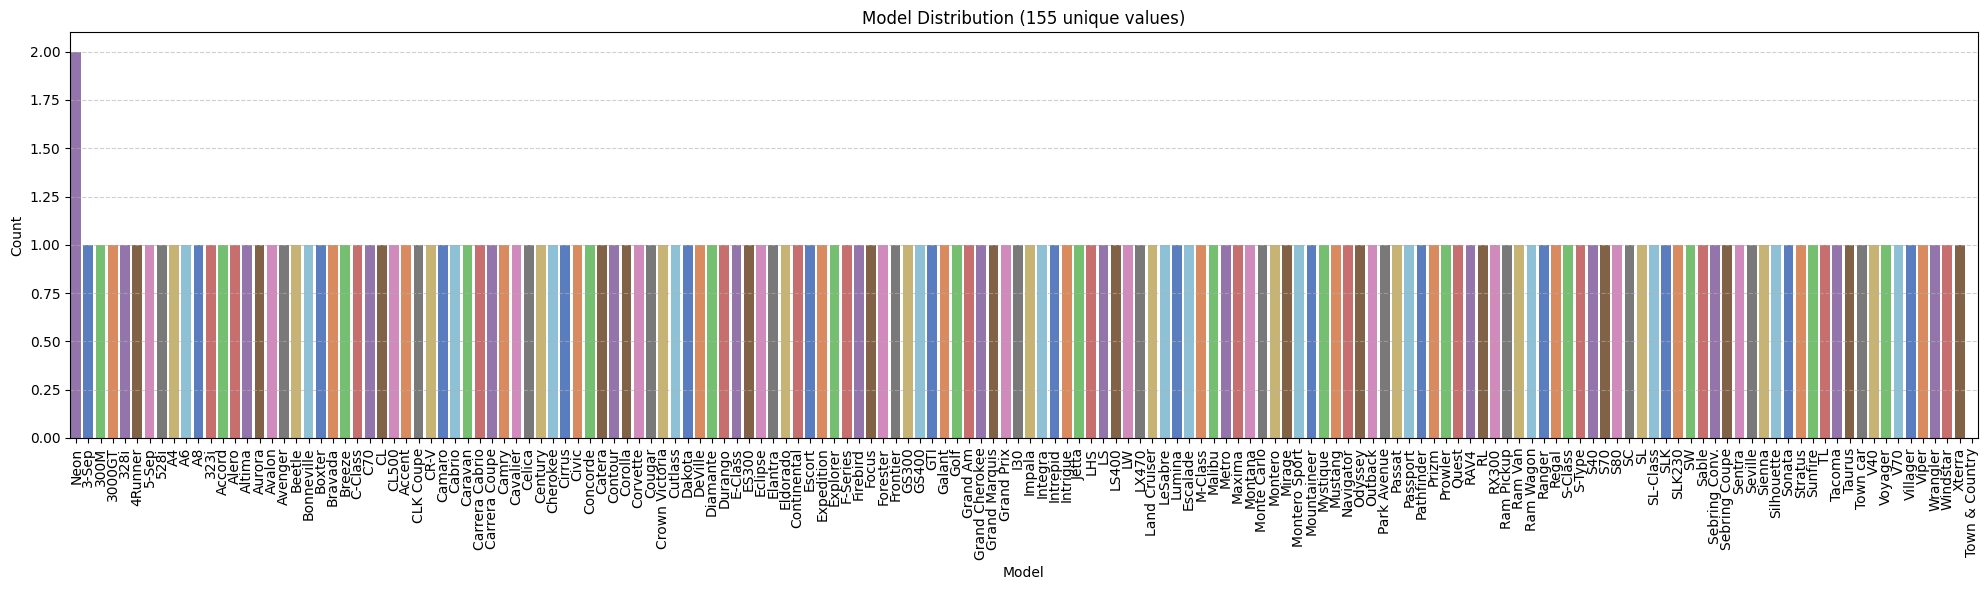


Column: Vehicle_type (Unique values: 2)


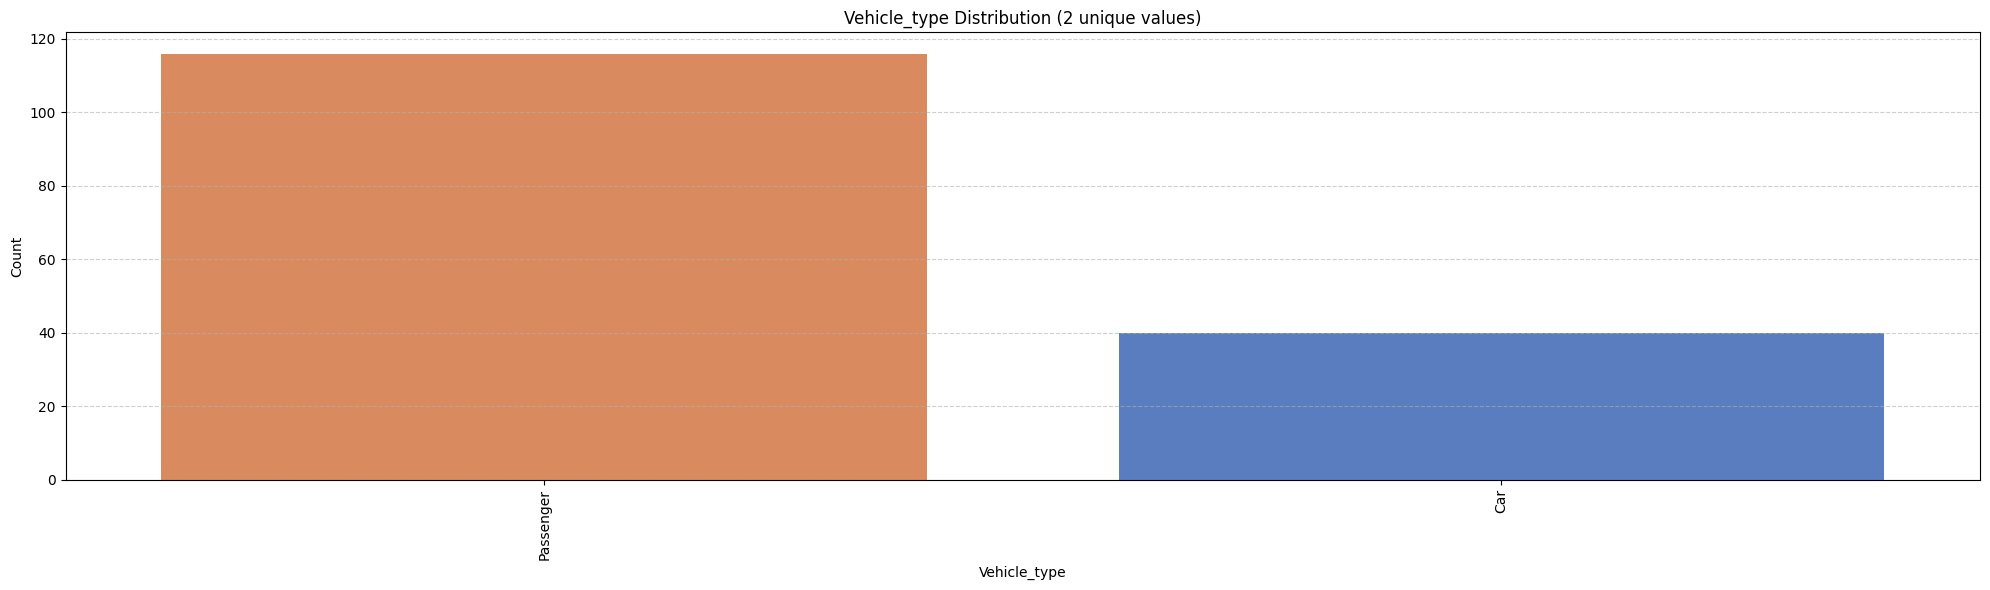

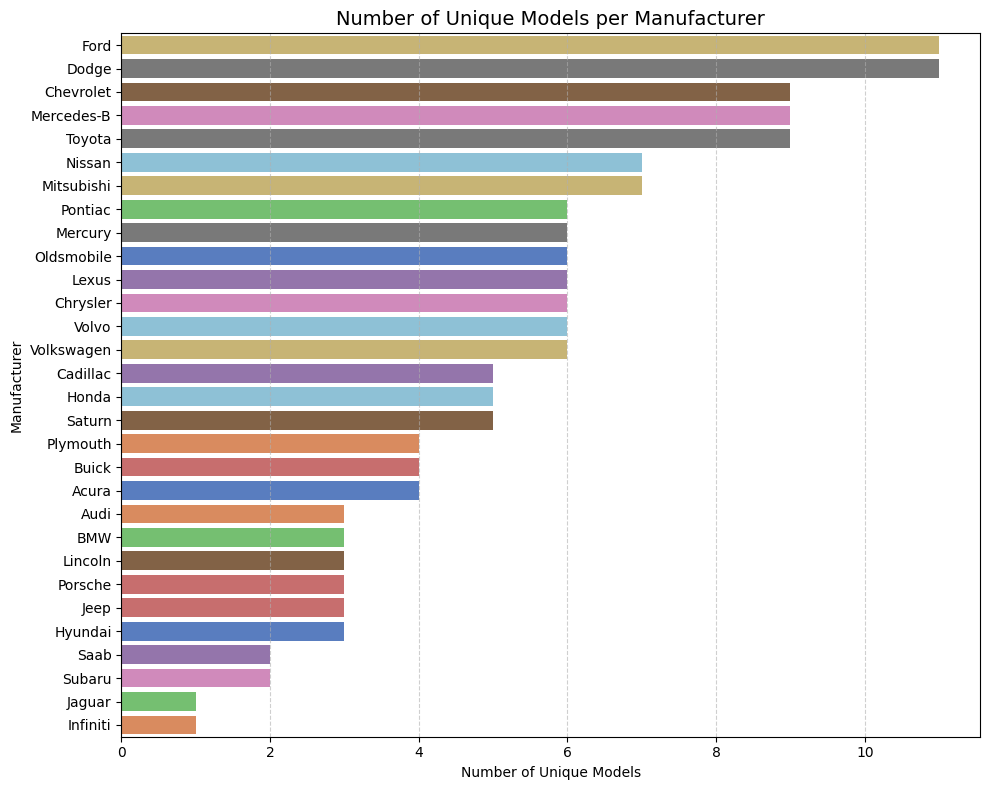

In [18]:
# Univariate Analysis - Categorical Features

cat_cols = df.select_dtypes(include=['category']).columns

for col in cat_cols:
    unique_count = df[col].nunique()
    print(f'\nColumn: {col} (Unique values: {unique_count})')
    plt.figure(figsize=(20,6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='muted', hue=col, dodge=False)
    plt.title(f'{col} Distribution ({unique_count} unique values)')
    plt.xticks(rotation=90)
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Number of models per manufacturer

models_per_manufacturer = df.groupby('Manufacturer', observed=True)['Model'].nunique().sort_values(ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(y=models_per_manufacturer.index, x=models_per_manufacturer.values, hue=models_per_manufacturer.index,
            order=models_per_manufacturer.index, palette='muted', legend=False, dodge=False)

plt.title('Number of Unique Models per Manufacturer', fontsize=14)
plt.xlabel('Number of Unique Models')
plt.ylabel('Manufacturer')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Price Analysis

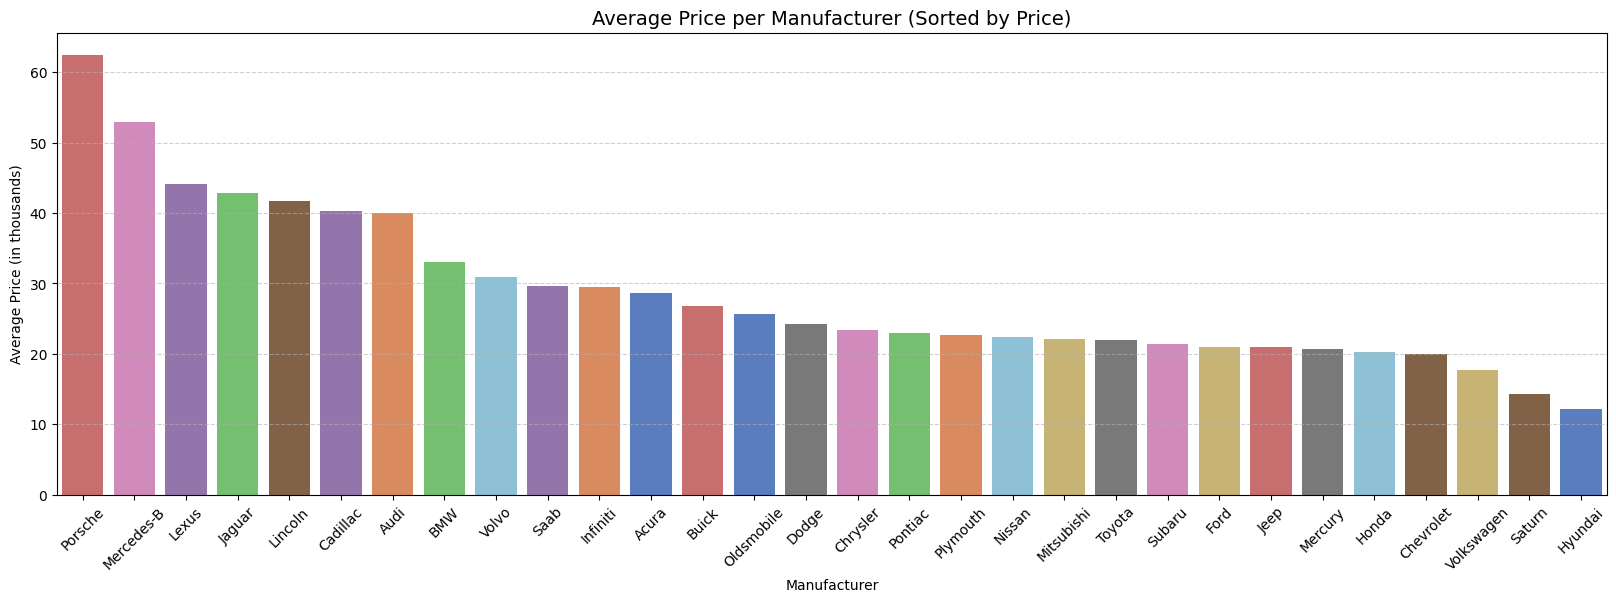

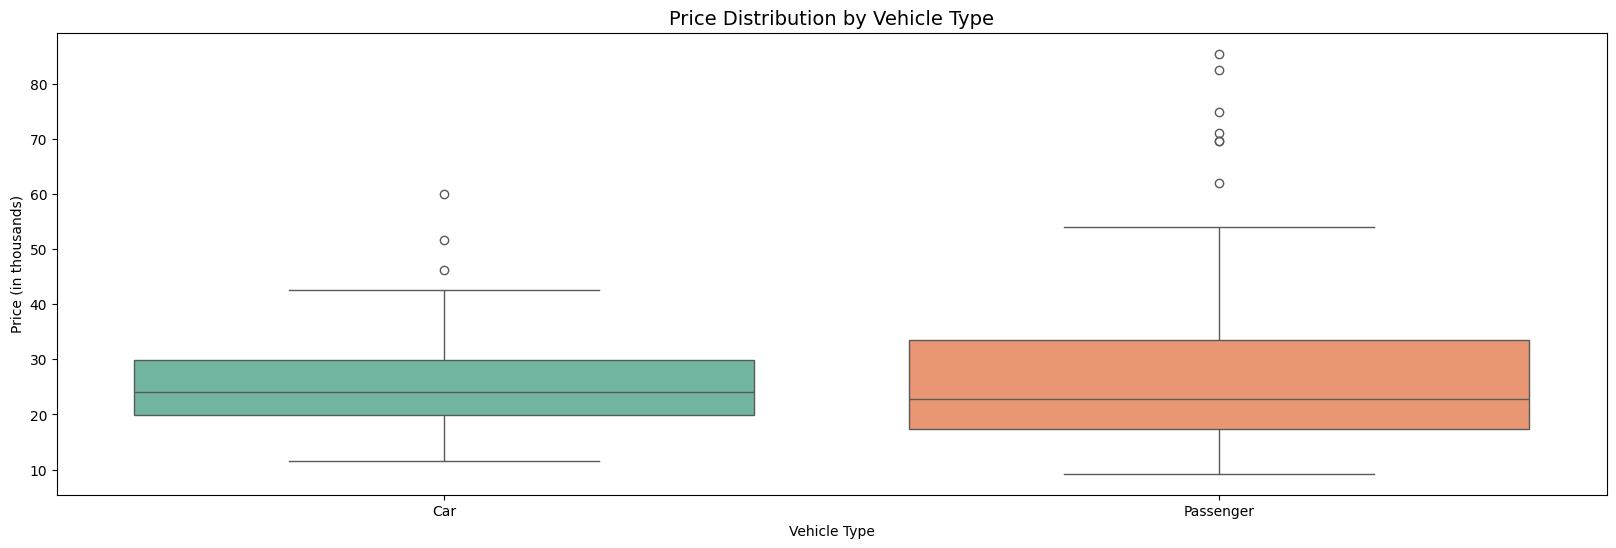

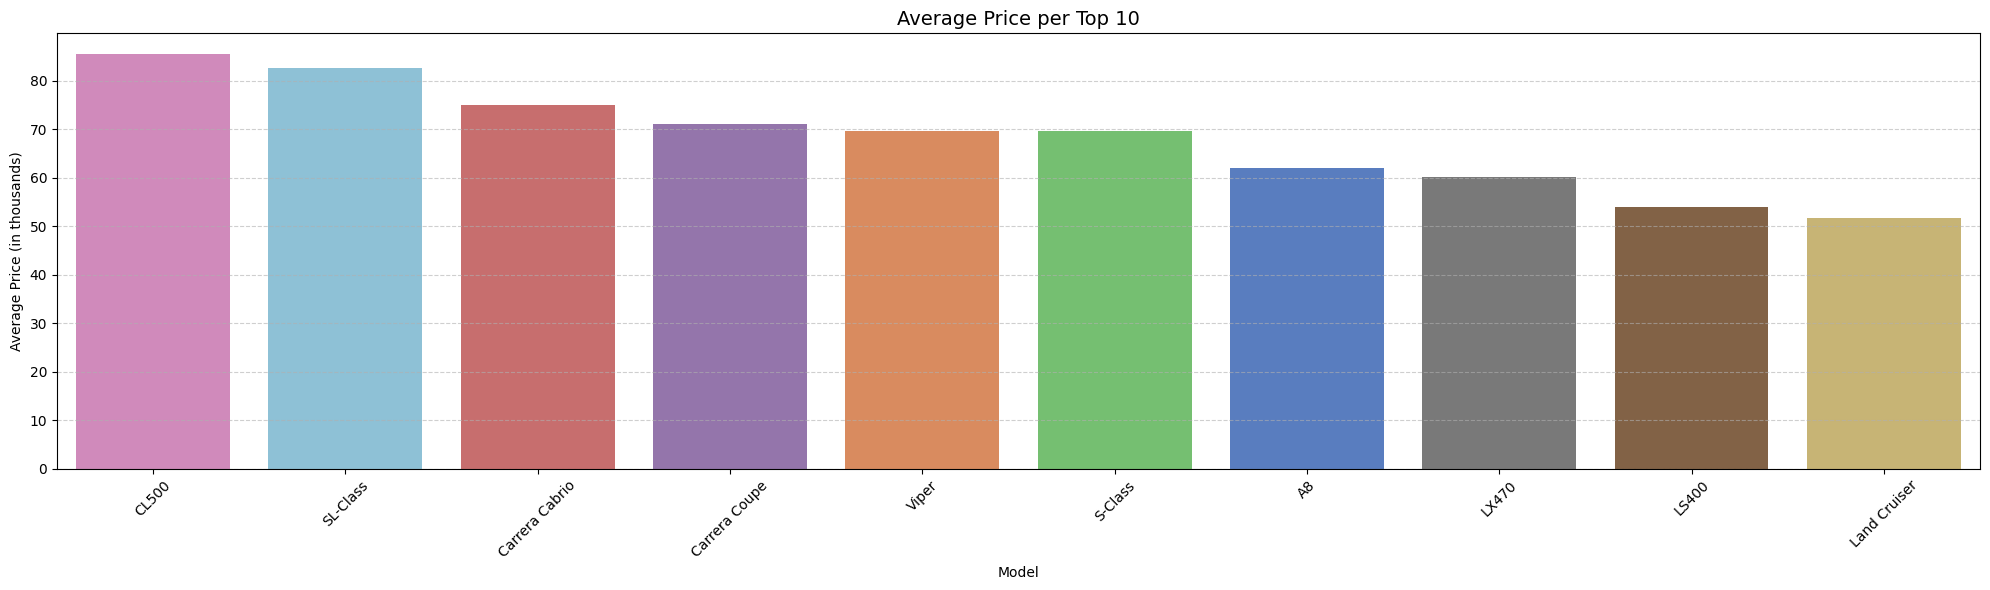

In [19]:
# Which manufacturer commands the highest average selling price?

manufacturer_price_df = (df.groupby('Manufacturer', observed=True)['Price_in_thousands']
                         .mean().sort_values(ascending=False).reset_index())

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_price_df['Manufacturer']

plt.figure(figsize=(20,6))
sns.barplot(data=manufacturer_price_df, x='Manufacturer', y='Price_in_thousands', order=manufacturer_order_list,
            hue='Manufacturer', legend=False, palette='muted',dodge=False)

plt.xticks(rotation=45)
plt.title('Average Price per Manufacturer (Sorted by Price)', fontsize=14)
plt.xlabel('Manufacturer')
plt.ylabel('Average Price (in thousands)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Which vehicle type tend to be more expensive or have wider price variability?

plt.figure(figsize=(20,6))
sns.boxplot(data=df, x='Vehicle_type', y='Price_in_thousands', hue='Vehicle_type', palette='Set2')
plt.title('Price Distribution by Vehicle Type', fontsize=14)
plt.xlabel('Vehicle Type')
plt.ylabel('Price (in thousands)')
plt.show()

# TOP models which commands the highest average selling price?

TOP_N_MODELS = 10

model_price_df = (df.groupby('Model', observed=True)['Price_in_thousands']
                  .mean().sort_values(ascending=False).reset_index())
top_models_df = model_price_df.head(TOP_N_MODELS)
model_order_list = top_models_df['Model']

plt.figure(figsize=(20,6))
sns.barplot(data=top_models_df, x='Model', y='Price_in_thousands', hue='Model', 
            order=model_order_list, palette='muted', dodge=False)

plt.xticks(rotation=45)
plt.title(f'Average Price per Top {TOP_N_MODELS}', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Average Price (in thousands)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



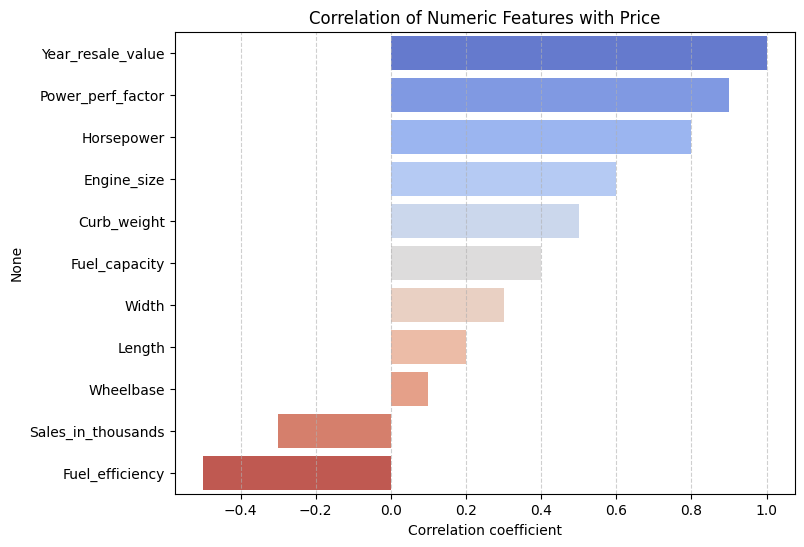

-- Selected price-driving features: ['Year_resale_value', 'Engine_size', 'Horsepower', 'Power_perf_factor']


In [20]:
# Which car features most strongly influence price?

corr_matrix = df[numeric_cols].corr().round(1)

# Extract correlations with Price
price_corr = corr_matrix["Price_in_thousands"].drop("Price_in_thousands")
price_corr_sorted = price_corr.sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=price_corr_sorted.values, y=price_corr_sorted.index, hue=price_corr_sorted.index, palette="coolwarm")
plt.title("Correlation of Numeric Features with Price")
plt.xlabel("Correlation coefficient")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()

# Select features with |correlation| >= 0.6
selected_price_features = price_corr[price_corr.abs() >= 0.6].index.tolist()
print("-- Selected price-driving features:", selected_price_features)

Performance features influencing price: ['Engine_size', 'Horsepower']


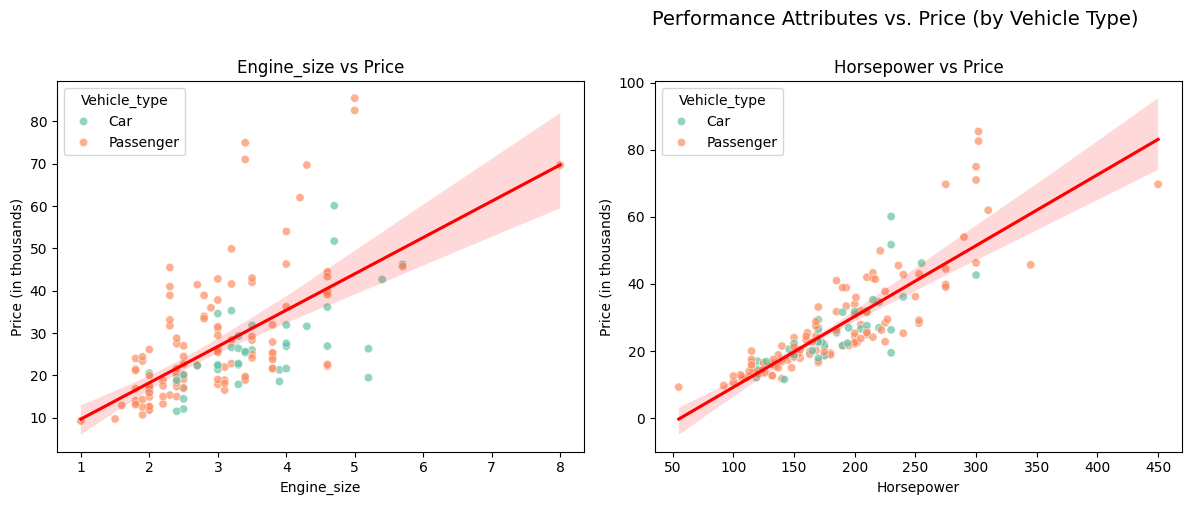

Design features influencing price: []
No strongly correlated design features found — skipping design plots.


In [21]:
# Do more powerful cars command higher prices?

# Performance Attributes vs Price 

performance_price = [f for f in all_performance if f in selected_price_features]
print("Performance features influencing price:", performance_price)

if len(performance_price) > 0:
    n_perf = len(performance_price)
    n_cols = 3
    n_rows = (n_perf + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()

    idx = 0
    for feature in performance_price:
        sns.scatterplot(data=df, x=feature, y='Price_in_thousands', hue='Vehicle_type',
                        alpha=0.7, palette='Set2', ax=axes[idx])
        sns.regplot(data=df, x=feature, y='Price_in_thousands',
                    scatter=False, color='red', ax=axes[idx])
        axes[idx].set_title(f"{feature} vs Price", fontsize=12)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Price (in thousands)')
        idx += 1

    # Remove unused subplots
    while idx < len(axes):
        fig.delaxes(axes[idx])
        idx += 1

    plt.suptitle('Performance Attributes vs. Price (by Vehicle Type)', fontsize=14, y=1)
    plt.tight_layout()
    plt.show()
else:
    print("No strongly correlated performance features found — skipping performance plots.")

# Design Attributes vs Price

design_price = [f for f in all_design if f in selected_price_features]
print("Design features influencing price:", design_price)

if len(design_price) > 0:
    n_design = len(design_price)
    n_cols = 3
    n_rows = (n_design + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()

    idx = 0
    for feature in design_price:
        sns.scatterplot(data=df, x=feature, y='Price_in_thousands', hue='Vehicle_type',
                        alpha=0.7, palette='Set2', ax=axes[idx])
        sns.regplot(data=df, x=feature, y='Price_in_thousands',
                    scatter=False, color='red', ax=axes[idx])
        axes[idx].set_title(f'{feature} vs Price', fontsize=12)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Price (in thousands)')
        idx += 1

    # Remove unused subplots
    while idx < len(axes):
        fig.delaxes(axes[idx])
        idx += 1

    plt.suptitle('Design Attributes vs. Price (by Vehicle Type)', fontsize=14, y=1)
    plt.tight_layout()
    plt.show()
else:
    print("No strongly correlated design features found — skipping design plots.")

# Sales Analysis

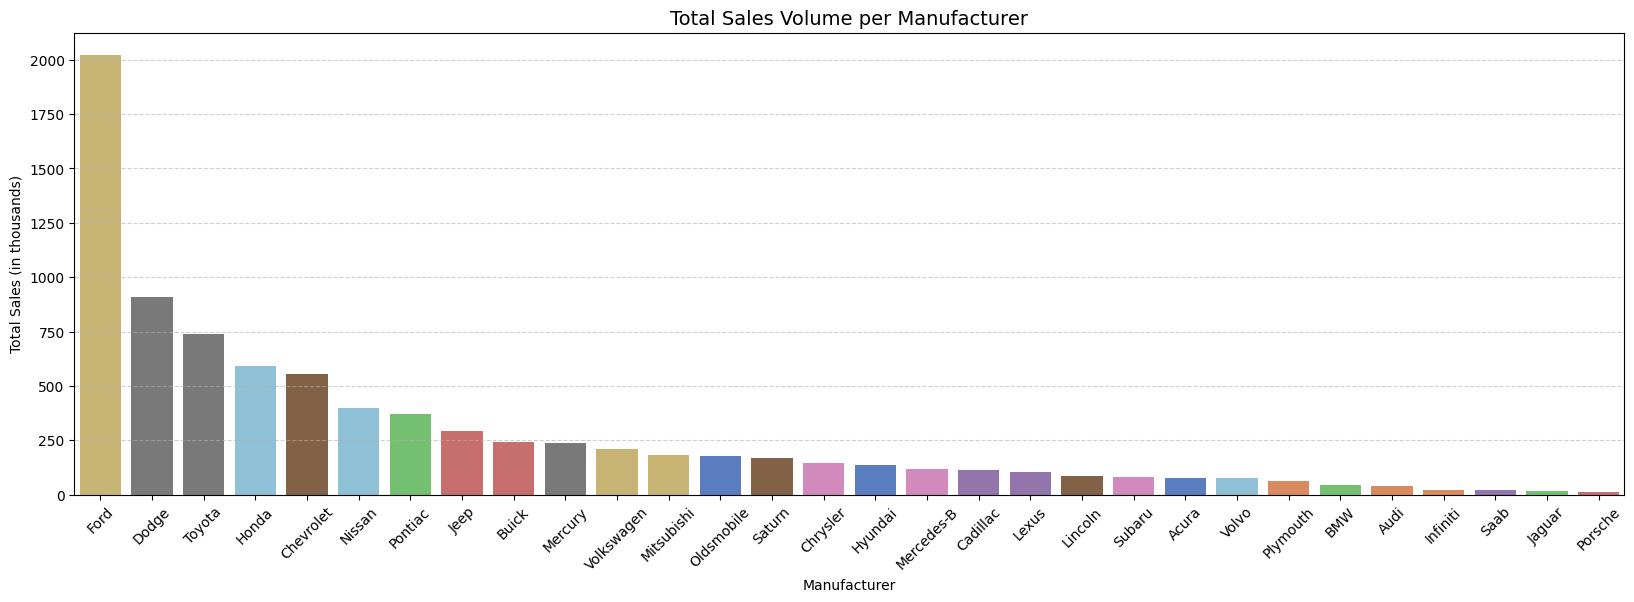

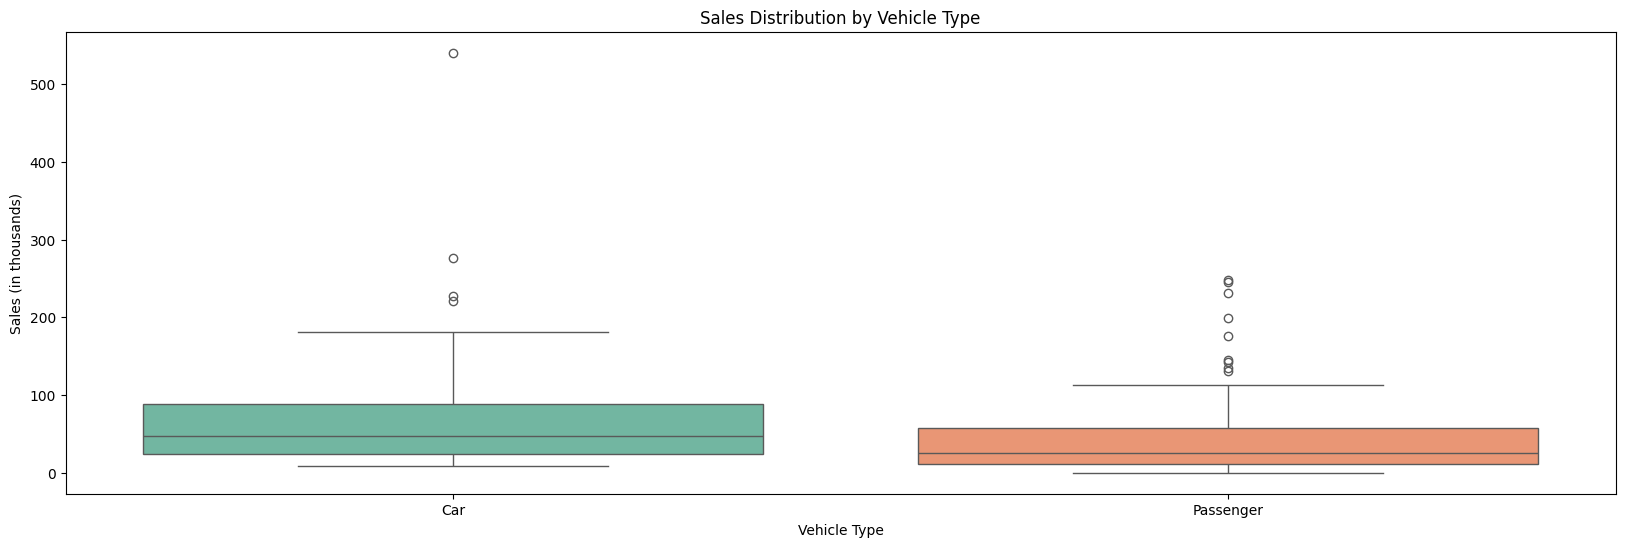

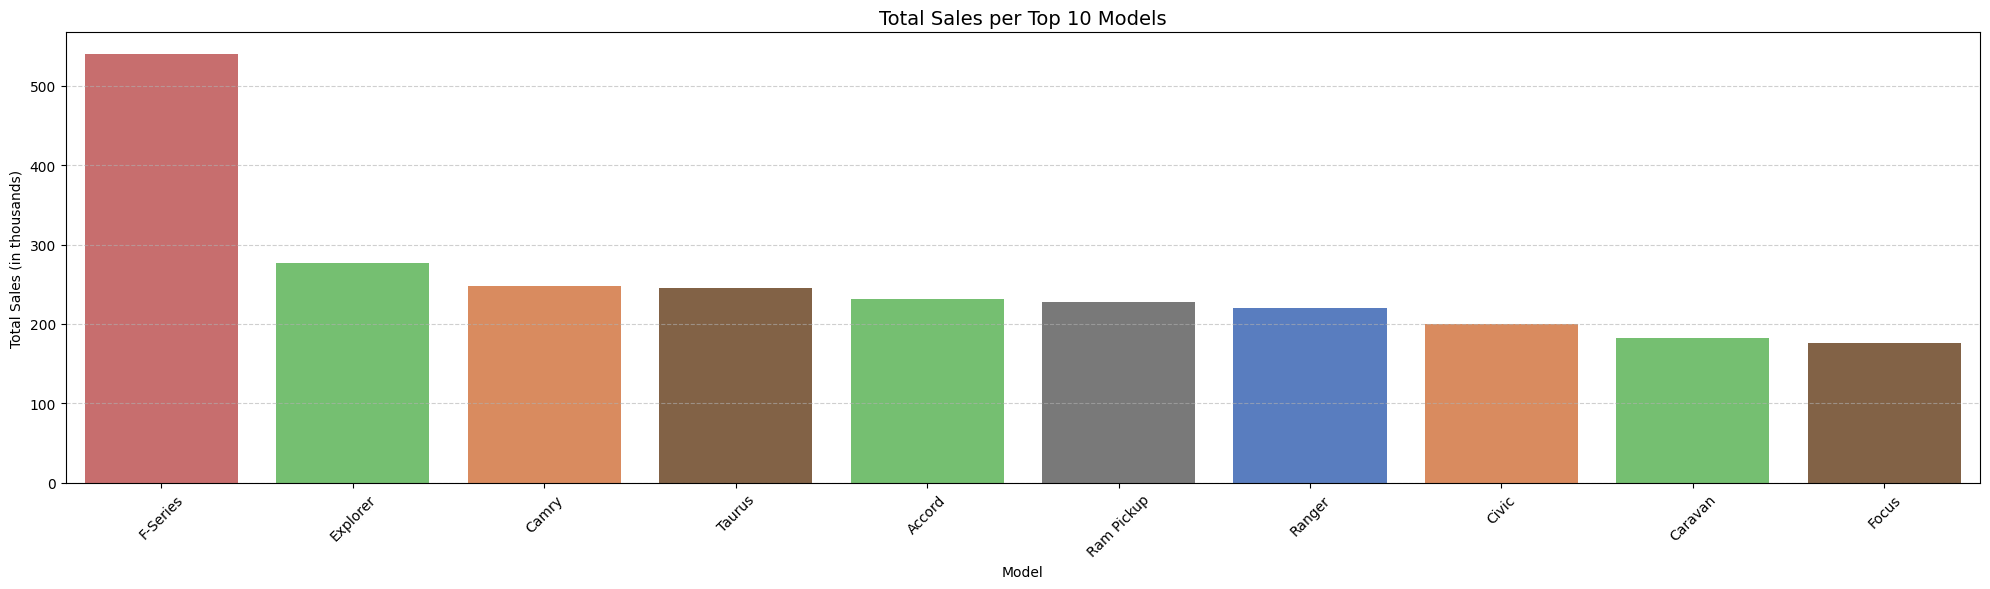

In [22]:
# Which car manufacturers dominate the sales volume?

plt.figure(figsize=(20,6))
manufacturer_sales_df = (df.groupby('Manufacturer', observed=True)['Sales_in_thousands'].sum().sort_values(ascending=False).reset_index())
manufacturer_order_list = manufacturer_sales_df['Manufacturer']
sns.barplot(data=manufacturer_sales_df, x='Manufacturer', y='Sales_in_thousands', order=manufacturer_order_list,
            hue='Manufacturer', legend=False, palette='muted', dodge=False)

plt.xticks(rotation=45)
plt.title('Total Sales Volume per Manufacturer', fontsize=14)
plt.xlabel('Manufacturer')
plt.ylabel('Total Sales (in thousands)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Which types of vehicles sell the most?

plt.figure(figsize=(20,6))
sns.boxplot(data=df, x='Vehicle_type', y='Sales_in_thousands', hue='Vehicle_type', palette='Set2')
plt.title('Sales Distribution by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Sales (in thousands)')
plt.show()

# Which TOP N model commands the highest sales?

TOP_N_MODELS = 10

model_sales_df = (df.groupby('Model', observed=True)['Sales_in_thousands']
                  .sum().sort_values(ascending=False).reset_index())
top_models_df = model_sales_df.head(TOP_N_MODELS)
model_order_list = top_models_df['Model']

plt.figure(figsize=(20,6))
sns.barplot(data=top_models_df, x='Model', y='Sales_in_thousands', hue='Model',
            order=model_order_list, palette='muted', dodge=False)

plt.xticks(rotation=45)
plt.title(f'Total Sales per Top {TOP_N_MODELS} Models', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Total Sales (in thousands)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

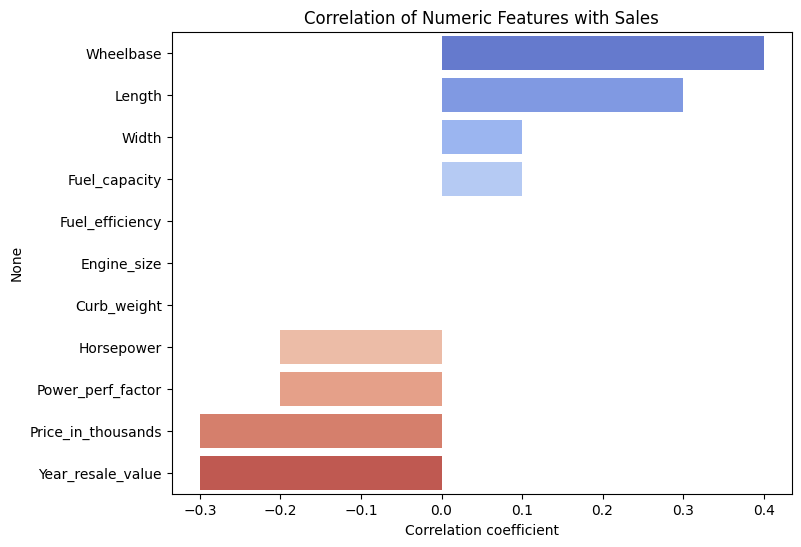

-- Selected sales-driving features: []


In [23]:
# Which car features most strongly influence sales?

corr_matrix = df[numeric_cols].corr().round(1)

# Extract correlations with Sales
sales_corr = corr_matrix["Sales_in_thousands"].drop("Sales_in_thousands")
sales_corr_sorted = sales_corr.sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=sales_corr_sorted.values, y=sales_corr_sorted.index, hue=sales_corr_sorted.index, palette="coolwarm")
plt.title("Correlation of Numeric Features with Sales")
plt.xlabel("Correlation coefficient")
plt.show()

# Select features with |correlation| >= 0.6
selected_sales_features = sales_corr[sales_corr.abs() >= 0.6].index.tolist()
print("-- Selected sales-driving features:", selected_sales_features)


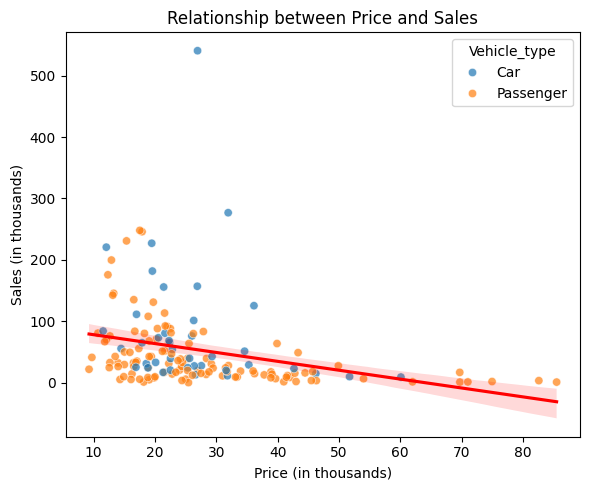

In [24]:
# How does car price influence sales volume?

plt.figure(figsize=(6, 5))
sns.scatterplot(data=df, x='Price_in_thousands', y='Sales_in_thousands', hue='Vehicle_type',alpha=0.7)
sns.regplot(data=df, x='Price_in_thousands', y='Sales_in_thousands', scatter=False, color='red')
plt.title('Relationship between Price and Sales')
plt.xlabel('Price (in thousands)')
plt.ylabel('Sales (in thousands)')
plt.tight_layout()
plt.show()

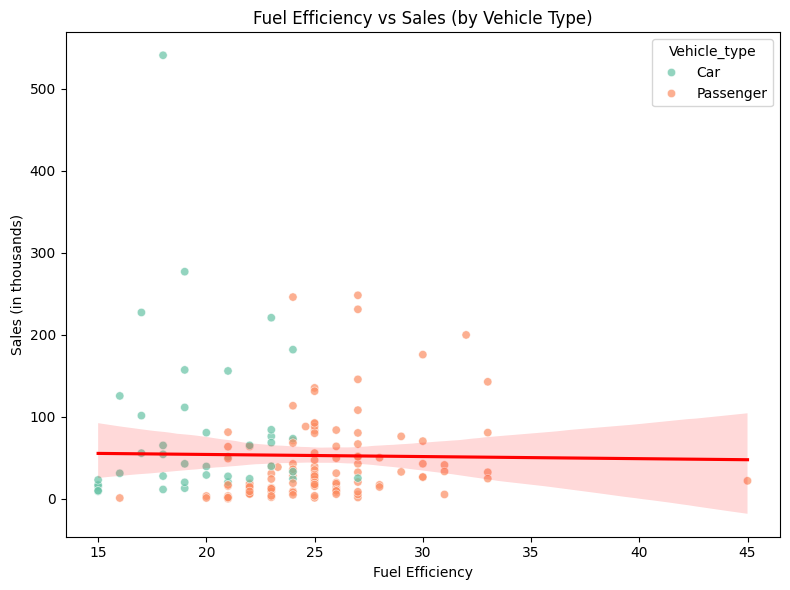

In [25]:
# Relationship Between Sales and Fuel Efficiency

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Fuel_efficiency', y='Sales_in_thousands', hue='Vehicle_type', alpha=0.7, palette='Set2')
sns.regplot(data=df, x='Fuel_efficiency', y='Sales_in_thousands', scatter=False, color='red')
plt.title('Fuel Efficiency vs Sales (by Vehicle Type)')
plt.xlabel('Fuel Efficiency')
plt.ylabel('Sales (in thousands)')
plt.tight_layout()
plt.show()

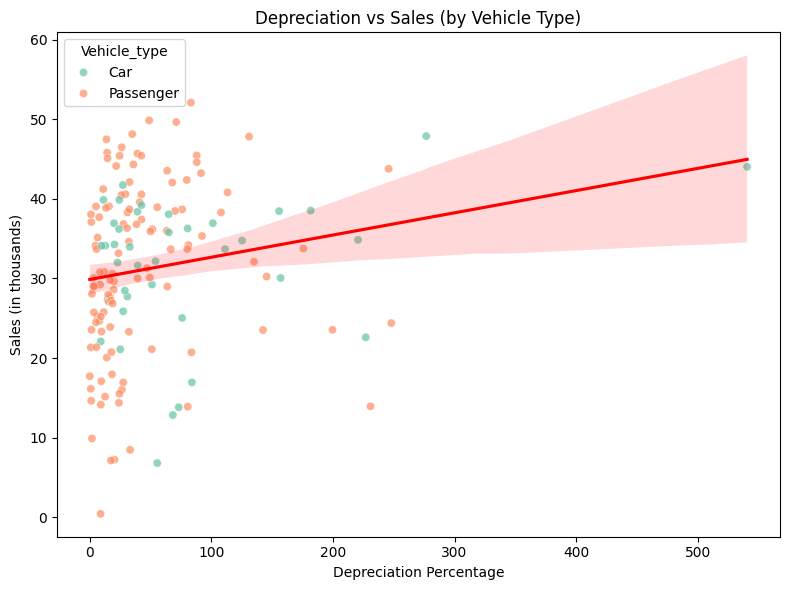

In [26]:
# Sales vs Depreciation

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Sales_in_thousands', y='Depreciation_Percentage', hue='Vehicle_type', alpha=0.7, palette='Set2')
sns.regplot(data=df, x='Sales_in_thousands', y='Depreciation_Percentage', scatter=False, color='red')
plt.title('Depreciation vs Sales (by Vehicle Type)')
plt.xlabel('Depreciation Percentage')
plt.ylabel('Sales (in thousands)')
plt.tight_layout()
plt.show()

# Resale Value Analysis

In [27]:
# Average Depreciation by vehicle type

type_summary = (df.groupby('Vehicle_type', observed=True)['Depreciation_Percentage'].mean().round(1))
print(type_summary)

Vehicle_type
Car          31.5
Passenger    31.3
Name: Depreciation_Percentage, dtype: float64


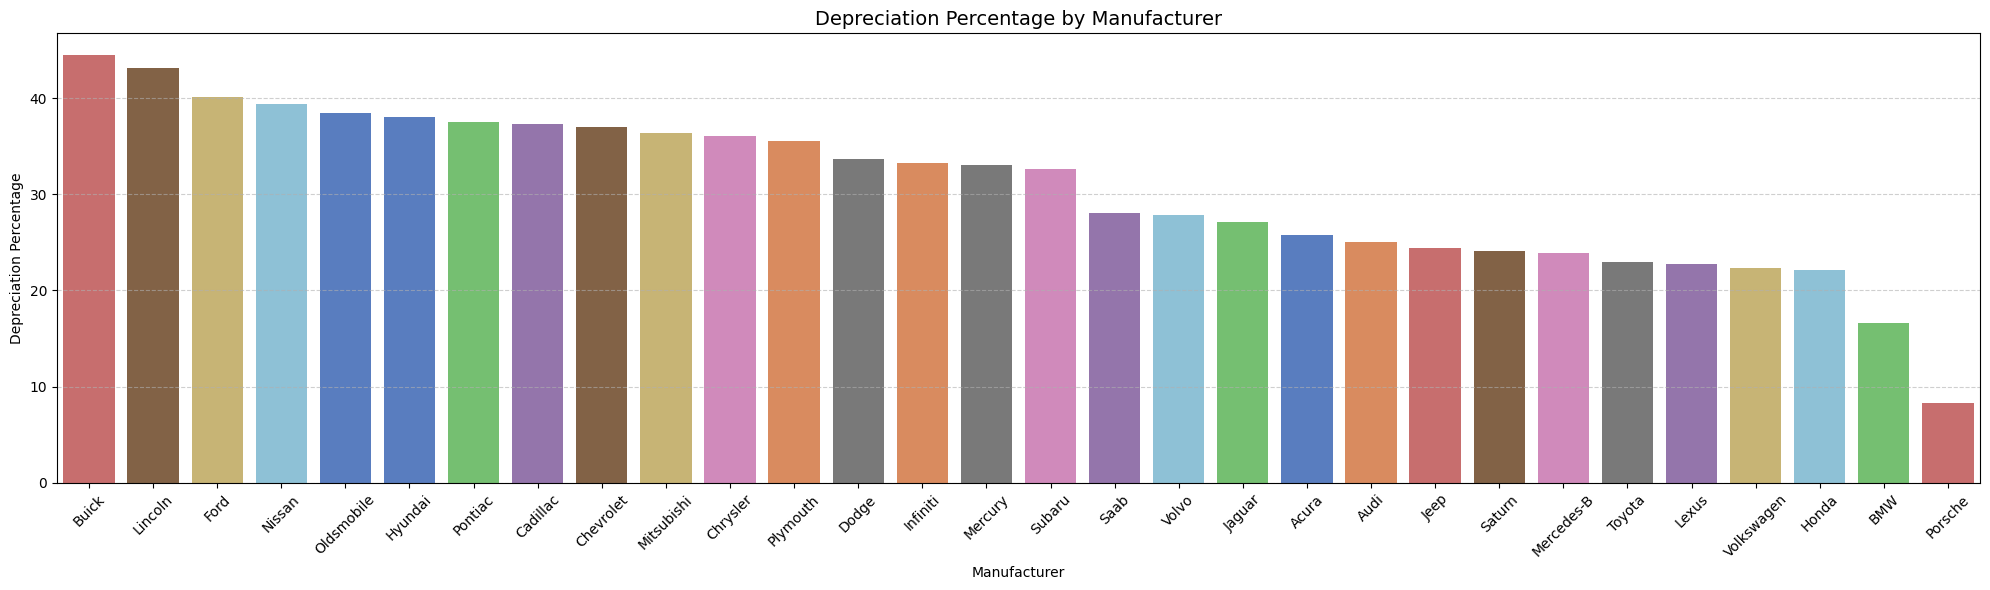

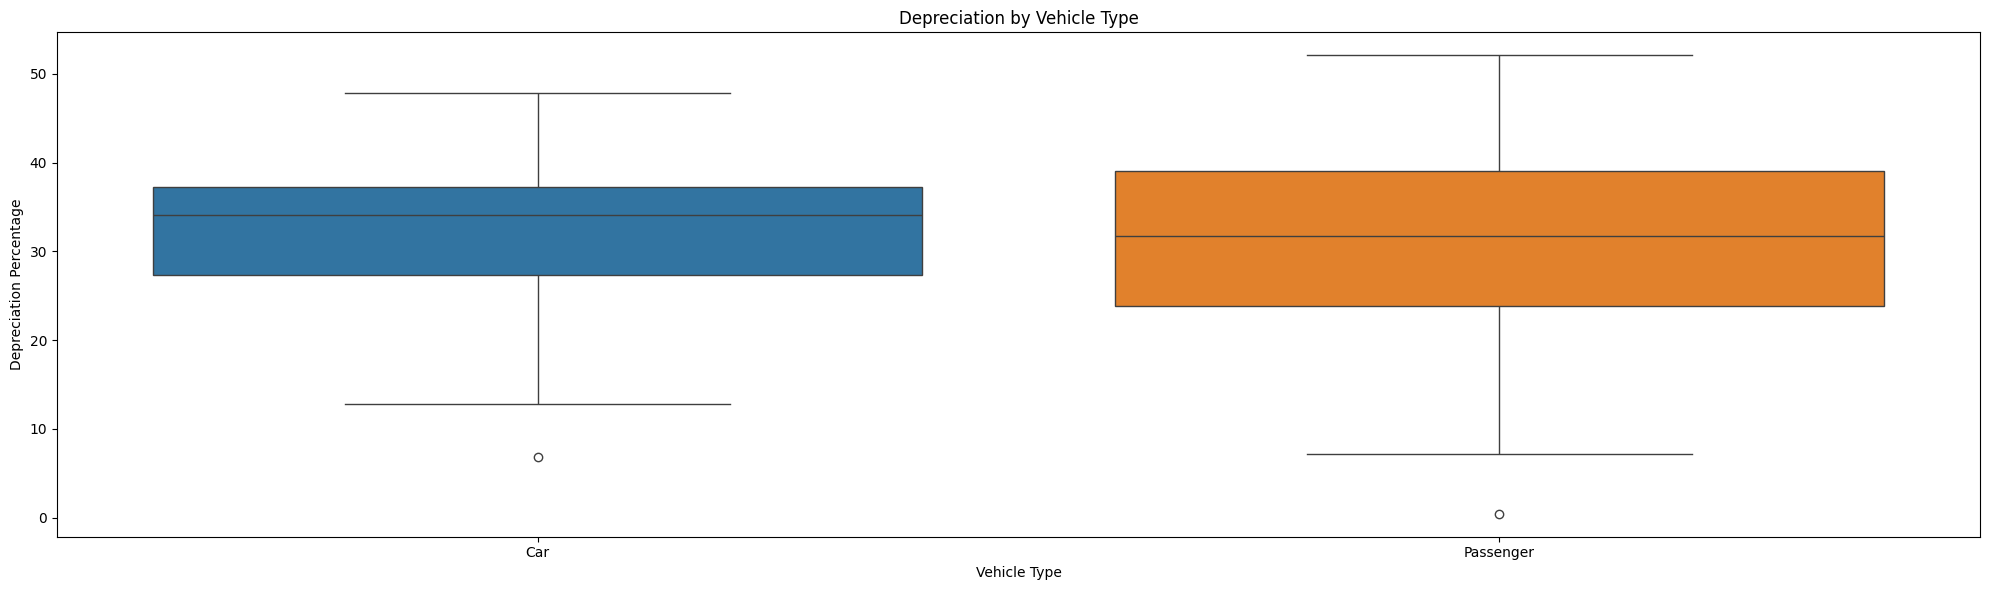

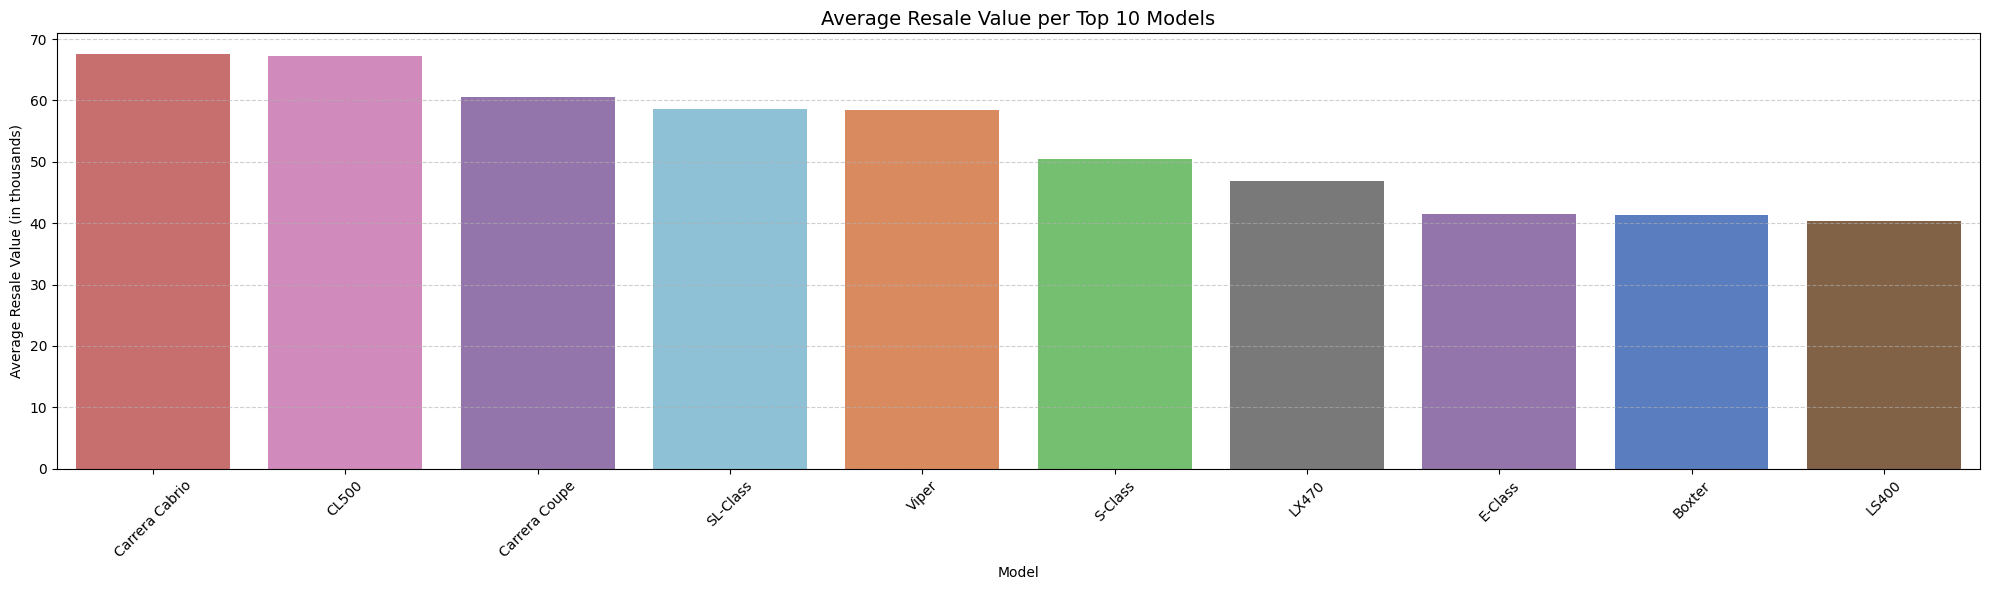

In [28]:
# Average Depreciation by Manufacturer

manufacturer_summary = (df.groupby('Manufacturer', observed=True)['Depreciation_Percentage'].mean().round(1).reset_index())
manufacturer_summary = manufacturer_summary.sort_values('Depreciation_Percentage', ascending=False)
manufacturer_order_list = manufacturer_summary['Manufacturer']

plt.figure(figsize=(20,6))
sns.barplot(data=manufacturer_summary, x='Manufacturer', y='Depreciation_Percentage', order=manufacturer_order_list,
            hue='Manufacturer', legend=False, palette='muted', dodge=False)

plt.xticks(rotation=45)
plt.title('Depreciation Percentage by Manufacturer', fontsize=14)
plt.xlabel('Manufacturer')
plt.ylabel('Depreciation Percentage')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#  Does vehicle type (Passenger vs Car) affect depreciation?

plt.figure(figsize=(20,6))
sns.boxplot(data=df, x='Vehicle_type', y='Depreciation_Percentage', hue='Vehicle_type')
plt.title('Depreciation by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Depreciation Percentage')
plt.tight_layout()
plt.show()

# Which TOP N model commands the highest resale values?

TOP_N_MODELS = 10

model_resale_df = (df.groupby('Model', observed=True)['Year_resale_value']
                   .mean().sort_values(ascending=False).reset_index())

top_models_df = model_resale_df.head(TOP_N_MODELS)
model_order_list = top_models_df['Model']

plt.figure(figsize=(20,6))
sns.barplot(data=top_models_df, x='Model', y='Year_resale_value', hue='Model',
            order=model_order_list, palette='muted', dodge=False)

plt.xticks(rotation=45)
plt.title(f'Average Resale Value per Top {TOP_N_MODELS} Models', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Average Resale Value (in thousands)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

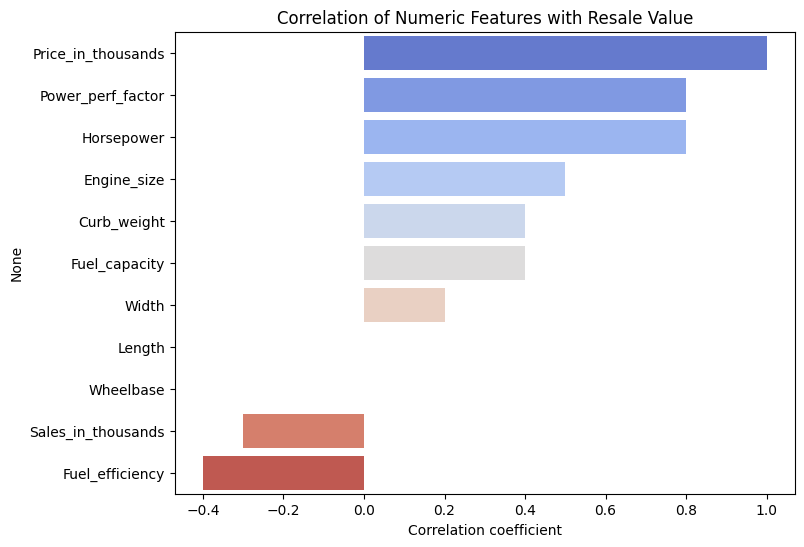

--Selected resale-driving features: ['Price_in_thousands', 'Horsepower', 'Power_perf_factor']


In [29]:
# Which factors influence car resale value?

corr_matrix = df[numeric_cols].corr().round(1)

# Extract correlations with Sales
resales_corr = corr_matrix["Year_resale_value"].drop("Year_resale_value")
resales_corr_sorted = resales_corr.sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=resales_corr_sorted.values, y=resales_corr_sorted.index, hue=resales_corr_sorted.index, palette="coolwarm")
plt.title("Correlation of Numeric Features with Resale Value")
plt.xlabel("Correlation coefficient")
plt.show()

resale_corr = corr_matrix['Year_resale_value'].drop('Year_resale_value')

# Select features with strong correlations (|corr| ≥ 0.6)
selected_resale_features = resales_corr[resales_corr.abs() >= 0.6].index.tolist()
print('--Selected resale-driving features:', selected_resale_features)


Performance features influencing resale value: ['Horsepower']


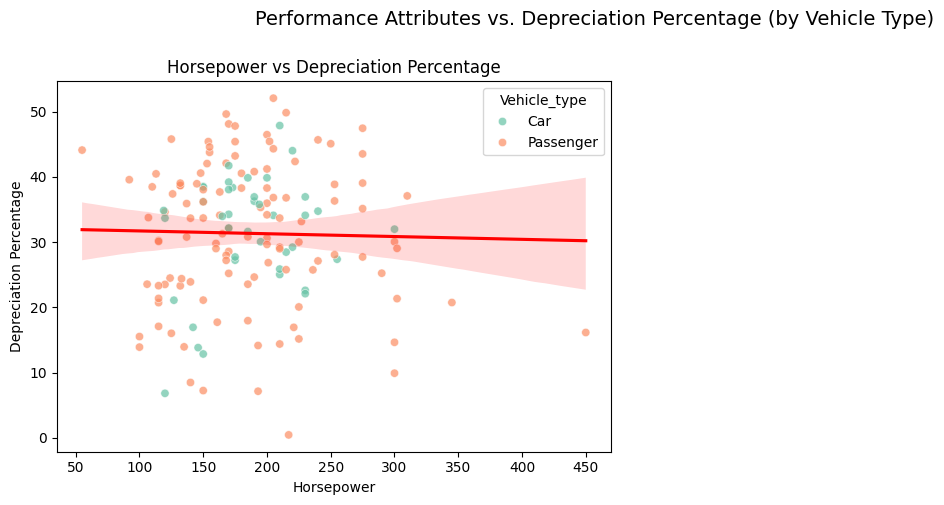

Design features influencing resale value: []
No strongly correlated design features found — skipping design plots.


In [30]:
# Performance Attributes vs Depreciation Percentage

performance_resale = [f for f in all_performance if f in selected_resale_features]
print("Performance features influencing resale value:", performance_resale)

if len(performance_resale) > 0:
    n_perf = len(performance_resale)
    n_cols = 2
    n_rows = (n_perf + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()

    idx = 0
    for feature in performance_resale:
        sns.scatterplot(data=df, x=feature, y='Depreciation_Percentage', hue='Vehicle_type',
                        alpha=0.7, palette='Set2', ax=axes[idx])
        sns.regplot(data=df, x=feature, y='Depreciation_Percentage',
                    scatter=False, color='red', ax=axes[idx])
        axes[idx].set_title(f"{feature} vs Depreciation Percentage", fontsize=12)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Depreciation Percentage')
        idx += 1

    # Remove unused subplots
    while idx < len(axes):
        fig.delaxes(axes[idx])
        idx += 1

    plt.suptitle('Performance Attributes vs. Depreciation Percentage (by Vehicle Type)', fontsize=14, y=1)
    plt.tight_layout()
    plt.show()
else:
    print("No strongly correlated performance features found — skipping performance plots.")

# Design Attributes vs Depreciation Percentage

design_resale = [f for f in all_design if f in selected_resale_features]
print("Design features influencing resale value:", design_resale)

if len(design_resale) > 0:
    n_design = len(design_resale)
    n_cols = 3
    n_rows = (n_design + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()

    idx = 0
    for feature in design_resale:
        sns.scatterplot(data=df, x=feature, y='Depreciation_Percentage', hue='Vehicle_type',
                        alpha=0.7, palette='Set2', ax=axes[idx])
        sns.regplot(data=df, x=feature, y='Depreciation_Percentage',
                    scatter=False, color='red', ax=axes[idx])
        axes[idx].set_title(f"{feature} vs Depreciation Percentage", fontsize=12)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Depreciation Percentage')
        idx += 1

    # Remove unused subplots
    while idx < len(axes):
        fig.delaxes(axes[idx])
        idx += 1

    plt.suptitle('Design Attributes vs. Depreciation Percentage (by Vehicle Type)', fontsize=14, y=1)
    plt.tight_layout()
    plt.show()
else:
    print("No strongly correlated design features found — skipping design plots.")



Top 10 Vehicles with Lowest Depreciation:


Manufacturer           Model Vehicle_type  Depreciation_Percentage  \
124      Porsche          Boxter    Passenger                 0.434468   
67          Jeep        Wrangler          Car                 6.811895   
9            BMW            528i    Passenger                 7.133676   
4           Audi              A4    Passenger                 7.232180   
139       Toyota          Celica    Passenger                 8.474074   
126      Porsche  Carrera Cabrio    Passenger                 9.897292   
143       Toyota         4Runner          Car                12.845477   
59         Honda            CR-V          Car                13.819951   
129       Saturn              SL    Passenger                13.897988   
58         Honda          Accord    Passenger                13.941368   

     Year_resale_value  
124             41.250  
67              13.475  
9               36.125  
4               22.255  
139             15.445  
126             67.550  
143             19.425  
59              17.710  
129              9.200  
58              13.210


Top 10 Vehicles with Highest Depreciation:


Manufacturer        Model Vehicle_type  Depreciation_Percentage  \
13         Buick      LeSabre    Passenger                52.088937   
77       Lincoln     Town car    Passenger                49.861528   
37         Dodge      Stratus    Passenger                49.653979   
48          Ford      Contour    Passenger                48.136190   
52          Ford     Explorer          Car                47.886001   
119      Pontiac     Grand Am    Passenger                47.819473   
76       Lincoln  Continental    Passenger                47.479529   
23     Chevrolet       Camaro    Passenger                46.487264   
86       Mercury     Mystique    Passenger                45.812808   
11         Buick        Regal    Passenger                45.691700   

     Year_resale_value  
13              13.360  
77              21.725  
37              10.185  
48               8.835  
52              16.640  
119             10.290  
76              20.525  
23              13.025  
86               8.800  
11              13.740


Average Depreciation (Top 10 Value Retainers): 9.45%
Average Depreciation (Top 10 Value Losers): 48.09%


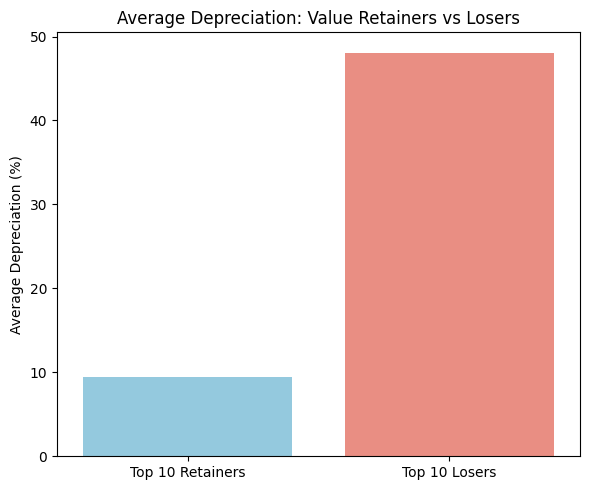

In [31]:
# Identify Vehicles with Lowest & Highest Depreciation

top_retainers = (df[['Manufacturer', 'Model', 'Vehicle_type', 'Depreciation_Percentage', 'Year_resale_value']]
                 .sort_values(by='Depreciation_Percentage', ascending=True).head(10))

top_losers = (df[['Manufacturer', 'Model', 'Vehicle_type', 'Depreciation_Percentage', 'Year_resale_value']]
              .sort_values(by='Depreciation_Percentage', ascending=False).head(10))

print("\nTop 10 Vehicles with Lowest Depreciation:")
display(top_retainers)

print("\nTop 10 Vehicles with Highest Depreciation:")
display(top_losers)

# Compare average depreciation between groups
avg_top10 = top_retainers['Depreciation_Percentage'].mean()
avg_bottom10 = top_losers['Depreciation_Percentage'].mean()

print(f'\nAverage Depreciation (Top 10 Value Retainers): {avg_top10:.2f}%')
print(f'Average Depreciation (Top 10 Value Losers): {avg_bottom10:.2f}%')

plt.figure(figsize=(6,5))
sns.barplot(
    x=['Top 10 Retainers', 'Top 10 Losers'],
    y=[avg_top10, avg_bottom10],
    hue=['Top 10 Retainers', 'Top 10 Losers'],
    palette=['skyblue', 'salmon']
)
plt.title('Average Depreciation: Value Retainers vs Losers')
plt.ylabel('Average Depreciation (%)')
plt.tight_layout()
plt.show()

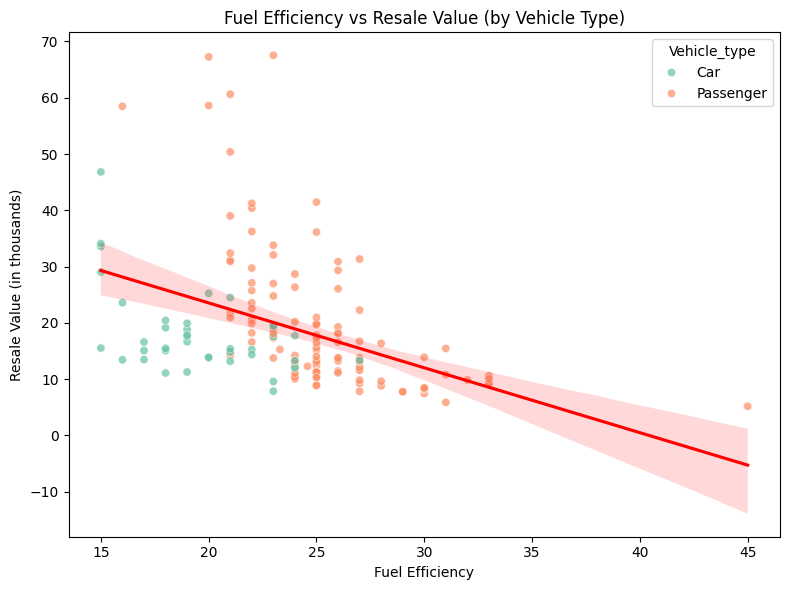

In [32]:
# Resale Value vs Fuel Efficiency

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Fuel_efficiency', y='Year_resale_value', hue='Vehicle_type', alpha=0.7, palette='Set2')
sns.regplot(data=df, x='Fuel_efficiency', y='Year_resale_value', scatter=False, color='red')
plt.title('Fuel Efficiency vs Resale Value (by Vehicle Type)')
plt.xlabel('Fuel Efficiency')
plt.ylabel('Resale Value (in thousands)')
plt.tight_layout()
plt.show()

# Power-to-Weight Ratio Analysis

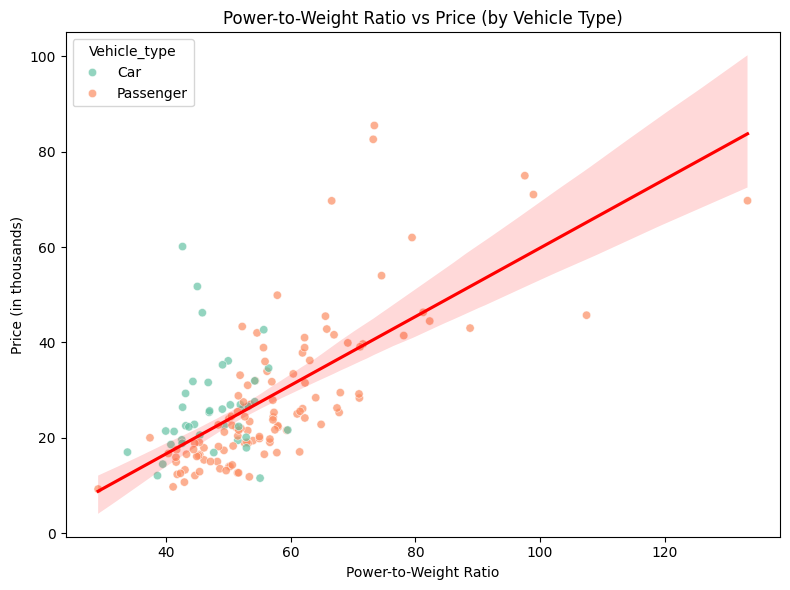

In [33]:
# Power-to-Weight Ratio vs Price

df['Power_to_Weight'] = df['Horsepower'] / df['Curb_weight']

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Power_to_Weight', y='Price_in_thousands', hue='Vehicle_type', alpha=0.7, palette='Set2')
sns.regplot(data=df, x='Power_to_Weight', y='Price_in_thousands', scatter=False, color='red')
plt.title('Power-to-Weight Ratio vs Price (by Vehicle Type)')
plt.xlabel('Power-to-Weight Ratio')
plt.ylabel('Price (in thousands)')
plt.tight_layout()
plt.show()

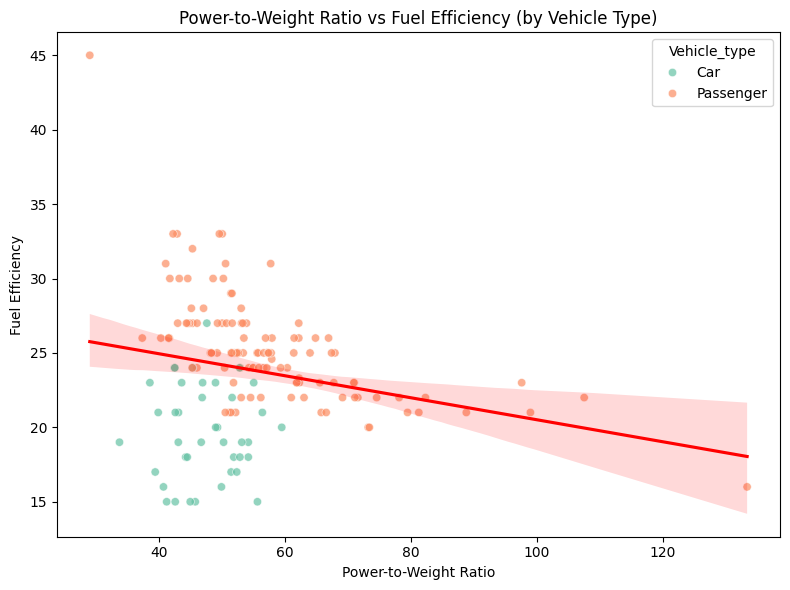

In [34]:
# Power-to-Weight Ratio vs Fuel Efficiency

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Power_to_Weight', y='Fuel_efficiency', hue='Vehicle_type', alpha=0.7, palette='Set2')
sns.regplot(data=df, x='Power_to_Weight', y='Fuel_efficiency', scatter=False, color='red')
plt.title('Power-to-Weight Ratio vs Fuel Efficiency (by Vehicle Type)')
plt.xlabel('Power-to-Weight Ratio')
plt.ylabel('Fuel Efficiency')
plt.tight_layout()
plt.show()

# Power-to-Performance Factor vs Key Business Metrics

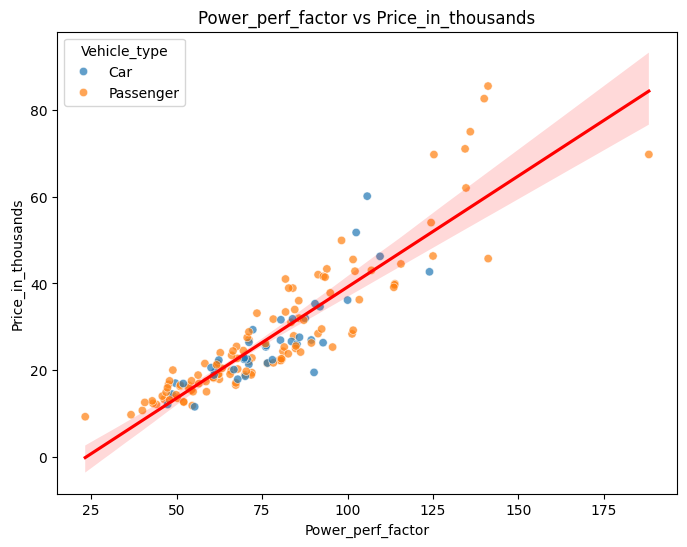

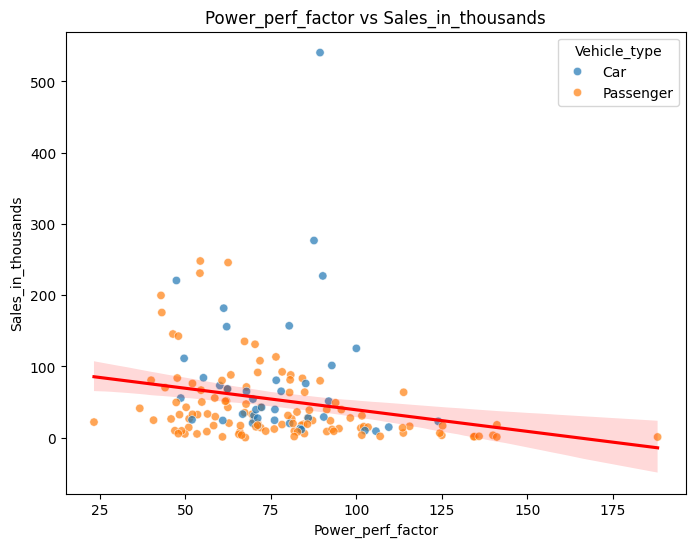

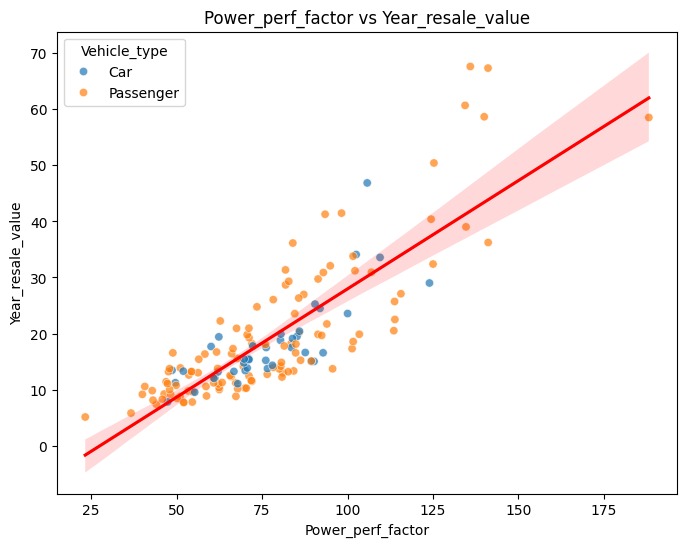

In [35]:
# How strongly does the Power-to-Performance Factor correlate 
# with key financial outcomes: vehicle price, sales volume, and resale value?

targets = ['Price_in_thousands', 'Sales_in_thousands', 'Year_resale_value']

for target in targets:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df, x='Power_perf_factor', hue='Vehicle_type', y=target, alpha=0.7)
    sns.regplot(data=df, x='Power_perf_factor', y=target, scatter=False, color='red')
    plt.title(f'Power_perf_factor vs {target}')
    plt.xlabel('Power_perf_factor')
    plt.ylabel(target)
    plt.show()

# Design and Efficiency Trade-off / Performance vs Efficiency Analysis

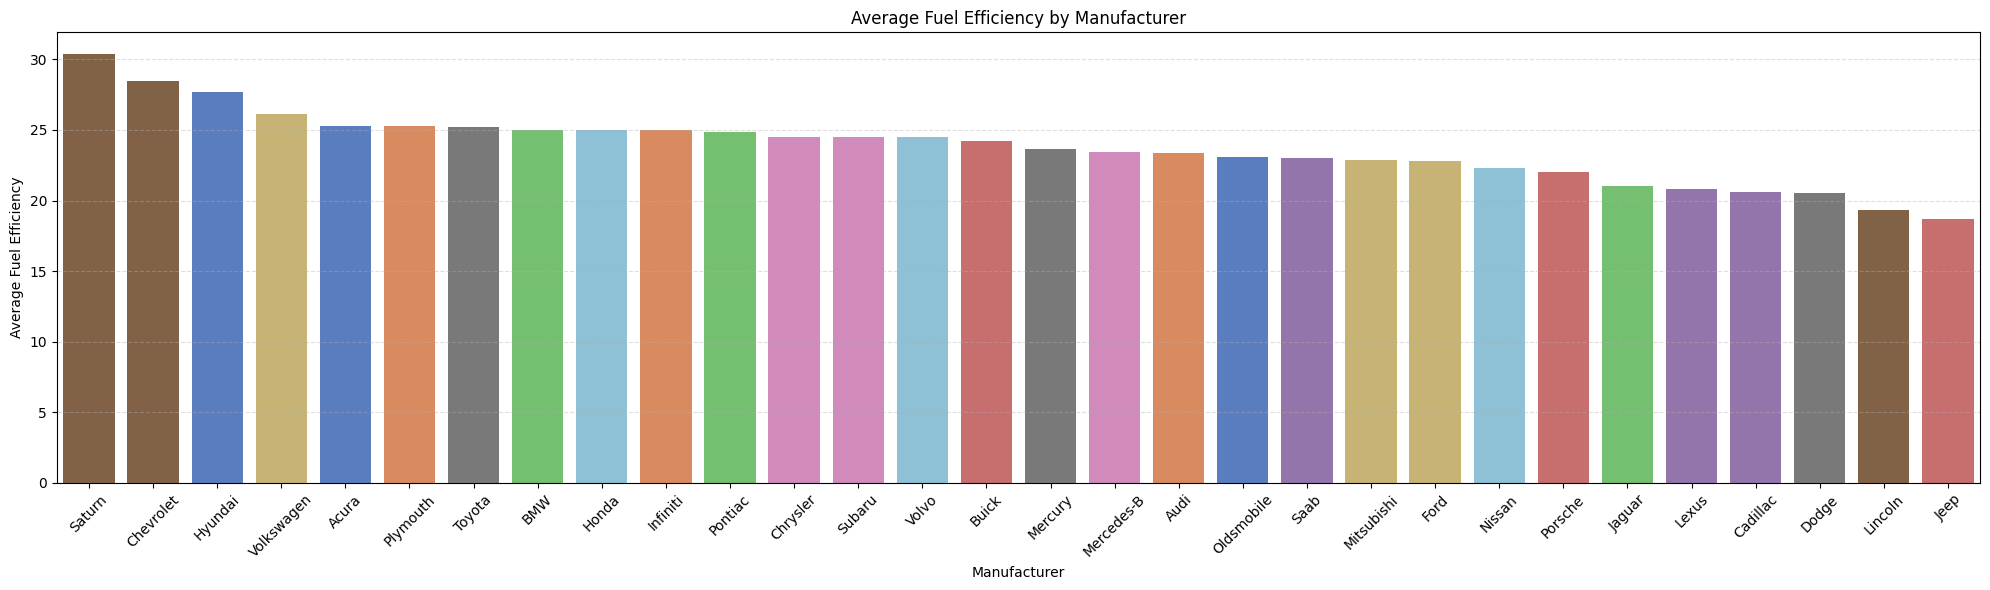

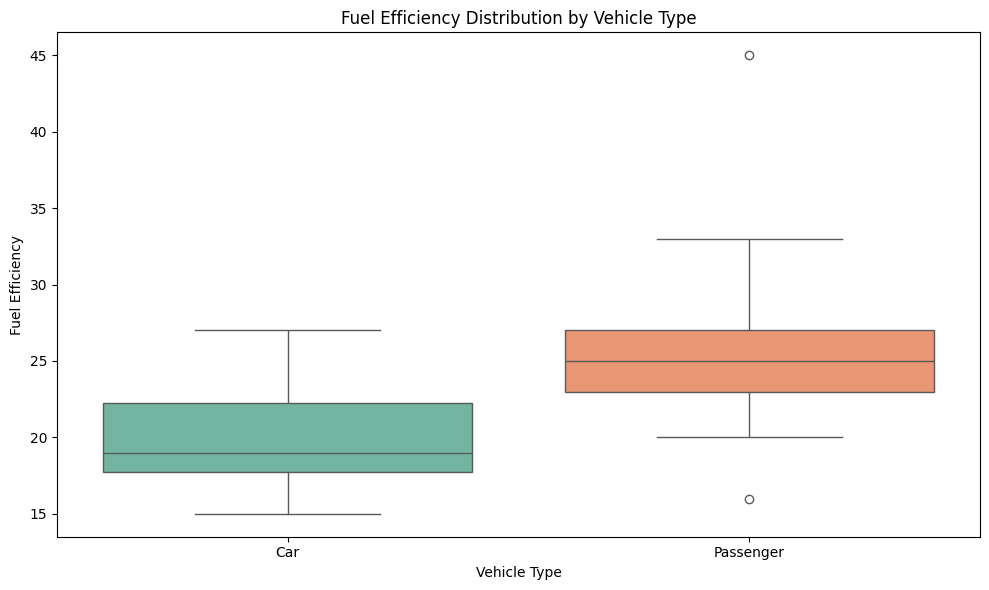

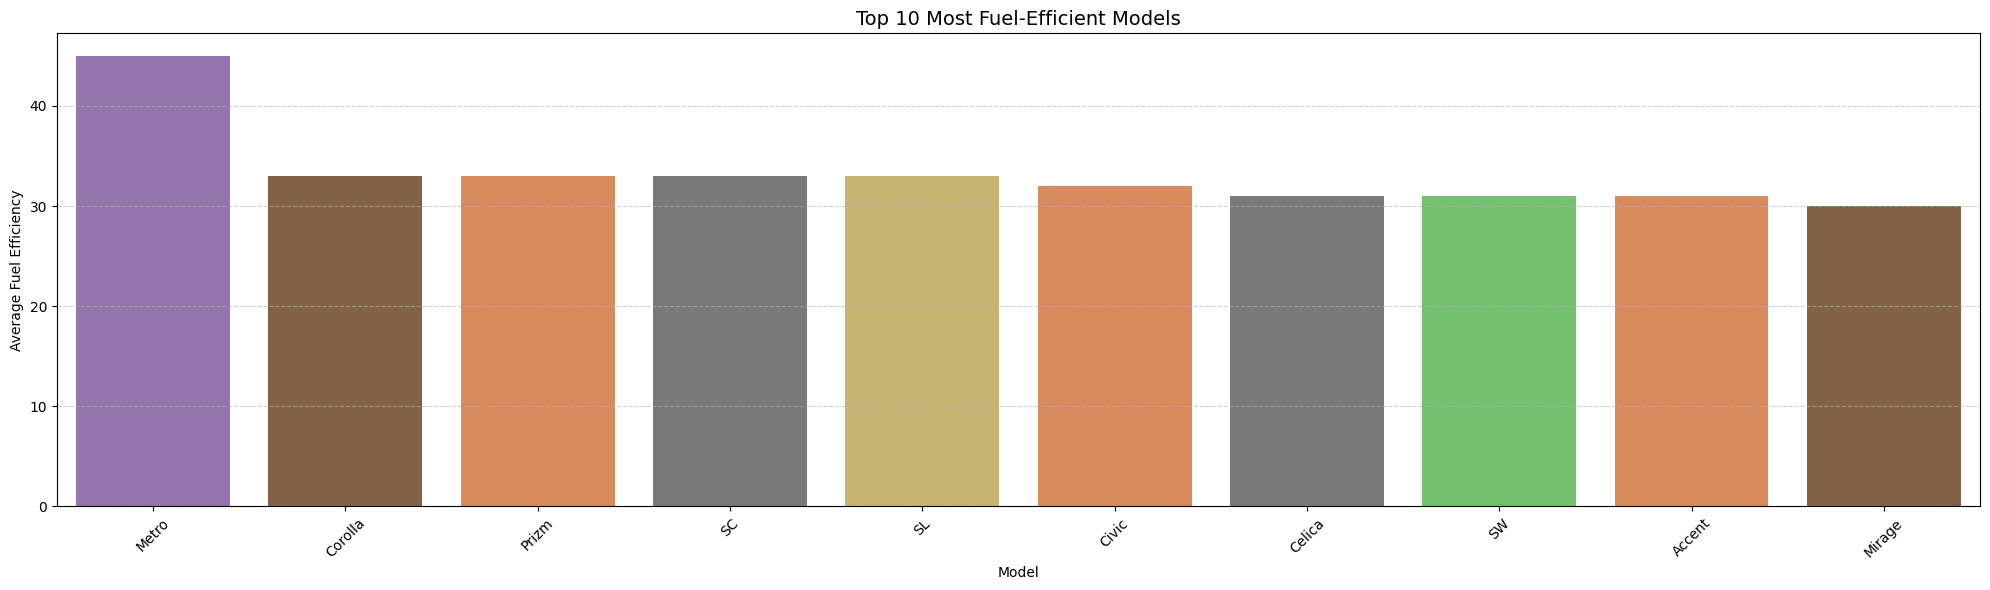

In [36]:
# Fuel Efficiency by Manufacturer

plt.figure(figsize=(20,6))
avg_fe = (df.groupby('Manufacturer', observed=True)['Fuel_efficiency']
          .mean().sort_values(ascending=False).reset_index())
sns.barplot(data=avg_fe, x='Manufacturer', y='Fuel_efficiency', order=avg_fe['Manufacturer'], hue='Manufacturer',
            palette='muted', dodge=False)
plt.xticks(rotation=45)
plt.title('Average Fuel Efficiency by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Average Fuel Efficiency')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Fuel Efficiency by Vehicle Type

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Vehicle_type', y='Fuel_efficiency', hue='Vehicle_type', palette='Set2')
plt.title('Fuel Efficiency Distribution by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Fuel Efficiency')
plt.tight_layout()
plt.show()

# Which TOP N models are the most fuel-efficient?

TOP_N_MODELS = 10

model_efficiency_df = (df.groupby('Model', observed=True)['Fuel_efficiency']
                       .mean().sort_values(ascending=False).reset_index())

top_models_df = model_efficiency_df.head(TOP_N_MODELS)
model_order_list = top_models_df['Model']

plt.figure(figsize=(20,6))
sns.barplot(data=top_models_df, x='Model', y='Fuel_efficiency', hue='Model',
            order=model_order_list, palette='muted', dodge=False)

plt.xticks(rotation=45)
plt.title(f'Top {TOP_N_MODELS} Most Fuel-Efficient Models', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Average Fuel Efficiency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

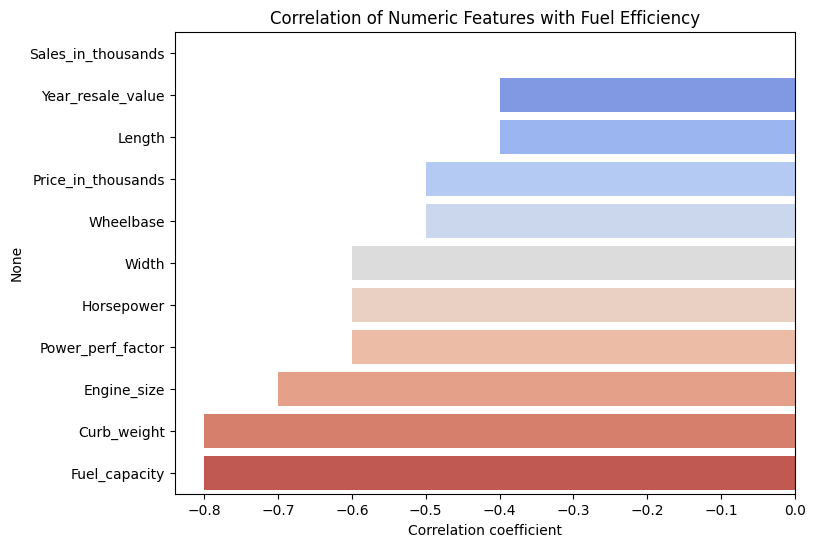

--Selected fuel-efficiency-driving features: ['Engine_size', 'Horsepower', 'Width', 'Curb_weight', 'Fuel_capacity', 'Power_perf_factor']


In [37]:
# Which factors influence Fuel Efficiency?

corr_matrix = df[numeric_cols].corr().round(1)

# Extract correlations with Fuel Efficiency
fuel_corr = corr_matrix['Fuel_efficiency'].drop('Fuel_efficiency')
fuel_corr_sorted = fuel_corr.sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=fuel_corr_sorted.values, y=fuel_corr_sorted.index, hue=fuel_corr_sorted.index,
            palette='coolwarm', dodge=False)
plt.title('Correlation of Numeric Features with Fuel Efficiency')
plt.xlabel('Correlation coefficient')
plt.show()

# Select features with strong correlations (|corr| ≥ 0.6)
selected_fuel_features = fuel_corr[fuel_corr.abs() >= 0.6].index.tolist()
print('--Selected fuel-efficiency-driving features:', selected_fuel_features)


Performance features influencing Fuel efficiency: ['Engine_size', 'Horsepower']


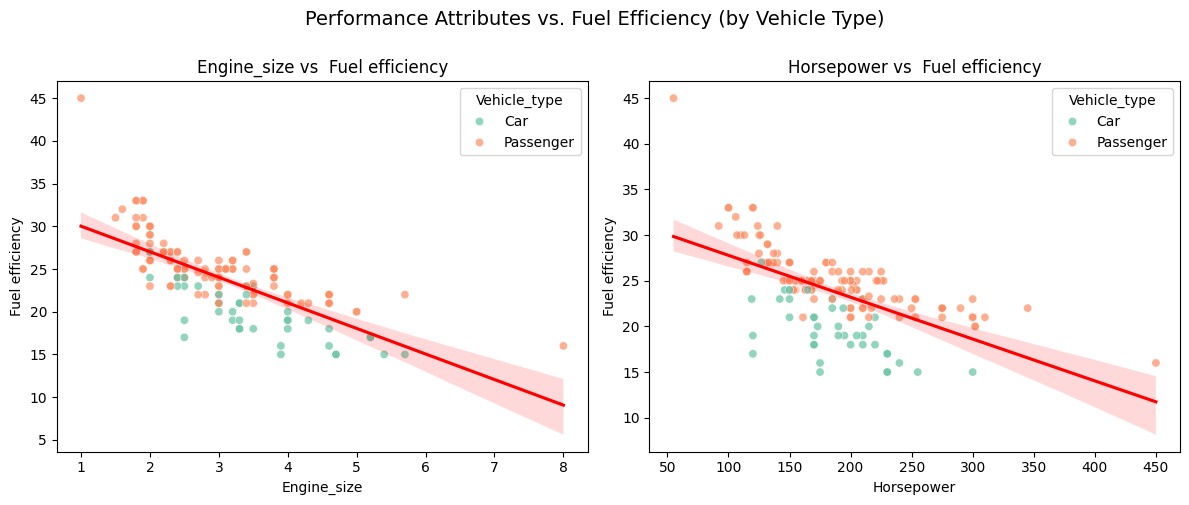

Design features influencing Fuel efficiency: ['Width', 'Curb_weight', 'Fuel_capacity']


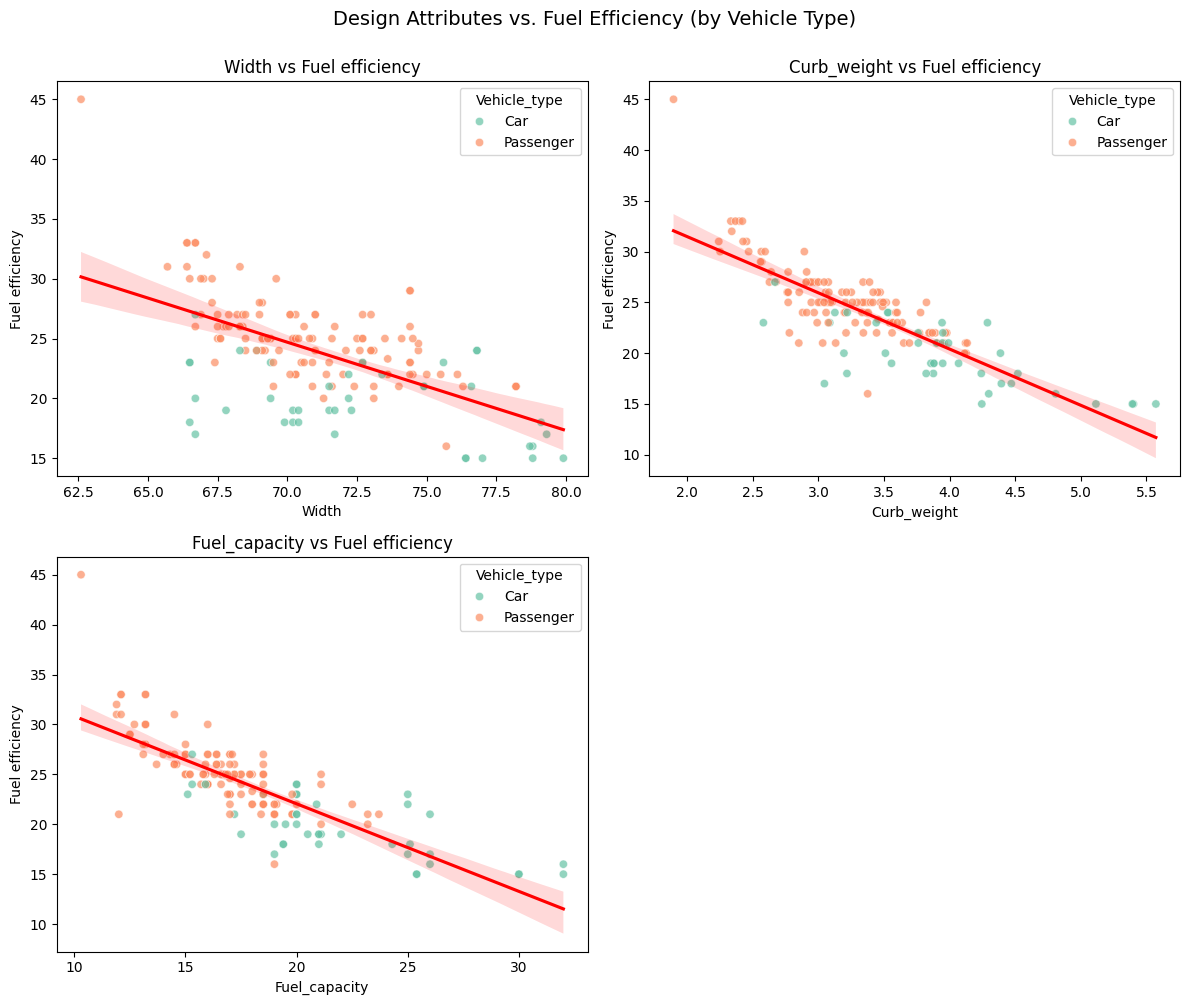

In [38]:
# Which design factors have the biggest impact on fuel economy?

# Performance Attributes vs Fuel Efficiency

performance_fuel = [f for f in all_performance if f in selected_fuel_features]
print("Performance features influencing Fuel efficiency:", performance_fuel)

if len(performance_fuel) > 0:
    n_perf = len(performance_fuel)
    n_cols = 2
    n_rows = (n_perf + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()

    idx = 0
    for feature in performance_fuel:
        sns.scatterplot(data=df, x=feature, y='Fuel_efficiency', hue='Vehicle_type',
                        alpha=0.7, palette='Set2', ax=axes[idx])
        sns.regplot(data=df, x=feature, y='Fuel_efficiency',
                    scatter=False, color='red', ax=axes[idx])
        axes[idx].set_title(f"{feature} vs  Fuel efficiency", fontsize=12)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Fuel efficiency')
        idx += 1

    # Remove unused subplots
    while idx < len(axes):
        fig.delaxes(axes[idx])
        idx += 1

    plt.suptitle('Performance Attributes vs. Fuel Efficiency (by Vehicle Type)', fontsize=14, y=1)
    plt.tight_layout()
    plt.show()
else:
    print("No strongly correlated performance features found — skipping performance plots.")

# Design Attributes vs Fuel Efficiency

design_fuel = [f for f in all_design if f in selected_fuel_features]
print("Design features influencing Fuel efficiency:", design_fuel)

if len(design_fuel) > 0:
    n_design = len(design_fuel)
    n_cols = 2
    n_rows = (n_design + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    axes = axes.flatten()

    idx = 0
    for feature in design_fuel:
        sns.scatterplot(data=df, x=feature, y='Fuel_efficiency', hue='Vehicle_type',
                        alpha=0.7, palette='Set2', ax=axes[idx])
        sns.regplot(data=df, x=feature, y='Fuel_efficiency',
                    scatter=False, color='red', ax=axes[idx])
        axes[idx].set_title(f"{feature} vs Fuel efficiency", fontsize=12)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Fuel efficiency')
        idx += 1

    # Remove unused subplots
    while idx < len(axes):
        fig.delaxes(axes[idx])
        idx += 1

    plt.suptitle('Design Attributes vs. Fuel Efficiency (by Vehicle Type)', fontsize=14, y=1)
    plt.tight_layout()
    plt.show()
else:
    print("No strongly correlated design features found — skipping design plots.")


In [39]:
# Identify Most Fuel-Efficient Models
top_fuel_eff = (df[['Manufacturer','Model','Vehicle_type','Fuel_efficiency','Price_in_thousands']]
                .sort_values(by='Fuel_efficiency', ascending=False).head(10))
display(top_fuel_eff)

# Identify Least Fuel-Efficient Models
least_fuel_eff = (df[['Manufacturer','Model','Vehicle_type','Fuel_efficiency','Price_in_thousands']]
                  .sort_values(by='Fuel_efficiency', ascending=True).head(10))
display(least_fuel_eff)

Manufacturer    Model Vehicle_type  Fuel_efficiency  Price_in_thousands
26     Chevrolet    Metro    Passenger             45.0               9.235
25     Chevrolet    Prizm    Passenger             33.0              13.960
130       Saturn       SC    Passenger             33.0              12.535
136       Toyota  Corolla    Passenger             33.0              13.108
129       Saturn       SL    Passenger             33.0              10.685
57         Honda    Civic    Passenger             32.0              12.885
62       Hyundai   Accent    Passenger             31.0               9.699
131       Saturn       SW    Passenger             31.0              14.290
139       Toyota   Celica    Passenger             31.0              16.875
50          Ford    Focus    Passenger             30.0              12.315

Manufacturer         Model Vehicle_type  Fuel_efficiency  \
18      Cadillac      Escalade          Car             15.0   
41         Dodge     Ram Wagon          Car             15.0   
74         Lexus         LX470          Car             15.0   
78       Lincoln     Navigator          Car             15.0   
144       Toyota  Land Cruiser          Car             15.0   
54          Ford    Expedition          Car             16.0   
39         Dodge         Viper    Passenger             16.0   
42         Dodge       Ram Van          Car             16.0   
40         Dodge    Ram Pickup          Car             17.0   
67          Jeep      Wrangler          Car             17.0   

     Price_in_thousands  
18               46.225  
41               21.315  
74               60.105  
78               42.660  
144              51.728  
54               36.135  
39               69.725  
42               18.575  
40               19.460  
67               14.460

# Vehicle Segmentation

Price_Segment
Economy      39
Mid-Range    40
Premium      38
Luxury       39
Name: count, dtype: int64


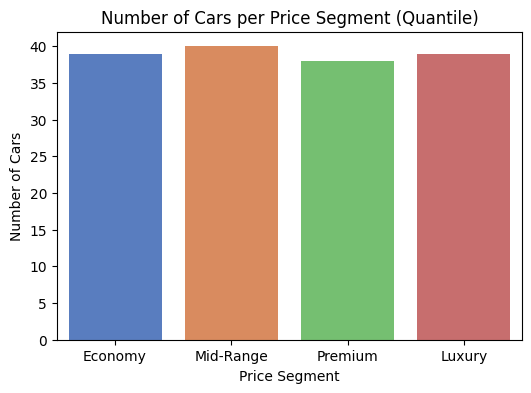

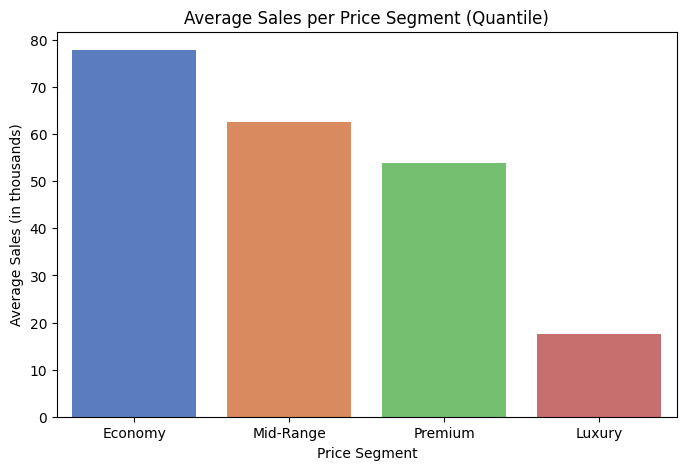


Average Performance Features by Price Segment:
                Horsepower  Engine_size  Power_perf_factor  Fuel_efficiency
Price_Segment                                                             
Economy        125.564103     2.110256          50.572654        27.769231
Mid-Range      169.950000     2.997500          68.449219        23.564661
Premium        198.157895     3.252632          81.397432        22.665871
Luxury         250.846154     3.889744         107.958534        21.358974


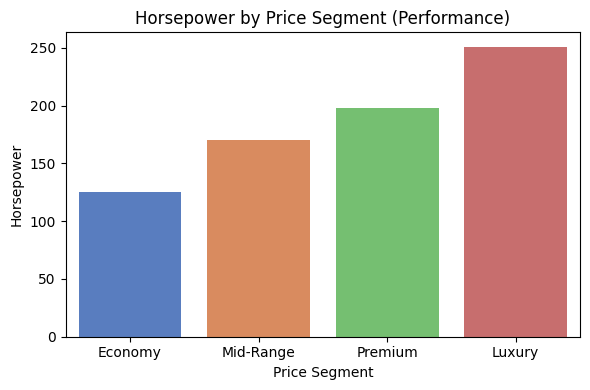

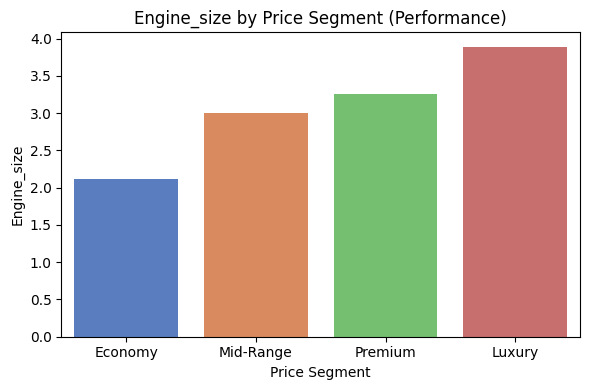

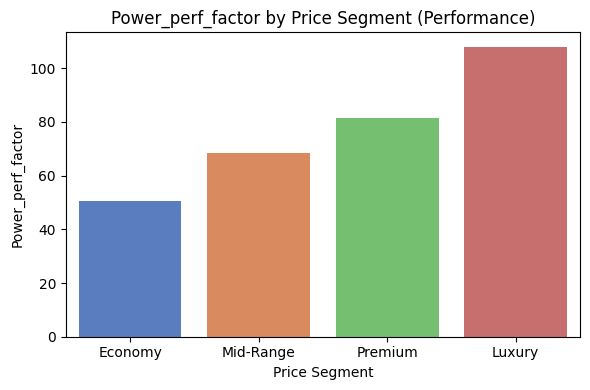

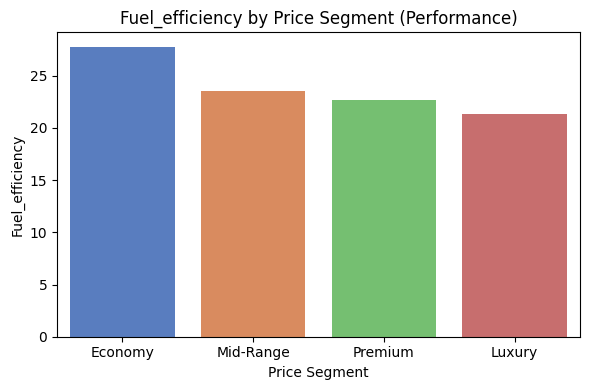


Average Size & Weight Features by Price Segment:
                 Wheelbase      Width      Length  Curb_weight  Fuel_capacity
Price_Segment                                                               
Economy        103.628205  68.446154  178.717949     2.718821      14.807692
Mid-Range      108.740000  71.912500  190.362500     3.391575      18.145000
Premium        108.815789  71.294737  190.910526     3.596658      19.007895
Luxury         108.766667  72.930769  189.397436     3.809385      19.869231


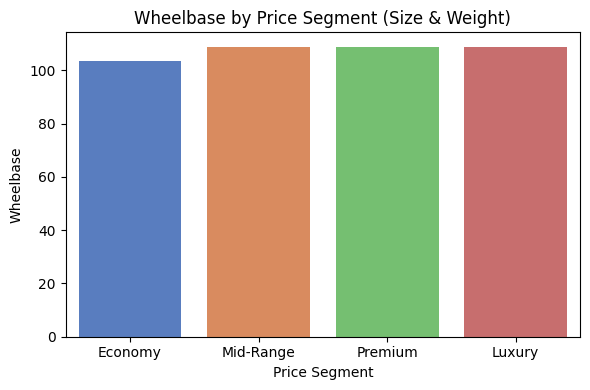

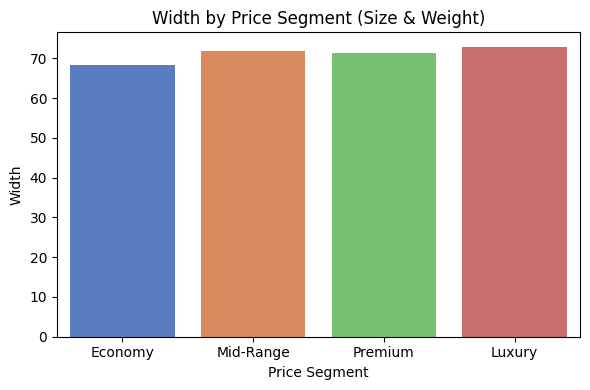

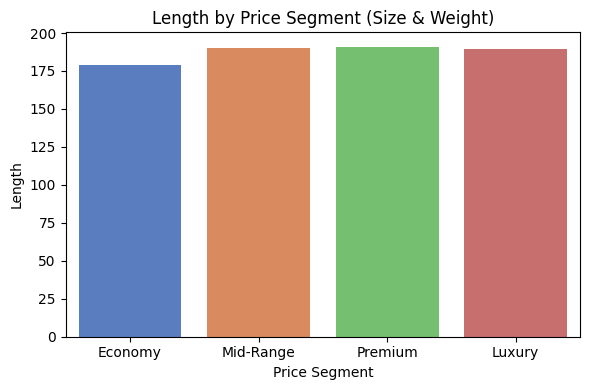

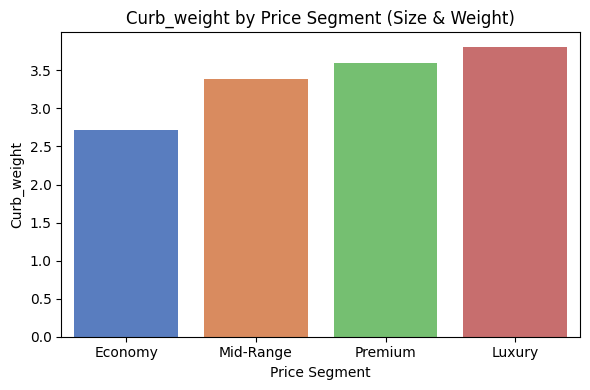

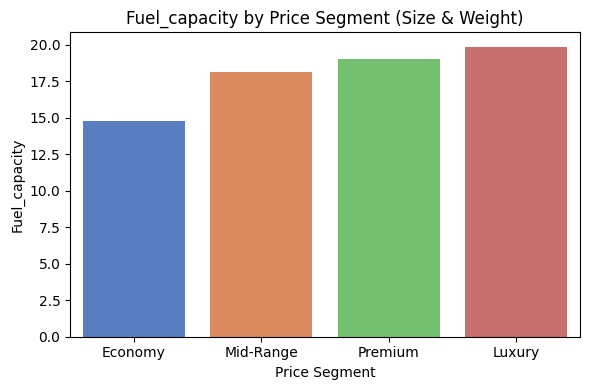


Average Financial Features by Price Segment:
                Sales_in_thousands  Year_resale_value  Depreciation_Percentage  \
Price_Segment                                                                   
Economy                 77.836205          10.202604                29.954908   
Mid-Range               62.519525          13.586966                34.487058   
Premium                 53.933974          17.941150                33.835921   
Luxury                  17.470103          34.788053                27.119241   

               Retention_Ratio  
Price_Segment                   
Economy               0.700451  
Mid-Range             0.655129  
Premium               0.661641  
Luxury                0.728808  


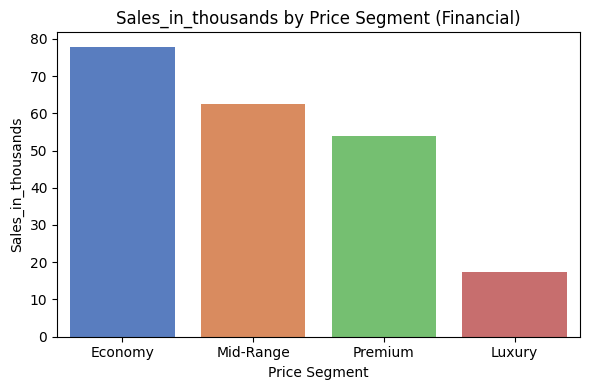

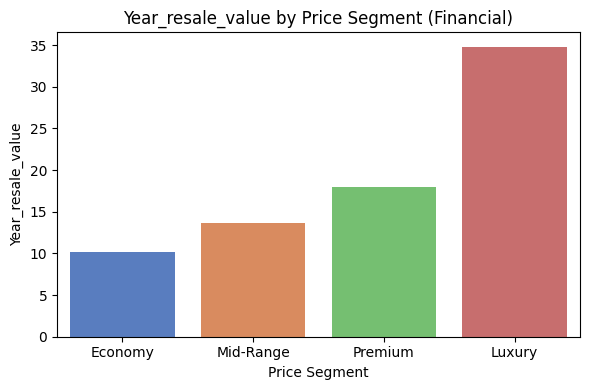

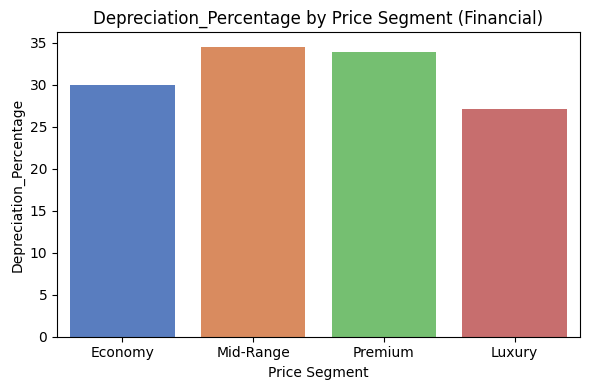

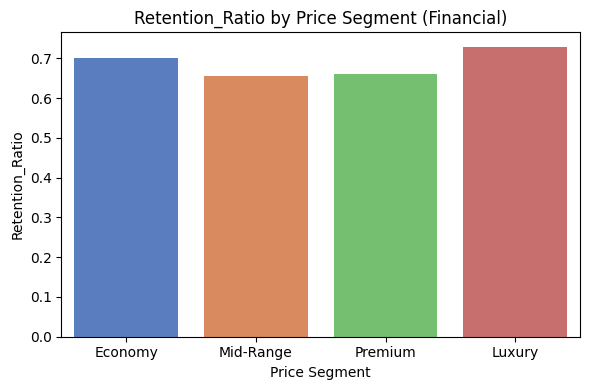

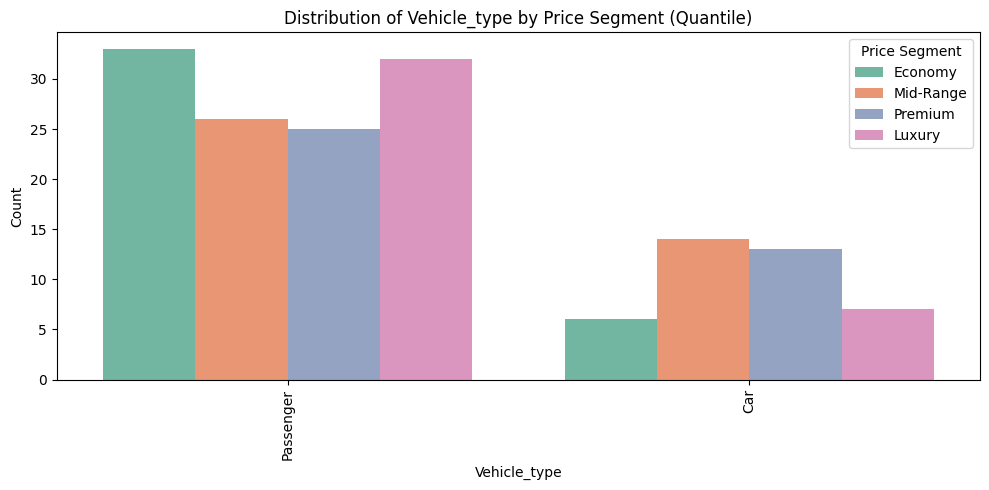

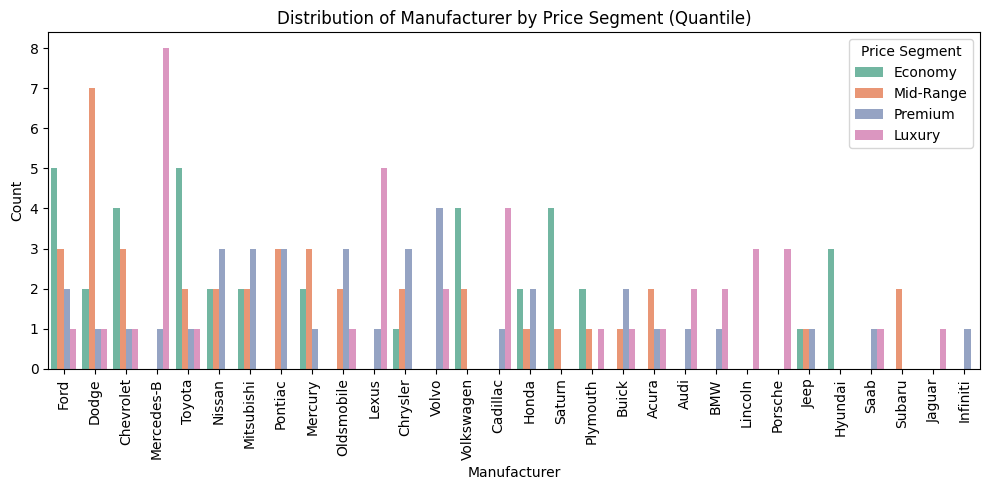

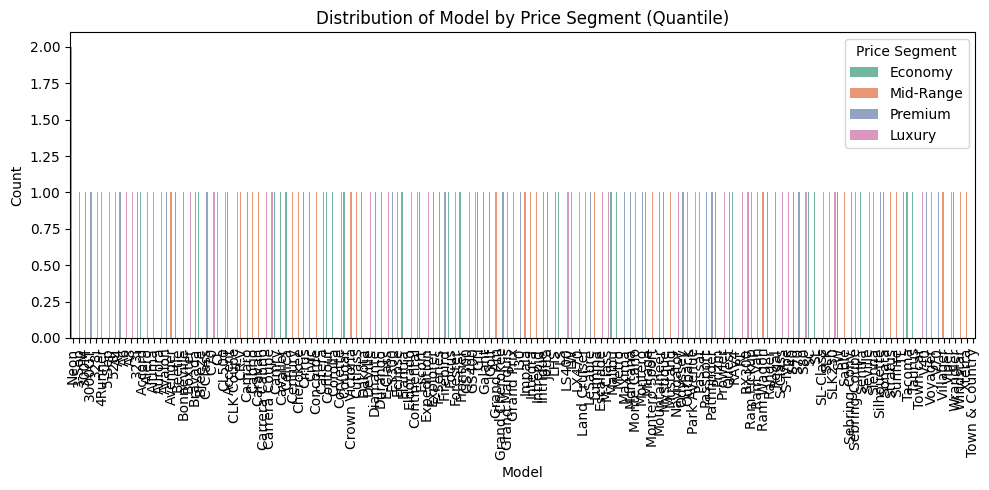

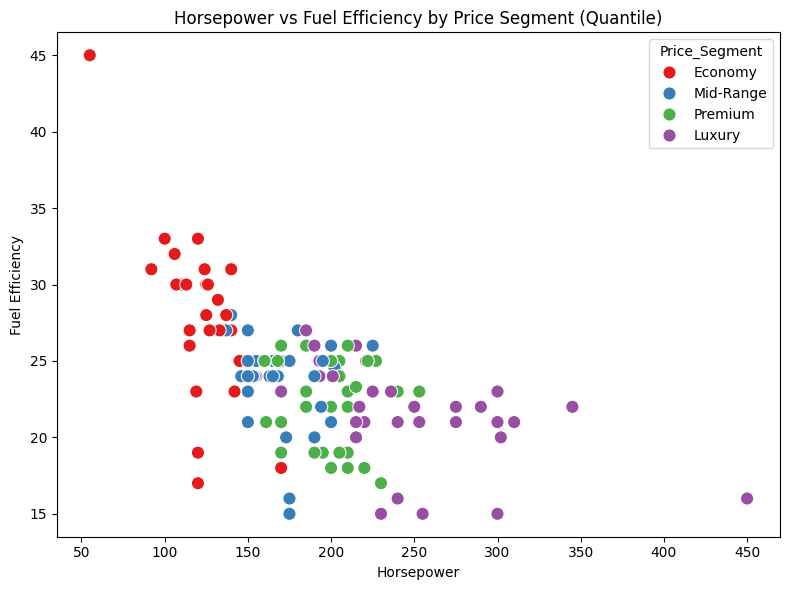

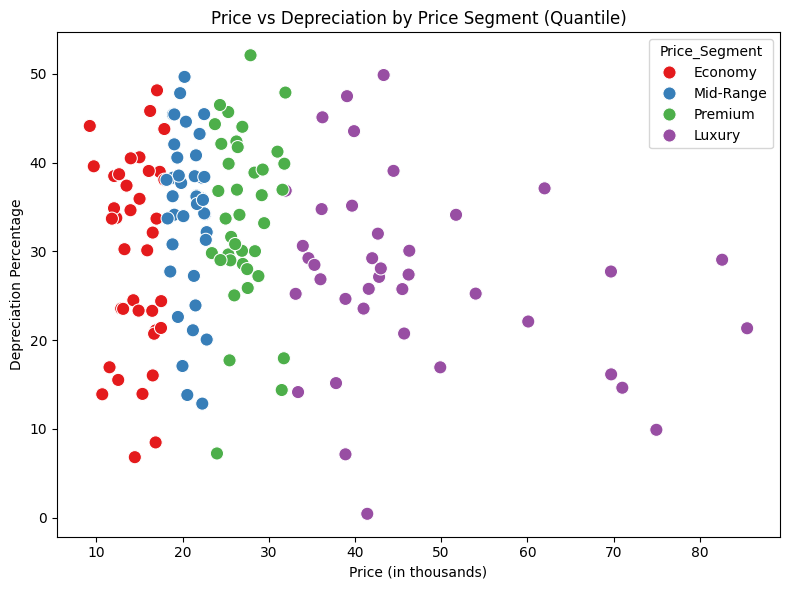

In [40]:
# Quantile Segmentation
labels = ['Economy', 'Mid-Range', 'Premium', 'Luxury']
df['Price_Segment'] = pd.qcut(df['Price_in_thousands'], q=4, labels=labels)

# Number of Cars per Segment
segment_counts = df['Price_Segment'].value_counts().reindex(labels)
print(segment_counts)
plt.figure(figsize=(6,4))
sns.barplot(x=segment_counts.index.astype(str), y=segment_counts.values, 
            hue=segment_counts.index.astype(str), palette='muted')
plt.title('Number of Cars per Price Segment (Quantile)')
plt.xlabel('Price Segment')
plt.ylabel('Number of Cars')
plt.show()

# Average Sales per Segment
avg_sales = df.groupby('Price_Segment', observed=True)['Sales_in_thousands'].mean().reindex(labels)
plt.figure(figsize=(8,5))
sns.barplot(x=avg_sales.index, y=avg_sales.values, hue=avg_sales.index,palette='muted')
plt.title('Average Sales per Price Segment (Quantile)')
plt.xlabel('Price Segment')
plt.ylabel('Average Sales (in thousands)')
plt.show()

# Full Numeric Feature Groups
feature_groups = {
    'Performance': ['Horsepower', 'Engine_size', 'Power_perf_factor', 'Fuel_efficiency'],
    'Size & Weight': ['Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity'],
    'Financial': ['Sales_in_thousands', 'Year_resale_value', 'Depreciation_Percentage', 'Retention_Ratio']
}

for group_name, features in feature_groups.items():
    avg_features = df.groupby('Price_Segment', observed=True)[features].mean().reindex(labels)
    print(f'\nAverage {group_name} Features by Price Segment:\n', avg_features)
    
    for feature in features:
        plt.figure(figsize=(6,4))
        sns.barplot(x=avg_features.index, y=avg_features[feature], hue=avg_features.index, palette='muted')
        plt.title(f'{feature} by Price Segment ({group_name})')
        plt.xlabel('Price Segment')
        plt.ylabel(feature)
        plt.tight_layout()
        plt.show()

# Categorical Distributions
categorical_features = ['Vehicle_type', 'Manufacturer', 'Model']

for cat in categorical_features:
    plt.figure(figsize=(10,5))
    sns.countplot(x=cat, hue='Price_Segment', data=df, order=df[cat].value_counts().index, palette='Set2')
    plt.title(f'Distribution of {cat} by Price Segment (Quantile)')
    plt.xlabel(cat)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.legend(title='Price Segment')
    plt.tight_layout()
    plt.show()

# Scatterplots for relationships
plt.figure(figsize=(8,6))
sns.scatterplot(x='Horsepower', y='Fuel_efficiency', hue='Price_Segment', data=df, palette='Set1', s=90)
plt.title('Horsepower vs Fuel Efficiency by Price Segment (Quantile)')
plt.xlabel('Horsepower')
plt.ylabel('Fuel Efficiency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='Price_in_thousands', y='Depreciation_Percentage', hue='Price_Segment', data=df, palette='Set1', s=90)
plt.title('Price vs Depreciation by Price Segment (Quantile)')
plt.xlabel('Price (in thousands)')
plt.ylabel('Depreciation Percentage')
plt.tight_layout()
plt.show()


# Trends Over Time

In [41]:
# Calculate precise age (years, months, days) of car from Latest_Launch

df['Launch_Year'] = df['Latest_Launch'].dt.year
df['Launch_Month'] = df['Latest_Launch'].dt.month
df['Launch_Day'] = df['Latest_Launch'].dt.day

today = datetime.today()

# Function to calculate precise age
def calc_age_from_components(row):
    if pd.isna(row['Latest_Launch']):
        return pd.Series([None, None, None])
    
    launch_date = datetime(row['Launch_Year'], row['Launch_Month'], row['Launch_Day'])
    rd = relativedelta(today, launch_date)
    return pd.Series([rd.years, rd.months, rd.days])

# Apply function row-wise
df[['Age_years', 'Age_months', 'Age_days']] = df.apply(calc_age_from_components, axis=1)

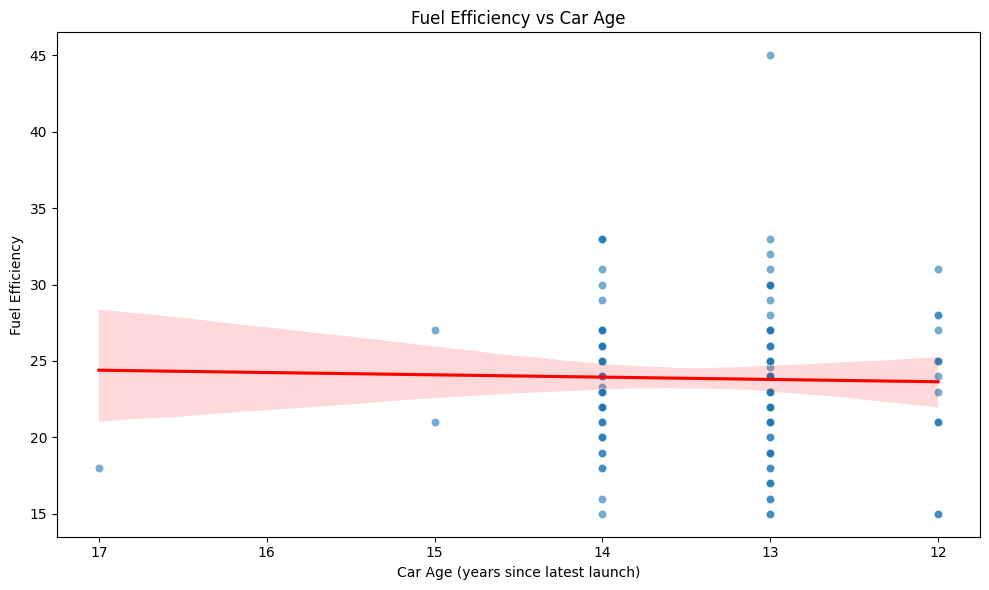

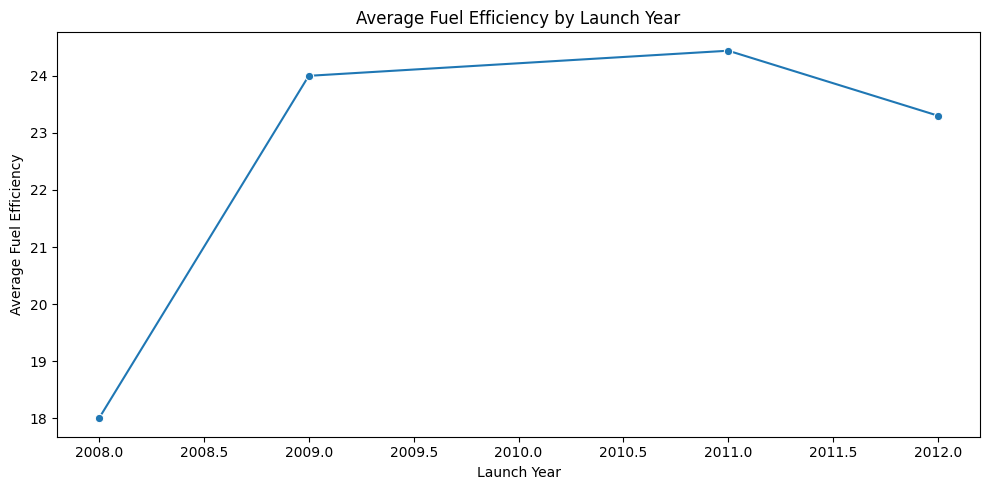

In [42]:
# Are newer cars more fuel-efficient?

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Age_years', y='Fuel_efficiency', alpha=0.6)
sns.regplot(data=df, x='Age_years', y='Fuel_efficiency', scatter=False, color='red')
plt.title('Fuel Efficiency vs Car Age')
plt.xlabel('Car Age (years since latest launch)')
plt.ylabel('Fuel Efficiency')
plt.gca().invert_xaxis()  # Show newer cars on left
plt.tight_layout()
plt.show()

# Average Fuel Efficiency by Launch Year

avg_fuel = df.groupby('Launch_Year')['Fuel_efficiency'].mean()
plt.figure(figsize=(10,5))
sns.lineplot(x=avg_fuel.index, y=avg_fuel.values, marker='o')
plt.title('Average Fuel Efficiency by Launch Year')
plt.xlabel('Launch Year')
plt.ylabel('Average Fuel Efficiency')
plt.tight_layout()
plt.show()

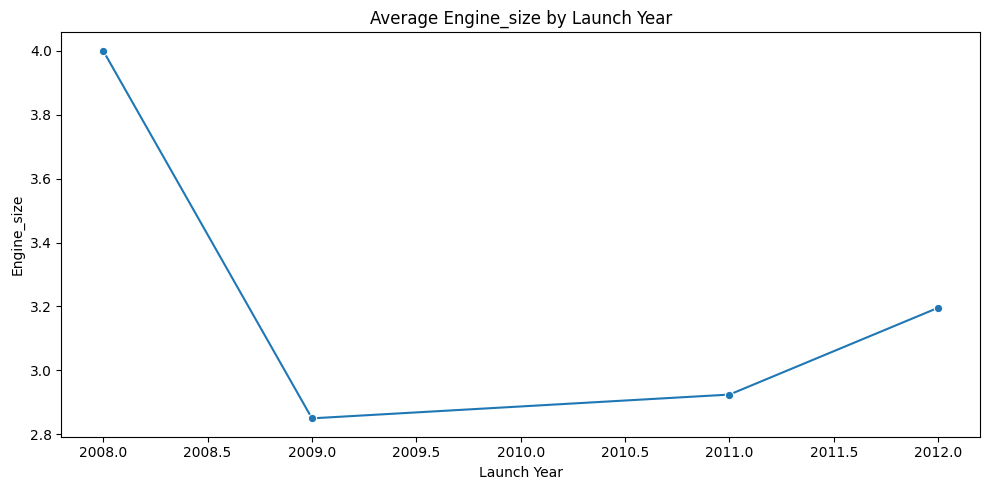

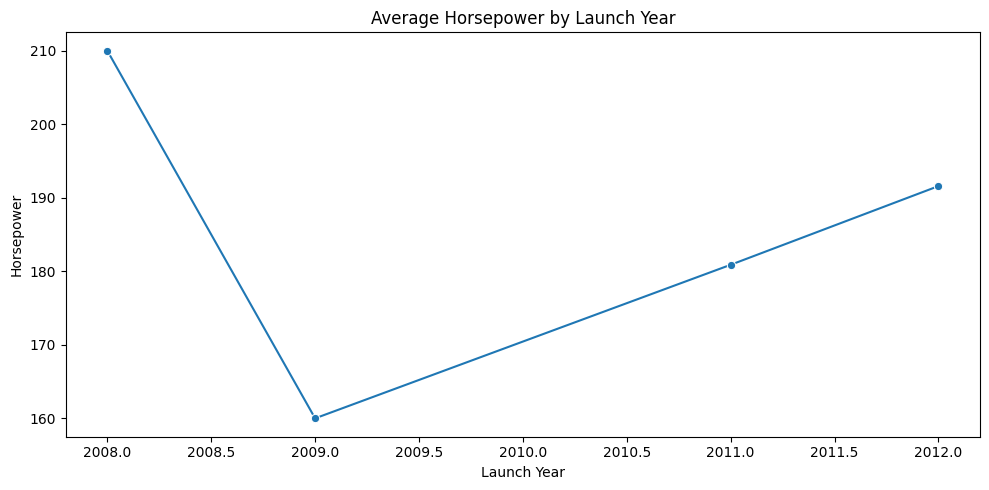

In [43]:
# How have engine sizes and horsepower evolved over time?

features = ['Engine_size', 'Horsepower']
for feature in features:
    avg_feature = df.groupby('Launch_Year')[feature].mean()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_feature.index, y=avg_feature.values, marker='o')
    plt.title(f'Average {feature} by Launch Year')
    plt.xlabel('Launch Year')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()


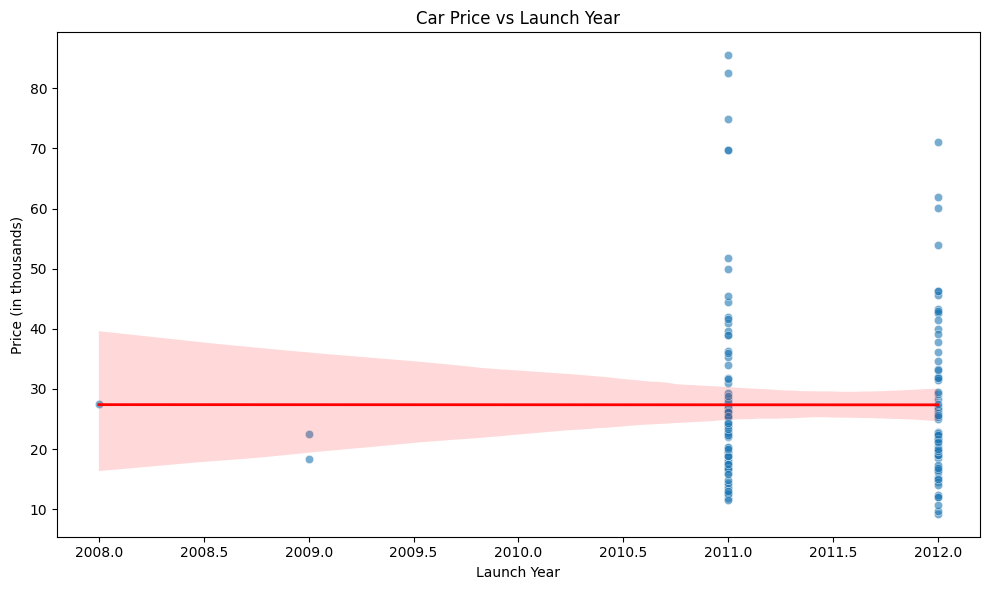

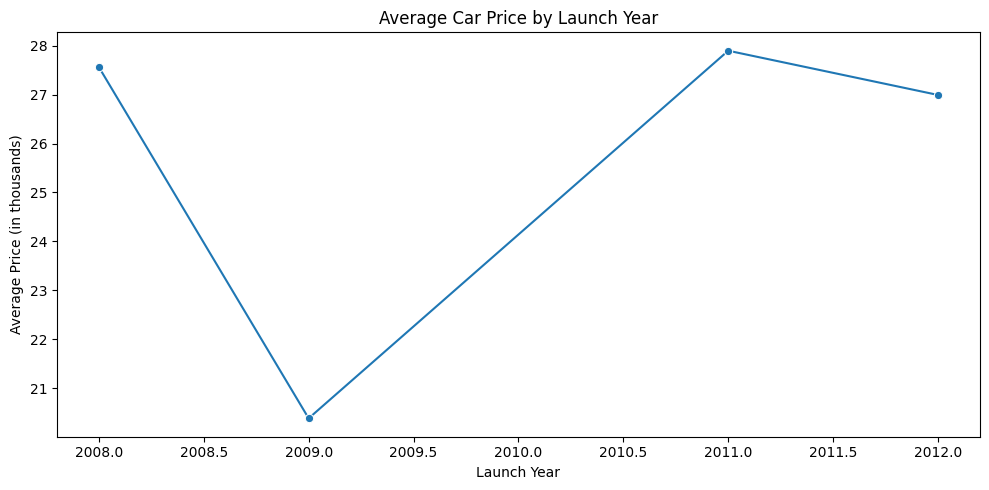

In [44]:
# Are newer cars more expensive?

# Price vs Launch Year
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Launch_Year', y='Price_in_thousands', alpha=0.6)
sns.regplot(data=df, x='Launch_Year', y='Price_in_thousands', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Car Price vs Launch Year')
plt.xlabel('Launch Year')
plt.ylabel('Price (in thousands)')
plt.tight_layout()
plt.show()

# Average Price per Launch Year
avg_price = df.groupby('Launch_Year')['Price_in_thousands'].mean()
plt.figure(figsize=(10,5))
sns.lineplot(x=avg_price.index, y=avg_price.values, marker='o')
plt.title('Average Car Price by Launch Year')
plt.xlabel('Launch Year')
plt.ylabel('Average Price (in thousands)')
plt.tight_layout()
plt.show()


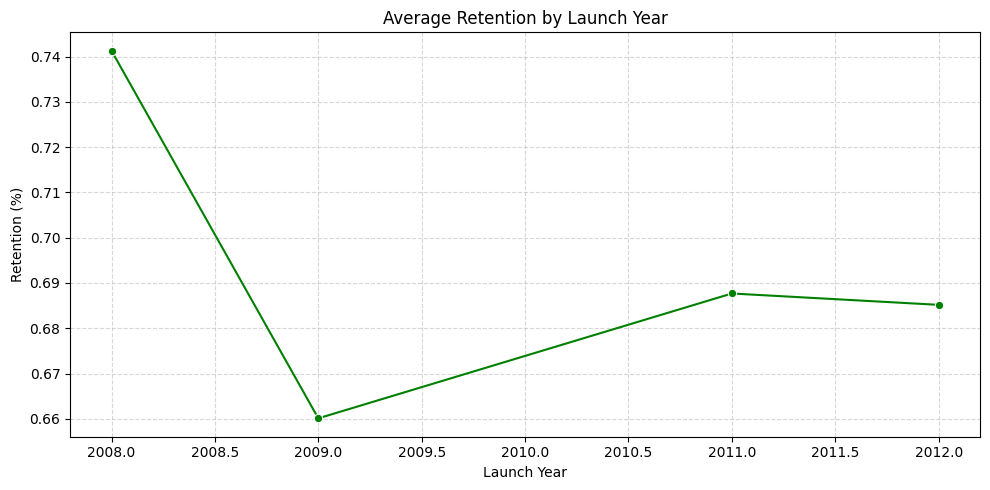

In [45]:
# Average retention ratio by launch year
avg_retention = df.groupby('Launch_Year')['Retention_Ratio'].mean()
plt.figure(figsize=(10,5))
sns.lineplot(x=avg_retention.index, y=avg_retention.values, marker='o', color='green')
plt.title('Average Retention by Launch Year')
plt.xlabel('Launch Year')
plt.ylabel('Retention (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


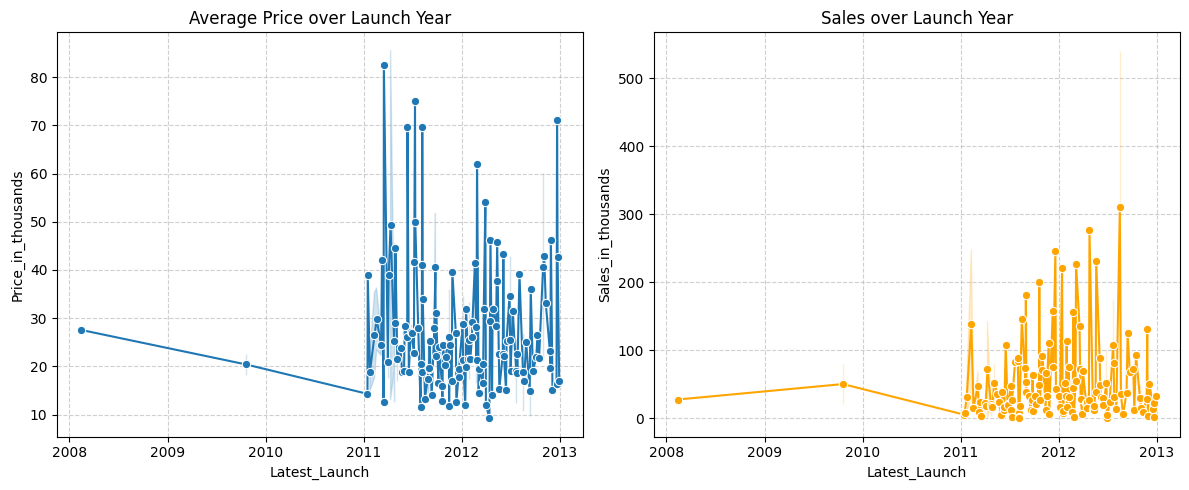

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.lineplot(data=df, x='Latest_Launch', y='Price_in_thousands', ax=ax[0], marker='o')
ax[0].set_title('Average Price over Launch Year')
ax[0].grid(True, linestyle='--', alpha=0.6)

sns.lineplot(data=df, x='Latest_Launch', y='Sales_in_thousands', ax=ax[1], marker='o', color='orange')
ax[1].set_title('Sales over Launch Year')
ax[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


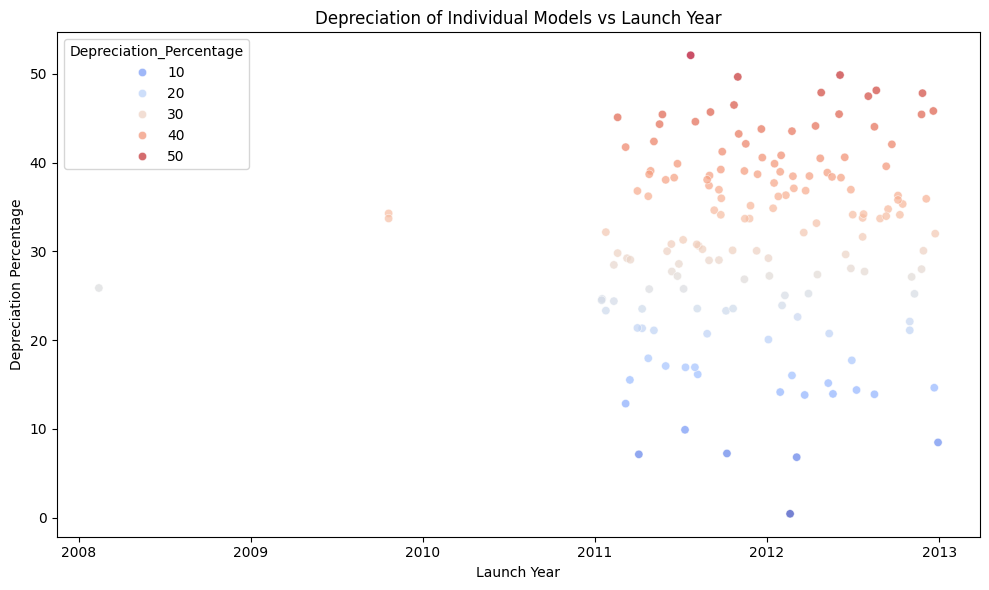

In [47]:
# Scatter plot for individual models
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Latest_Launch', y='Depreciation_Percentage', hue='Depreciation_Percentage', palette='coolwarm', alpha=0.7)
plt.title('Depreciation of Individual Models vs Launch Year')
plt.xlabel('Launch Year')
plt.ylabel('Depreciation Percentage')
plt.tight_layout()
plt.show()


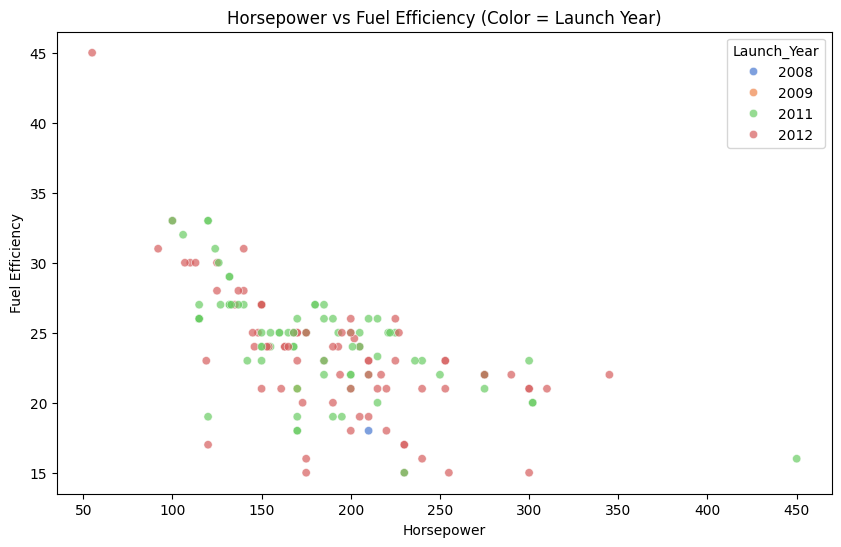

In [48]:
# Performance vs Efficiency trade-off

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Horsepower', y='Fuel_efficiency', hue='Launch_Year', palette='muted', alpha=0.7)
plt.title('Horsepower vs Fuel Efficiency (Color = Launch Year)')
plt.xlabel('Horsepower')
plt.ylabel('Fuel Efficiency')
plt.show()


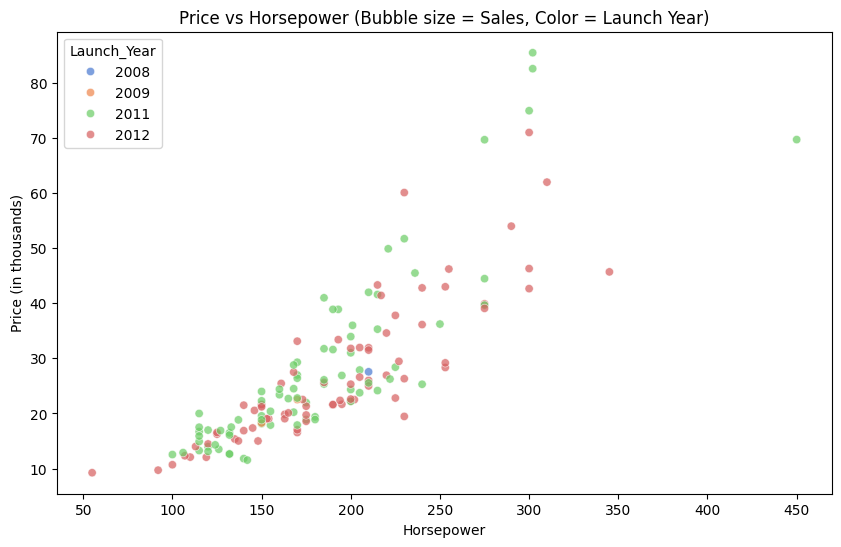

In [49]:
# Price vs Performance vs Launch Year (3D/Bubble)
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Horsepower', y='Price_in_thousands', hue='Launch_Year', palette='muted', alpha=0.7)
plt.title('Price vs Horsepower (Bubble size = Sales, Color = Launch Year)')
plt.xlabel('Horsepower')
plt.ylabel('Price (in thousands)')
plt.show()


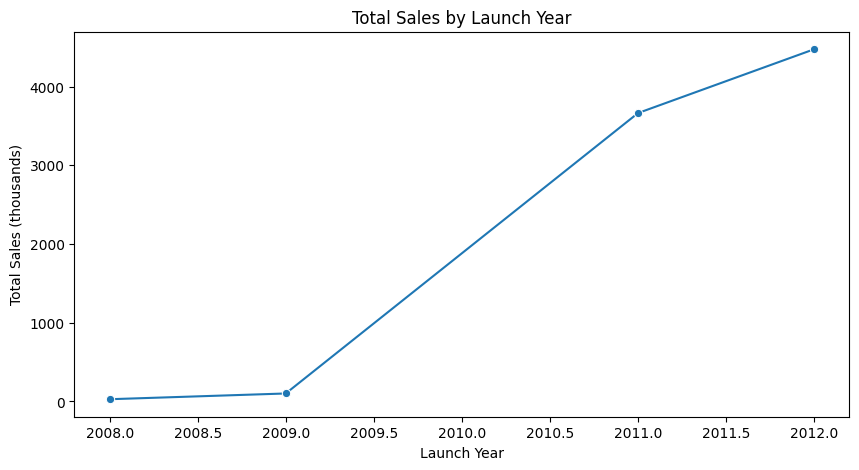

In [50]:
# Total Sales by Launch Year

total_sales = df.groupby('Launch_Year')['Sales_in_thousands'].sum()
plt.figure(figsize=(10,5))
sns.lineplot(x=total_sales.index, y=total_sales.values, marker='o')
plt.title('Total Sales by Launch Year')
plt.xlabel('Launch Year')
plt.ylabel('Total Sales (thousands)')
plt.show()


# Predictive Modeling

In [51]:
import statsmodels.api as sm

predict_cols = ['Engine_size', 'Horsepower', 'Curb_weight', 'Length', 'Width', 'Wheelbase', 'Fuel_efficiency', 'Fuel_capacity', 'Power_perf_factor']
X = sm.add_constant(df[predict_cols])
y_price = df['Price_in_thousands']
y_sales = df['Sales_in_thousands']

model_price = sm.OLS(y_price, X).fit()
print(model_price.summary())

model_sales = sm.OLS(y_sales, X).fit()
print(model_sales.summary())


                            OLS Regression Results                            
Dep. Variable:     Price_in_thousands   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     390.8
Date:                Mon, 13 Oct 2025   Prob (F-statistic):           1.88e-97
Time:                        02:39:27   Log-Likelihood:                -384.60
No. Observations:                 156   AIC:                             789.2
Df Residuals:                     146   BIC:                             819.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.3594      7.53

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[predict_cols])

lr_price = LinearRegression().fit(X_scaled, y_price)
lr_sales = LinearRegression().fit(X_scaled, y_sales)

coeff_price = pd.Series(lr_price.coef_, index=predict_cols).sort_values(key=abs, ascending=False)
coeff_sales = pd.Series(lr_sales.coef_, index=predict_cols).sort_values(key=abs, ascending=False)

print("Feature Importance for Price Prediction:\n", coeff_price)
print("Feature Importance for Sales Prediction:\n", coeff_sales)
print("\nR² Price:", r2_score(y_price, lr_price.predict(X_scaled)))
print("R² Sales:", r2_score(y_sales, lr_sales.predict(X_scaled)))


Feature Importance for Price Prediction:
 Power_perf_factor    48.109776
Horsepower          -34.322915
Curb_weight           1.745101
Engine_size          -1.675039
Fuel_efficiency       0.955790
Length               -0.641722
Width                -0.579303
Fuel_capacity         0.319490
Wheelbase            -0.194698
dtype: float64
Feature Importance for Sales Prediction:
 Wheelbase            35.946604
Engine_size          35.158160
Curb_weight         -30.662292
Horsepower          -19.106123
Power_perf_factor   -18.971324
Fuel_efficiency      -5.557244
Length               -1.371829
Fuel_capacity         1.152422
Width                -0.332524
dtype: float64

R² Price: 0.960148955276417
R² Sales: 0.3100746904499009
